Author: Rohan Krishna Balaji  <br>
Course : Simulation Science <br>
Date  : 25.06.2021  <br>
Project : ICTM Analysis, Master's Thesis at Fraunhofer IPT <br>
Email :  rohan.balaji@rwth-aachen.de <br>
Verion : 1.01 <br>

# Introduction
To obtain the complete data set which includes feature from both planning data used in CAM planning and machining data obtained from Parquet fles First is to convert the machining data in machine coordinate system to tool tip data in work space coordinate system through 'Forward Kinematic Transformations' on compensated data. Then each tool tip data is clusterd to the correspoding acqired data points. Then the obtained clasters are averged to generate combined dataset with both planning and machining data.
The dataset is filtered to remove the outliers

In [1]:
# Importing necessary libraries and general settings
import transformation
import compensation
import data_imports
import pandas as pd
import os
import glob
import math
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from mpl_toolkits import mplot3d
import numpy as np
from scipy.signal import find_peaks

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf)

Path locations (folder location) for respective files

In [2]:
dir_paraquet = 'Manufacturing_Data/'
dir_planning = 'Planing_Data/'
dir_final_save  = 'Final_df/' 

In [3]:
print('Enter the Block number, example 1030')
block = input()
block = int(block)

Enter the Block number, example 1030
1030


In [4]:
## print('Enter the blade angle, muliples of 12')
angle = input()
angle = int(angle)

24


In [5]:
# Importing all the data
df_m,df_p,compensation_values_df = data_imports.data_out(block,angle,dir_paraquet,dir_planning)

In [6]:
df_p.columns

Index(['Leading angle', 'Side tilt angle', 'Surface Contact point X',
       'Surface contact point Y', 'Surface contact point z',
       'Surface Orietation X', 'Surface Orietation Y', 'Surface Orietation Z',
       'Tool Tip Point X', 'Tool Tip Point Y', 'Tool Tip Point Z',
       'Tool Orientation X', 'Tool Orientation Y', 'Tool Orientation Z',
       'Closes Point Distance (Surface Contact Point - Acquired TCP 1030 blade0)'],
      dtype='object')

In [7]:
df_m.columns

Index(['time', 'MachineX', 'MachineY', 'MachineZ', 'MachineA', 'MachineC',
       'LoadSpindle', 'TransfX', 'TransfY', 'TransfZ', 'TransfI', 'TransfJ',
       'TransfK', 'executionDuration', 'previousExecutionDuration',
       'relativeTimetoPreviousCall program number', 'timeStamp', 'Tool Length',
       'Tool Radius', 'G54-X', 'G54-Y', 'G54-Z', 'G54-A', 'G54-C',
       'ProgNumber', 'Blade', 'Step', 'Level', 'Fx_mean', 'Fy_mean', 'Fz_mean',
       'Mz_mean', 'Fc_mean', 'Fa_mean', 'FcN_mean', 'Fres_mean', 'Fx_sigma',
       'Fy_sigma', 'Fz_sigma', 'Mz_sigma', 'Fc_sigma', 'Fa_sigma', 'FcN_sigma',
       'Fres_sigma', 'Fx_max', 'Fy_max', 'Fz_max', 'Mz_max', 'Fc_max',
       'Fa_max', 'FcN_max', 'Fres_max'],
      dtype='object')

In [44]:
# Just copying machine data points linear(x,y,x) and rotart (a,c) into arrays.
# These machine points (x,y,x,a,c) are transformed from machine coordinate system to workpiece coordinate system by forward tramsformation

x = df_m['MachineX'].copy(deep=True)
y = df_m['MachineY'].copy(deep=True)
z = df_m['MachineZ'].copy(deep=True)
a = np.radians(df_m['MachineA']).copy(deep=True)
c = np.radians(df_m['MachineC']).copy(deep=True)

size1 = x.shape[0]

# converting pandas series to numpy array
x = x.to_numpy()
y = y.to_numpy()
z = z.to_numpy()
a = a.to_numpy()
c = c.to_numpy()

In [45]:
#compensation_values
compensation_values = compensation_values_df.to_numpy()

### Applying compensation on the Aquired Data
Based on the macine position compensation is applied to the machine datat, so that the errors are negated. This is implemented in the script compensation.py 
<img src="images/compensation.png">

In [10]:
# Within each cube we have ranges defined in x,y,z for the machine position

x_range = np.arange(-200,201,100)
y_range = np.arange(-300,301,150)
z_range = np.arange(-500,1,50)

obj3 = compensation.Compensation(compensation_values,x_range,y_range,z_range)

# Caclculation of compensation error values based on machine positions obtained through inverse transformation
deltaX1, deltaY1, deltaZ1,deltaI1,deltaJ1,deltaK1 = obj3.calculate(x,y,z)  
size3 = x.shape[0]

conc3 = np.concatenate((deltaX1.reshape(size3,1),deltaY1.reshape(size3,1),deltaZ1.reshape(size3,1),deltaI1.reshape(size3,1),deltaJ1.reshape(size3,1),deltaK1.reshape(size3,1)),axis=1)

# prininting the compensation error values
df_obj3 = pd.DataFrame(conc3, columns=['deltaX1','deltaY1','deltaZ1','deltaI1','deltaJ1','deltaK1'])
df_obj3.head(5)  
                          

deltaX1    deltaY1    deltaZ1  deltaI1  deltaJ1  deltaK1
0  26.443495 -11.914891 -10.001572      0.0      0.0      0.0
1  26.443495 -11.914891 -10.001572      0.0      0.0      0.0
2  26.443495 -11.914891 -10.001572      0.0      0.0      0.0
3  26.443495 -11.914891 -10.001572      0.0      0.0      0.0
4  26.443495 -11.914891 -10.001572      0.0      0.0      0.0

In [11]:
x_compensated = x + deltaX1*10**-3    # since given compensation is to be converted from microns to mm (10**-6 x 10**3 = 10**-3)
y_compensated = y + deltaY1*10**-3
z_compensated = z + deltaZ1*10**-3

conc4 = np.concatenate((x_compensated.reshape(size3,1),y_compensated.reshape(size3,1),z_compensated.reshape(size3,1)),axis=1)
df_obj4 = pd.DataFrame(conc4, columns=['x_compensated','y_compensated','z_compensated'])
df_obj4.head(5)

x_compensated  y_compensated  z_compensated
0    -158.991757    -118.613215     -79.440502
1    -158.991757    -118.613215     -79.440502
2    -158.991757    -118.613215     -79.440502
3    -158.991757    -118.613215     -79.440502
4    -158.991757    -118.613215     -79.440502

In [12]:
df_m['compensation_x'] = deltaX1*10**-3
df_m['compensation_y'] = deltaY1*10**-3
df_m['compensation_z'] = deltaZ1*10**-3
df_m.iloc[10000:10010]

time  MachineX  MachineY  MachineZ  MachineA  MachineC  \
86.739998  86.739998 -103.6344  -96.2363 -168.2141  -82.2746  349.7110   
86.754997  86.754997 -103.8011  -95.9182 -168.0601  -82.1433  349.5896   
86.760002  86.760002 -103.8011  -95.9182 -168.0601  -82.1433  349.5896   
86.769997  86.769997 -104.1187  -95.2880 -167.7545  -81.8854  349.3557   
86.777496  86.777496 -104.1187  -95.2880 -167.7545  -81.8854  349.3557   
86.784996  86.784996 -104.4358  -94.6181 -167.4276  -81.6143  349.1175   
86.792496  86.792496 -104.4358  -94.6181 -167.4276  -81.6143  349.1175   
86.800003  86.800003 -104.5901  -94.2771 -167.2603  -81.4773  348.9996   
86.807503  86.807503 -104.7412  -93.9328 -167.0906  -81.3395  348.8826   
86.815002  86.815002 -105.0218  -93.2545 -166.7528  -81.0700  348.6595   

           LoadSpindle    TransfX     TransfY    TransfZ   TransfI   TransfJ  \
86.739998     9.977273 -67.894437  206.197763  33.233967  0.468635 -0.304750   
86.754997     9.995455 -67.636912  206.286409  33.376734  0.341425 -0.286402   
86.760002     9.995455 -67.636912  206.286409  33.376734  0.341425 -0.286402   
86.769997     9.995455 -67.136724  206.457658  33.653001  0.120803 -0.162619   
86.777496     9.995455 -67.136724  206.457658  33.653001  0.120803 -0.162619   
86.784996    10.031818 -66.620311  206.632905  33.937973 -0.026158  0.061746   
86.792496    10.031818 -66.620311  206.632905  33.937973 -0.026158  0.061746   
86.800003    10.031818 -66.361738  206.720172  34.080315 -0.056564  0.194642   
86.807503    10.031818 -66.102898  206.807110  34.222738 -0.055341  0.330687   
86.815002    10.059091 -65.600959  206.974743  34.498297  0.032865  0.573080   

            TransfK  executionDuration  previousExecutionDuration  \
86.739998  0.829161           0.004907                   0.002006   
86.754997  0.895211           0.010303                   0.004907   
86.760002  0.895211           0.003265                   0.010303   
86.769997  0.979266           0.006443                   0.003265   
86.777496  0.979266           0.002092                   0.006443   
86.784996  0.997749           0.007135                   0.002092   
86.792496  0.997749           0.001943                   0.007135   
86.800003  0.979242           0.008211                   0.001943   
86.807503  0.942116           0.002962                   0.008211   
86.815002  0.818840           0.010271                   0.002962   

           relativeTimetoPreviousCall program number     timeStamp  \
86.739998                                   0.007052  6.375063e+10   
86.754997                                   0.007656  6.375063e+10   
86.760002                                   0.010422  6.375063e+10   
86.769997                                   0.006799  6.375063e+10   
86.777496                                   0.006882  6.375063e+10   
86.784996                                   0.006974  6.375063e+10   
86.792496                                   0.007172  6.375063e+10   
86.800003                                   0.006769  6.375063e+10   
86.807503                                   0.008301  6.375063e+10   
86.815002                                   0.006664  6.375063e+10   

           Tool Length  Tool Radius  G54-X  G54-Y    G54-Z  G54-A  G54-C  \
86.739998     226.4591          6.0    0.0    0.0 -510.483   24.0    0.0   
86.754997     226.4591          6.0    0.0    0.0 -510.483   24.0    0.0   
86.760002     226.4591          6.0    0.0    0.0 -510.483   24.0    0.0   
86.769997     226.4591          6.0    0.0    0.0 -510.483   24.0    0.0   
86.777496     226.4591          6.0    0.0    0.0 -510.483   24.0    0.0   
86.784996     226.4591          6.0    0.0    0.0 -510.483   24.0    0.0   
86.792496     226.4591          6.0    0.0    0.0 -510.483   24.0    0.0   
86.800003     226.4591          6.0    0.0    0.0 -510.483   24.0    0.0   
86.807503     226.4591          6.0    0.0    0.0 -510.483   24.0    0.0   
86.815002     226.4591       

### Forward Transformation:
Forward transformation is performed by applying rotational and transitional
transformations on the machine points and orientation in the machine coordi-
nate system.
There are two ways to interpret the transformations. Firstly, by pre-multiplication
of all the transformation matrices with respect to base coordinate system (i.e
Machine Coordinate System). Second method is the apply post- multiplica-
tion this can be understood as applying 'Relative Transformation'.
The notation used for machine data points obtained by paraqet fles are
x,y,z,a,c in machine coordinate system. The tool tip and orientations obtained
in workpiece coordinate system X,Y,Z,I,J,K. This is implemented in transformation.py script.

<img src="images/transformation.png">

In [13]:
obj = transformation.Transformation(size1,angle)
# Forward Transformation fuction:
# Input : Machine points in machine coordinate system
# Output: returns too tip points and orientation in workpiece coordinate system
tool_position_workpiece_CS, tool_orientation_workpiece_CS = obj.forward(x_compensated,y_compensated,z_compensated,a,c)

X = tool_position_workpiece_CS[0,0,:]
Y = tool_position_workpiece_CS[1,0,:]
Z = tool_position_workpiece_CS[2,0,:]
print(X.shape)

I = tool_orientation_workpiece_CS[0,0,:]
J = tool_orientation_workpiece_CS[1,0,:]
K = tool_orientation_workpiece_CS[2,0,:]

# Verification the correctness of code, i.e on applying reverse transformation on the forward transformation we should get same values or equivalent values i.e (cos(a or c),sin(a or c))
machine_points_xyz, machine_direction_ac = obj.backward(X,Y,Z,I,J,K)

x_out = machine_points_xyz[0,0,:]
y_out = machine_points_xyz[1,0,:]
z_out = machine_points_xyz[2,0,:]

a_out = machine_direction_ac[0,0,:]
c_out = machine_direction_ac[1,0,:]

conc1 = np.concatenate((x.reshape(size1,1),x_out.reshape(size1,1),y.reshape(size1,1),y_out.reshape(size1,1),z.reshape(size1,1),z_out.reshape(size1,1),a.reshape(size1,1),a_out.reshape(size1,1),c.reshape(size1,1),c_out.reshape(size1,1)),axis=1)

df_obj1 = pd.DataFrame(conc1, columns=['x','x_out','y','y_out','z','z_out','a','a_out','c','c_out'])

df_obj1.iloc[10000:10005]


(38515,)


x       x_out        y       y_out         z       z_out  \
10000 -103.6344 -172.242721 -96.2363 -104.129142 -168.2141 -226.326953   
10001 -103.8011 -172.359884 -95.9182 -103.952439 -168.0601 -226.214510   
10002 -103.8011 -172.359884 -95.9182 -103.952439 -168.0601 -226.214510   
10003 -104.1187 -172.583005 -95.2880 -103.600141 -167.7545 -225.985993   
10004 -104.1187 -172.583005 -95.2880 -103.600141 -167.7545 -225.985993   

              a     a_out         c     c_out  
10000 -1.435963 -1.435963  6.103608 -0.598456  
10001 -1.433671 -1.433671  6.101490 -0.600575  
10002 -1.433671 -1.433671  6.101490 -0.600575  
10003 -1.429170 -1.429170  6.097407 -0.604657  
10004 -1.429170 -1.429170  6.097407 -0.604657

In [14]:
conc11 = np.concatenate((x.reshape(size1,1),y.reshape(size1,1),z.reshape(size1,1),a.reshape(size1,1),c.reshape(size1,1),X.reshape(size1,1),Y.reshape(size1,1),Z.reshape(size1,1),I.reshape(size1,1),J.reshape(size1,1),K.reshape(size1,1)),axis=1)
dfout11 = pd.DataFrame(conc11, columns=['x','y','z','a','c','X','Y','Z','I','J','K'])
dfout11.head(10)


x         y        z         a         c          X           Y  \
0 -159.0182 -118.6013 -79.4305 -1.313123  5.933905  62.410659  293.421642   
1 -159.0182 -118.6013 -79.4305 -1.313123  5.933905  62.410659  293.421642   
2 -159.0182 -118.6013 -79.4305 -1.313123  5.933905  62.410659  293.421642   
3 -159.0182 -118.6013 -79.4305 -1.313123  5.933905  62.410659  293.421642   
4 -159.0182 -118.6013 -79.4305 -1.313123  5.933905  62.410659  293.421642   
5 -159.0182 -118.6013 -79.4305 -1.313123  5.933905  62.410659  293.421642   
6 -159.0182 -118.6013 -79.4305 -1.313123  5.933905  62.410659  293.421642   
7 -159.0182 -118.6013 -79.4305 -1.313123  5.933905  62.410659  293.421642   
8 -159.0182 -118.6013 -79.4305 -1.313123  5.933905  62.410659  293.421642   
9 -159.0182 -118.6013 -79.4305 -1.313123  5.933905  62.410659  293.421642   

           Z         I         J         K  
0  99.941964  0.671874  0.695447  0.254831  
1  99.941964  0.671874  0.695447  0.254831  
2  99.941964  0.671874  0.695447  0.254831  
3  99.941964  0.671874  0.695447  0.254831  
4  99.941964  0.671874  0.695447  0.254831  
5  99.941964  0.671874  0.695447  0.254831  
6  99.941964  0.671874  0.695447  0.254831  
7  99.941964  0.671874  0.695447  0.254831  
8  99.941964  0.671874  0.695447  0.254831  
9  99.941964  0.671874  0.695447  0.254831

In [15]:
# example
n = 15000
distance1 = (((df_p['Tool Tip Point X']-X[n])**2+(df_p['Tool Tip Point Y']-Y[n])**2+(df_p['Tool Tip Point Z']-Z[n])**2)**(1/2))
distance1.min()

0.1040247762824539

In [16]:
tool_tip_X = df_p['Tool Tip Point X'].to_numpy()
tool_tip_Y = df_p['Tool Tip Point Y'].to_numpy()
tool_tip_Z = df_p['Tool Tip Point Z'].to_numpy()
X_inv=tool_tip_X
Y_inv=tool_tip_Y
Z_inv=tool_tip_Z

In [17]:
# Plotting the result obtained during the study
def subplotter(low,high,X,Y,Z,X_inv,Y_inv,Z_inv):
    
    range = np.arange(low,high)
    fig,axs = plt.subplots(3,figsize=(10,15))

    axs[0].plot(range,X[range],label = 'X acquired', color='blue')
    axs[0].plot(range,X_inv[range],label = 'X planning', color='red')
    axs[0].legend() 
    axs[0].set_xlabel('row index (dimension less)')
    axs[0].set_ylabel('X in mm')
    #axs[0].set_title('X data comparison')   
    
    axs[1].plot(range,Y[range], label = 'Y acquired', color='blue')
    axs[1].plot(range,Y_inv[range], label = 'Y planning', color='red') 
    axs[1].legend()
    axs[1].set_xlabel('row index (dimension less)')
    axs[1].set_ylabel('Y in mm')
   # axs[1].set_title('Y data comparison')   
    

    axs[2].plot(range,Z[range], label = 'Z acquired', color='blue')
    axs[2].plot(range,Z_inv[range] , label = 'Z planning', color='red')
    axs[2].legend()
    axs[2].set_xlabel('row index (dimension less)')
    axs[2].set_ylabel('Z in mm')
    #axs[2].set_title('Z data comparison')   
    
    
    fig.canvas.draw()
    fig.canvas.flush_events()


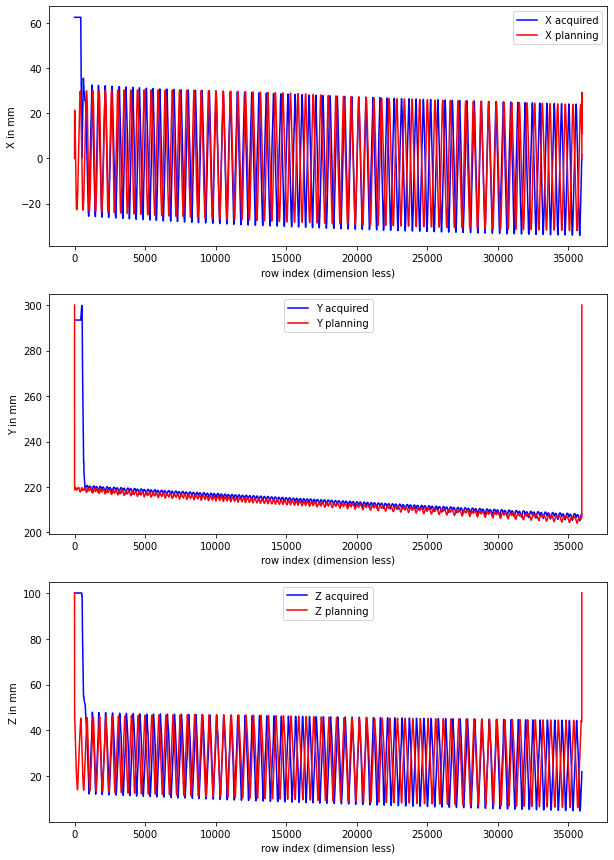

In [18]:
subplotter(0,df_p.shape[0],X,Y,Z,X_inv,Y_inv,Z_inv)

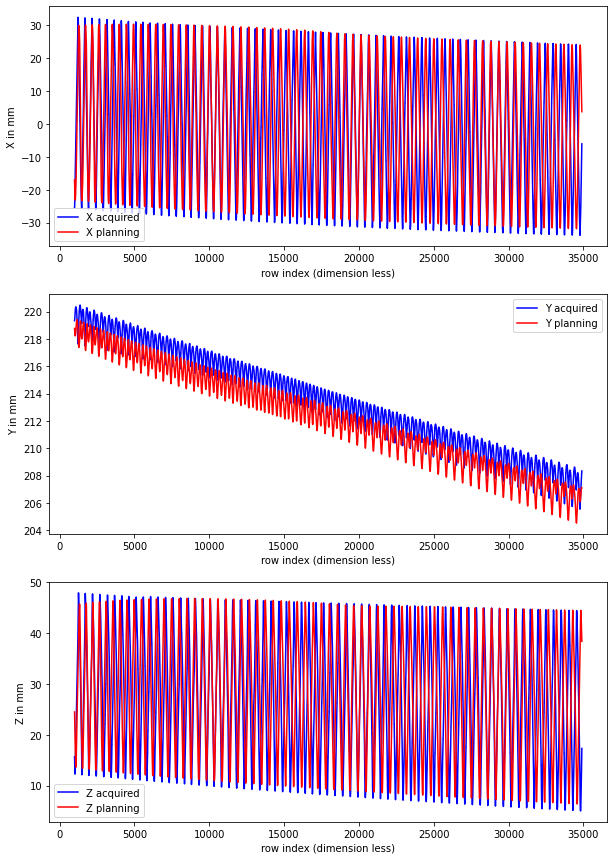

In [19]:
subplotter(1000,34900,X,Y,Z,X_inv,Y_inv,Z_inv)

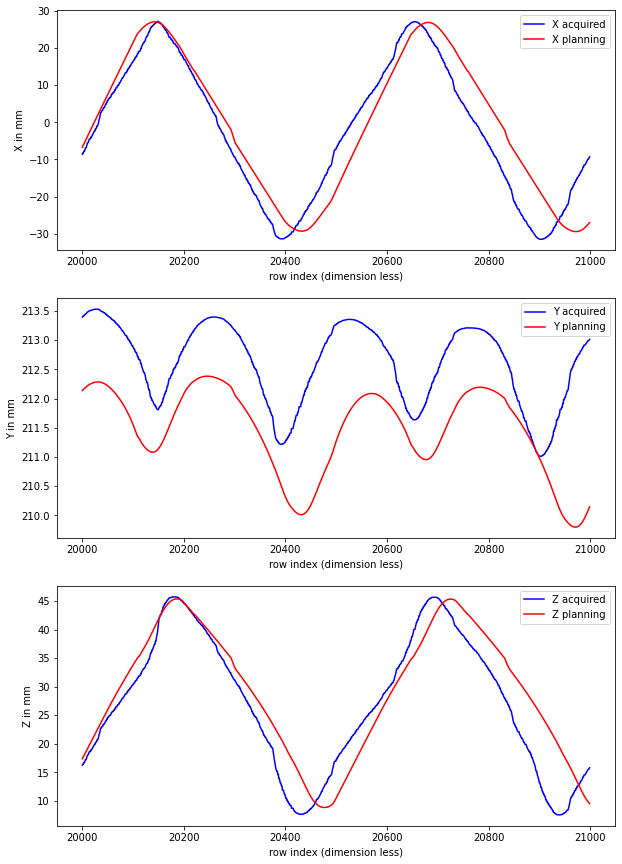

In [20]:
subplotter(20000,21000,X,Y,Z,X_inv,Y_inv,Z_inv)

In [21]:
"""
range1 = np.arange(1000,34900)
X = X[range1]
Y = Y[range1]
Z = Z[range1]

tool_tip_X = tool_tip_X[range1]
tool_tip_Y = tool_tip_Y[range1]
tool_tip_Z = tool_tip_Z[range1]
 
X_inv = tool_tip_X
Y_inv = tool_tip_Y
Z_inv = tool_tip_Z
"""

'\nrange1 = np.arange(1000,34900)\nX = X[range1]\nY = Y[range1]\nZ = Z[range1]\n\ntool_tip_X = tool_tip_X[range1]\ntool_tip_Y = tool_tip_Y[range1]\ntool_tip_Z = tool_tip_Z[range1]\n \nX_inv = tool_tip_X\nY_inv = tool_tip_Y\nZ_inv = tool_tip_Z\n'

### Findingt the closest points
Here the distances are calculated, for each aquired data point, forward transformation was performed above, and now for each of those poits the disace for all planning points are calculated. Partition the data into 5 chuncks and find the closest distance points in those chucks, if we use full set at once, we may match up with far way points, which were causing lots of outliers.the position closest the iterator is considered, since the far away values are thus avoided from matching. store both position and the value in two separate lists

In [22]:
# Here the distances are calculated, for each aquired data point, forward transformation was performed above,
# and now for each of those poits the disace for all planning points are calculated.
lst1 = []
lst2 = []

dist  = np.zeros(len(tool_tip_X))
print('Enter the tolerance number value, example 3 mm')
tol = input()

count = 0 
k = 5

for i in np.arange(len(X)):   # 47917
    
    dist = (((tool_tip_X-X[i])**2+(tool_tip_Y-Y[i])**2+(tool_tip_Z-Z[i])**2)**(1/2))
    
    # partition the data into 5 chuncks and find the closest distance points in those chucks, if we use full set at once, 
    # we may match up with far way points, which were causing lots of outliers
    
    pos = np.argpartition(dist, k)
    pos = pos[:k]
    min_val = dist[pos]
    #print(pos,min_val)
    
    # the position closest the iterator is considered, since the far away values are thus avoided from matching
    pos = pos[np.argmin(abs(pos - i))]
    min_val = dist[pos]
    
    #print(i,pos,min_val)
    # store both position and the value in two separate lists
    if(abs(min_val<=float(tol))): 
        lst1.append(pos)
        lst2.append(min_val)
        count = count+1
        print(i,pos,min_val,count)
    else:
        lst1.append(np.nan)
        lst2.append(np.nan)
   

Enter the tolerance number value, example 3 mm
3
772 2225 2.554517259233814 1
773 1784 2.2330138657364773 2
774 1784 2.2330138657364773 3
775 1786 2.1289326274917735 4
776 1787 2.0850934346190453 5
777 1787 2.0850934346190453 6
778 1788 2.0724039206843163 7
779 1788 2.0724039206843163 8
780 1789 2.0704993834203322 9
781 1789 2.0704993834203322 10
782 8 1.936567801994461 11
783 8 1.936567801994461 12
784 8 1.936567801994461 13
785 8 1.936567801994461 14
786 8 1.936567801994461 15
787 8 1.936567801994461 16
788 8 1.936567801994461 17
789 8 1.936567801994461 18
790 8 1.936567801994461 19
791 8 1.936567801994461 20
792 8 1.936567801994461 21
793 8 1.936567801994461 22
794 8 1.936567801994461 23
795 9 0.9795075250972726 24
796 9 0.7463108123415914 25
797 11 1.2073603475269994 26
798 11 1.2073603475269994 27
799 12 1.423667804059331 28
800 14 1.6771950274604213 29
801 16 1.906976823374594 30
802 17 2.100710018104535 31
803 1356 2.125044400729144 32
804 1356 2.125044400729144 33
805 1357 2.11

1123 1176 1.3714492944790395 352
1124 1177 1.3607653561027708 353
1125 1179 1.3495336584027893 354
1126 1181 1.3379544241953474 355
1127 1181 1.3379544241953474 356
1128 1181 1.3379544241953474 357
1129 1182 1.3288542121099307 358
1130 1184 1.3185304241222042 359
1131 1184 1.3185304241222042 360
1132 1185 1.3128437638882255 361
1133 1187 1.300526121221974 362
1134 1188 1.296250763462563 363
1135 1188 1.296250763462563 364
1136 1190 1.2865673882672315 365
1137 1190 1.2865673882672315 366
1138 1191 1.2822311904325672 367
1139 1192 1.2768972359209558 368
1140 1192 1.2768972359209558 369
1141 1193 1.3153631074810341 370
1142 1193 1.3153631074810341 371
1143 1195 1.3041196504885926 372
1144 1196 1.2923234504523236 373
1145 1196 1.2923234504523236 374
1146 1197 1.2869922045689683 375
1147 1198 1.281929384777372 376
1148 1198 1.281929384777372 377
1149 1201 1.2618442800061311 378
1150 1204 1.2480027742618989 379
1151 1205 1.2432405968853686 380
1152 1208 1.2276910965419618 381
1153 1210 1.220

1485 2841 2.597026986052129 714
1486 2841 2.597026986052129 715
1487 2843 2.519987041770044 716
1488 2400 2.480444826451815 717
1489 2403 2.3041447564355115 718
1490 1963 2.16094739840589 719
1491 1965 2.081814481650867 720
1492 1523 2.009109199028798 721
1493 1525 1.9202940678271219 722
1494 1525 1.9202940678271219 723
1495 1527 1.8482803081641428 724
1496 1527 1.8482803081641428 725
1497 1528 1.8043668012061795 726
1498 1528 1.8043668012061795 727
1499 1531 1.7195982109022194 728
1500 1531 1.7195982109022194 729
1501 1535 1.6401455899544057 730
1502 1535 1.6401455899544057 731
1503 1537 1.611693858395703 732
1504 1539 1.5886218795422036 733
1505 1541 1.5721637046360677 734
1506 1542 1.574481717946933 735
1507 1544 1.5621702555621086 736
1508 1544 1.5621702555621086 737
1509 1545 1.5720179097832028 738
1510 1545 1.5720179097832028 739
1511 1547 1.6083300892088583 740
1512 1547 1.6083300892088583 741
1513 1549 1.6514636922245078 742
1514 1550 1.660089487296654 743
1515 1550 1.660089487

1808 1836 1.881808158088957 1037
1809 1836 1.881808158088957 1038
1810 1836 1.9166381543708488 1039
1811 1837 1.8889496170094013 1040
1812 1838 1.9067073175469733 1041
1813 1840 1.8932267184520526 1042
1814 1842 1.884873593083961 1043
1815 1843 1.8991433679406058 1044
1816 1845 1.8884193271871617 1045
1817 1845 1.8884193271871617 1046
1818 1846 1.865914438713397 1047
1819 1846 1.9064317746758466 1048
1820 1847 1.8749799381560561 1049
1821 1848 1.8598227328097705 1050
1822 1848 1.8598227328097705 1051
1823 1848 1.8935283715631712 1052
1824 1849 1.8634993857224909 1053
1825 1849 1.9151812381171982 1054
1826 1850 1.8769860587579221 1055
1827 1850 1.8769860587579221 1056
1828 1851 1.9002267089322011 1057
1829 1851 1.9002267089322011 1058
1830 1853 1.8468688364951644 1059
1831 1853 1.8468688364951644 1060
1832 1854 1.8521734266929946 1061
1833 1854 1.8521734266929946 1062
1834 1855 1.8405743711863802 1063
1835 1855 1.8405743711863802 1064
1836 1856 1.8411820168078834 1065
1837 1856 1.886336

2149 2147 1.0385869766524871 1378
2150 2147 1.0385869766524871 1379
2151 2148 1.041787755779199 1380
2152 2148 1.041787755779199 1381
2153 2149 1.0409880775389868 1382
2154 2150 1.046674350889884 1383
2155 2152 1.0835761563740223 1384
2156 2152 1.0835761563740223 1385
2157 2155 1.1223338859419143 1386
2158 2157 1.164258343200024 1387
2159 2158 1.1866987530027655 1388
2160 2158 1.1866987530027655 1389
2161 2161 1.335496911441159 1390
2162 2164 1.43944656887733 1391
2163 2170 1.6794011045991528 1392
2164 2172 1.7590020097356287 1393
2165 2176 1.9043784258947187 1394
2166 2178 1.9699201826492156 1395
2167 2178 1.9699201826492156 1396
2168 2179 2.046162627138187 1397
2169 2179 2.046162627138187 1398
2170 2182 2.087920086258888 1399
2171 2183 2.1453270661757453 1400
2172 2183 2.1453270661757453 1401
2173 2185 2.1883839250237194 1402
2174 2185 2.1883839250237194 1403
2175 2187 2.226590873011003 1404
2176 2187 2.226590873011003 1405
2177 2188 2.2664130237459768 1406
2178 2190 2.29117262099481

2483 2450 1.3885772516246149 1712
2484 2450 1.3885772516246149 1713
2485 2452 1.3781502074120622 1714
2486 2452 1.3781502074120622 1715
2487 2453 1.3719188337779995 1716
2488 2454 1.365646109445019 1717
2489 2456 1.3535845195224239 1718
2490 2456 1.3535845195224239 1719
2491 2456 1.3535845195224239 1720
2492 2458 1.3443856471050701 1721
2493 2460 1.3328993096686363 1722
2494 2460 1.3328993096686363 1723
2495 2462 1.3254363662683828 1724
2496 2462 1.3254363662683828 1725
2497 2464 1.31425061094442 1726
2498 2465 1.3086773653486603 1727
2499 2466 1.3030571673399982 1728
2500 2466 1.3030571673399982 1729
2501 2466 1.2949460070433432 1730
2502 2467 1.2890579286888109 1731
2503 2468 1.2832095597383422 1732
2504 2469 1.2777913428544934 1733
2505 2470 1.271819670127948 1734
2506 2471 1.2638359096583116 1735
2507 2472 1.2582049494144152 1736
2508 2033 1.2349968247788348 1737
2509 2477 1.22999591607711 1738
2510 2479 1.2192418756049581 1739
2511 2482 1.2039586732615577 1740
2512 2484 1.19375548

2727 2694 1.6314786348156296 1956
2728 2694 1.6007387829136486 1957
2729 2695 1.6085286025889625 1958
2730 2695 1.6085286025889625 1959
2731 2696 1.6064589895011476 1960
2732 2696 1.6064589895011476 1961
2733 2697 1.6190841688746056 1962
2734 2697 1.6190841688746056 1963
2735 2698 1.614078087552405 1964
2736 2698 1.614078087552405 1965
2737 2699 1.6351992894806395 1966
2738 2699 1.6351992894806395 1967
2739 2700 1.6227747946544107 1968
2740 2701 1.6212333292643406 1969
2741 2703 1.6696229893196264 1970
2742 2704 1.629376416464716 1971
2743 2706 1.6648456811275916 1972
2744 2706 1.6336743234438802 1973
2745 2707 1.6468624022738028 1974
2746 2707 1.6468624022738028 1975
2747 2708 1.6846481257644308 1976
2748 2708 1.6396684814013243 1977
2749 2709 1.6605928186344385 1978
2750 2710 1.7002987799192613 1979
2751 2710 1.7002987799192613 1980
2752 2710 1.6466124518740461 1981
2753 2711 1.677467432473167 1982
2754 2711 1.6436195357979906 1983
2755 2712 1.6575822226518822 1984
2756 2712 1.657582

3064 2523 0.9012218539748218 2293
3065 2524 0.8982250900640169 2294
3066 2524 0.8982250900640169 2295
3067 2525 0.8955617308900783 2296
3068 2526 0.8974246033756513 2297
3069 2527 0.8943381957709454 2298
3070 2528 0.8918578645166929 2299
3071 2529 0.889327820611065 2300
3072 2529 0.889327820611065 2301
3073 2530 0.8872212652885578 2302
3074 2531 0.890870309349583 2303
3075 2532 0.8886550794568032 2304
3076 2533 0.886776355038698 2305
3077 2534 0.884703832571258 2306
3078 2534 0.884703832571258 2307
3079 2536 0.8889813211241239 2308
3080 2537 0.8876116650466334 2309
3081 2538 0.8868749625895433 2310
3082 2538 0.8868749625895433 2311
3083 2539 0.853320352459144 2312
3084 2539 0.853320352459144 2313
3085 2539 0.853320352459144 2314
3086 2541 0.8464583916611917 2315
3087 2541 0.8464583916611917 2316
3088 2542 0.8443571095274981 2317
3089 2543 0.8416699510103619 2318
3090 2543 0.8416699510103619 2319
3091 2544 0.8397887696595293 2320
3092 2545 0.8382190591880082 2321
3093 2546 0.83631688377

3412 3743 2.4086736819933767 2641
3413 4217 2.46884863617487 2642
3414 4217 2.46884863617487 2643
3415 4219 2.5169944386873158 2644
3416 4219 2.5169944386873158 2645
3417 4219 2.5169944386873158 2646
3418 4223 2.6126363416696408 2647
3419 4223 2.6126363416696408 2648
3420 4704 2.637741419092758 2649
3421 4704 2.637741419092758 2650
3422 4705 2.6750796950902336 2651
3423 4705 2.6750796950902336 2652
3424 4707 2.685076146236864 2653
3425 4709 2.694486264280264 2654
3426 4710 2.7020587358602794 2655
3427 4710 2.7020587358602794 2656
3428 4711 2.702046431899259 2657
3429 4711 2.702046431899259 2658
3430 4713 2.6860062331771877 2659
3431 4713 2.6812471641122677 2660
3432 4715 2.6418862187129006 2661
3433 4715 2.6418862187129006 2662
3434 4716 2.612144228526287 2663
3435 4716 2.612144228526287 2664
3436 4717 2.579120521083938 2665
3437 4238 2.535745888761075 2666
3438 4238 2.535745888761075 2667
3439 4239 2.4826525042303986 2668
3440 4239 2.4826525042303986 2669
3441 4240 2.4309947570707022 

3736 3159 1.436236285577043 2965
3737 3159 1.4215008038437802 2966
3738 3159 1.4215008038437802 2967
3739 3161 1.4518890005675509 2968
3740 3161 1.4518890005675509 2969
3741 3162 1.4316236437809167 2970
3742 3623 1.4828413387957897 2971
3743 3163 1.4248578116112178 2972
3744 3163 1.4248578116112178 2973
3745 3164 1.4259727211978008 2974
3746 3165 1.428504489927148 2975
3747 3166 1.4526297389461653 2976
3748 3166 1.4253809728101206 2977
3749 3167 1.4361018134194106 2978
3750 3628 1.4859386977941662 2979
3751 3168 1.426608766250365 2980
3752 3168 1.426608766250365 2981
3753 3169 1.4421844545033728 2982
3754 3169 1.4283712133170767 2983
3755 3170 1.4303253433846497 2984
3756 3170 1.4303253433846497 2985
3757 3171 1.4533615579944434 2986
3758 3171 1.4533615579944434 2987
3759 3171 1.426945755124178 2988
3760 3172 1.433461085340086 2989
3761 3173 1.4668139119976837 2990
3762 3173 1.4668139119976837 2991
3763 3173 1.4263432162697025 2992
3764 3173 1.4263432162697025 2993
3765 3174 1.44024473

4065 3002 0.6844491142199591 3294
4066 3003 0.6873309980992215 3295
4067 3003 0.6873309980992215 3296
4068 3005 0.6942993869351234 3297
4069 3005 0.6942993869351234 3298
4070 3005 0.6422174618977429 3299
4071 3005 0.6422174618977429 3300
4072 3007 0.6402089714858541 3301
4073 3009 0.6395777186394221 3302
4074 3009 0.6395777186394221 3303
4075 3010 0.6403153695958728 3304
4076 3011 0.6429859020680759 3305
4077 3012 0.6444421709295626 3306
4078 3014 0.6492473991913594 3307
4079 3014 0.6492473991913594 3308
4080 3014 0.6492473991913594 3309
4081 3015 0.652497151541113 3310
4082 3017 0.6645445622402854 3311
4083 3018 0.6692683098811153 3312
4084 3019 0.6749121378275011 3313
4085 3019 0.6749121378275011 3314
4086 3020 0.6809252518013149 3315
4087 3020 0.6470087627013779 3316
4088 3021 0.646909995200942 3317
4089 3022 0.6469508333453658 3318
4090 3024 0.6491588191041417 3319
4091 3024 0.6491588191041417 3320
4092 3025 0.6514319396996819 3321
4093 3027 0.6573150873196411 3322
4094 3027 0.6573

4399 4256 1.769756559932809 3628
4400 4256 1.769756559932809 3629
4401 4256 1.769756559932809 3630
4402 3784 1.6393546335885132 3631
4403 3784 1.6393546335885132 3632
4404 3786 1.52225327126049 3633
4405 3786 1.52225327126049 3634
4406 3787 1.4683311977434308 3635
4407 3787 1.4683311977434308 3636
4408 3322 1.3009958158875936 3637
4409 3322 1.3009958158875936 3638
4410 3324 1.256678306141486 3639
4411 3325 1.206803312114048 3640
4412 3328 1.1309093907567491 3641
4413 2877 1.0933400401749118 3642
4414 3331 1.085803867928234 3643
4415 3331 1.085803867928234 3644
4416 3333 1.0598132282086017 3645
4417 3334 1.0552135121224908 3646
4418 3334 1.0552135121224908 3647
4419 3336 1.0550798549150406 3648
4420 3336 1.0550798549150406 3649
4421 3337 1.053004834570249 3650
4422 3337 1.053004834570249 3651
4423 3338 1.046605558482497 3652
4424 3339 1.0397636837137496 3653
4425 3340 1.0329928659008745 3654
4426 3340 1.0329928659008745 3655
4427 3342 1.024004527178674 3656
4428 3342 1.024004527178674 3

4716 3638 1.2380075596276106 3945
4717 3639 1.21360881087071 3946
4718 3640 1.241348372246388 3947
4719 3640 1.241348372246388 3948
4720 4113 1.2817139005574647 3949
4721 4113 1.2817139005574647 3950
4722 3642 1.2529631310833629 3951
4723 4115 1.2846003034003612 3952
4724 4115 1.2846003034003612 3953
4725 3643 1.2197404920356096 3954
4726 3644 1.2061007749924606 3955
4727 3644 1.2061007749924606 3956
4728 3646 1.205618768155674 3957
4729 3646 1.2181396538331295 3958
4730 4120 1.2815181086325678 3959
4731 3648 1.2084559129399293 3960
4732 3648 1.2132141574979476 3961
4733 3649 1.1990725549407684 3962
4734 3650 1.204509240498967 3963
4735 3650 1.204509240498967 3964
4736 3651 1.1974638198594636 3965
4737 3652 1.2141179002222562 3966
4738 3652 1.2004391665692742 3967
4739 3653 1.1979242403239534 3968
4740 3654 1.1942116960213038 3969
4741 3655 1.1970374675692221 3970
4742 3656 1.19022492287682 3971
4743 3657 1.2002243253458709 3972
4744 3657 1.2002243253458709 3973
4745 3657 1.19898952807

5060 3484 0.5377872586770968 4289
5061 3484 0.5377872586770968 4290
5062 3485 0.5409483008449192 4291
5063 3485 0.5409483008449192 4292
5064 3487 0.5419573463331374 4293
5065 3489 0.5294583849085703 4294
5066 3491 0.5245066044939732 4295
5067 3491 0.5245066044939732 4296
5068 3491 0.5245066044939732 4297
5069 3041 0.4707501032104259 4298
5070 3041 0.4707501032104259 4299
5071 3044 0.45314966384212774 4300
5072 3044 0.45314966384212774 4301
5073 3047 0.4471692949384904 4302
5074 3047 0.4471692949384904 4303
5075 3049 0.4803802302469399 4304
5076 3050 0.4599362908221492 4305
5077 3052 0.4937749247591087 4306
5078 3054 0.5061943763254647 4307
5079 3054 0.5061943763254647 4308
5080 3057 0.5770604545857266 4309
5081 3059 0.6001858014182466 4310
5082 3059 0.6001858014182466 4311
5083 3061 0.6338131289322168 4312
5084 3061 0.6338131289322168 4313
5085 3063 0.6750122315959177 4314
5086 3063 0.6750122315959177 4315
5087 3068 0.8122786996200536 4316
5088 3068 0.8122786996200536 4317
5089 3070 0.

5394 3809 0.8209295799513625 4623
5395 3810 0.8142260893468035 4624
5396 3810 0.8142260893468035 4625
5397 3812 0.8062897921334972 4626
5398 3813 0.7998737155006971 4627
5399 3814 0.7938683591001728 4628
5400 3815 0.7873656661660312 4629
5401 3816 0.7814042324939318 4630
5402 3817 0.7817876110093231 4631
5403 3818 0.775459998504357 4632
5404 3818 0.775459998504357 4633
5405 3819 0.7693800878952352 4634
5406 3819 0.7693800878952352 4635
5407 3821 0.7572555471809173 4636
5408 3821 0.7572555471809173 4637
5409 3823 0.7537764891838886 4638
5410 3824 0.7477351275215891 4639
5411 3824 0.7477351275215891 4640
5412 3826 0.7362724826054496 4641
5413 3826 0.7362724826054496 4642
5414 3827 0.7401286749039484 4643
5415 3828 0.7347219481295563 4644
5416 3829 0.7289707727180686 4645
5417 3829 0.7289707727180686 4646
5418 3831 0.7176642683674684 4647
5419 3831 0.7176642683674684 4648
5420 3832 0.7233992614487701 4649
5421 3833 0.7180919128266023 4650
5422 3834 0.7124209027317772 4651
5423 3835 0.7072

5638 4081 1.060778278065885 4867
5639 4082 1.0476795764508795 4868
5640 4082 1.0476795764508795 4869
5641 4084 1.0342763289300878 4870
5642 4086 1.0630986553061563 4871
5643 4086 1.0630986553061563 4872
5644 4087 1.0488597279046796 4873
5645 4089 1.0338148896300938 4874
5646 4091 1.0647133644141487 4875
5647 4092 1.0494057536652641 4876
5648 4092 1.0494057536652641 4877
5649 4093 1.0381424528475895 4878
5650 4567 1.091375361169789 4879
5651 4095 1.0651722558936074 4880
5652 4095 1.0651722558936074 4881
5653 4571 1.0876435909067568 4882
5654 4571 1.0876435909067568 4883
5655 4097 1.0776463737631665 4884
5656 4573 1.0900170669191604 4885
5657 4573 1.0900170669191604 4886
5658 4576 1.0837154121246058 4887
5659 4577 1.1035611060626007 4888
5660 4577 1.1035611060626007 4889
5661 4100 1.055784840610332 4890
5662 4100 1.055784840610332 4891
5663 4578 1.0831504181371985 4892
5664 4578 1.0987617743424518 4893
5665 4578 1.0987617743424518 4894
5666 4102 1.0723970125050504 4895
5667 4580 1.087527

5979 4388 0.4290765583767558 5208
5980 4390 0.4317208462294066 5209
5981 4392 0.4395213878622926 5210
5982 4393 0.4434417627919782 5211
5983 4393 0.4434417627919782 5212
5984 4394 0.44775841823031465 5213
5985 4395 0.4530263437461207 5214
5986 4397 0.47193851637645257 5215
5987 4397 0.47193851637645257 5216
5988 4397 0.4653950359072781 5217
5989 4397 0.4653950359072781 5218
5990 4398 0.46377416878869376 5219
5991 4398 0.46377416878869376 5220
5992 4399 0.4627428013434982 5221
5993 4400 0.45943804416115513 5222
5994 4401 0.46069132148947184 5223
5995 4401 0.46069132148947184 5224
5996 4402 0.46241613258602593 5225
5997 4403 0.46535568420506795 5226
5998 4403 0.46535568420506795 5227
5999 4403 0.46535568420506795 5228
6000 4405 0.4737313318518453 5229
6001 4406 0.48008146839770005 5230
6002 4407 0.4866890977521163 5231
6003 4407 0.4866890977521163 5232
6004 4408 0.4945747446858034 5233
6005 3936 0.448011794229746 5234
6006 3939 0.49307165418643156 5235
6007 4414 0.5302831690645305 5236
6

6329 6217 2.0451884231254724 5558
6330 6219 1.9626421857847551 5559
6331 6220 1.8687468276935502 5560
6332 6221 1.816009086103221 5561
6333 5723 1.7488156980060299 5562
6334 5725 1.6160043552615473 5563
6335 5726 1.561440929425636 5564
6336 5726 1.561440929425636 5565
6337 5728 1.5046812753557977 5566
6338 5233 1.4072105617112418 5567
6339 5234 1.3519469753234163 5568
6340 5234 1.300565236834451 5569
6341 5235 1.2423779519670504 5570
6342 4745 1.1732940699182783 5571
6343 4745 1.0718152647961943 5572
6344 4745 1.0718152647961943 5573
6345 4267 0.9921364645490743 5574
6346 4267 0.9921364645490743 5575
6347 4268 0.9185658419252037 5576
6348 4270 0.8926683722610765 5577
6349 4271 0.8333924692718816 5578
6350 4272 0.8061875120533895 5579
6351 4273 0.752197535132303 5580
6352 4273 0.752197535132303 5581
6353 4275 0.7178493633062694 5582
6354 4275 0.7178493633062694 5583
6355 4275 0.7178493633062694 5584
6356 4278 0.7101265805412661 5585
6357 4280 0.6964370886122514 5586
6358 4283 0.69105685

6655 5062 0.8981928460667955 5884
6656 5063 0.8827218949060555 5885
6657 5063 0.8827218949060555 5886
6658 5064 0.8850805218140687 5887
6659 5064 0.8850805218140687 5888
6660 5065 0.8805429549353616 5889
6661 5065 0.8805429549353616 5890
6662 5066 0.8764674459534294 5891
6663 5066 0.8764674459534294 5892
6664 5067 0.8835743911571138 5893
6665 5067 0.8935794204317037 5894
6666 5068 0.8724083546213643 5895
6667 5069 0.8842349324229414 5896
6668 5069 0.8842349324229414 5897
6669 5069 0.8812158768825195 5898
6670 5070 0.8706470949229796 5899
6671 5070 0.8706470949229796 5900
6672 5071 0.8925997504689426 5901
6673 5071 0.8925997504689426 5902
6674 5071 0.8769932866759467 5903
6675 5071 0.8769932866759467 5904
6676 5071 0.8769932866759467 5905
6677 5072 0.8701905096304721 5906
6678 5072 0.9009933901848611 5907
6679 4593 0.8539597216104408 5908
6680 4593 0.8539597216104408 5909
6681 5074 0.8978995001739458 5910
6682 5074 0.8978995001739458 5911
6683 5074 0.8978995001739458 5912
6684 4595 0.85

6995 4872 0.3062465561534534 6224
6996 4874 0.3254351099743437 6225
6997 4874 0.3254351099743437 6226
6998 4875 0.33323456276442603 6227
6999 4875 0.33323456276442603 6228
7000 4876 0.34135499863199437 6229
7001 4878 0.3696110205026009 6230
7002 4878 0.3696110205026009 6231
7003 4879 0.3798963338309135 6232
7004 4879 0.3798963338309135 6233
7005 4881 0.40195168387421515 6234
7006 4881 0.40195168387421515 6235
7007 4882 0.41404427660068316 6236
7008 4882 0.41404427660068316 6237
7009 4884 0.3315500151592247 6238
7010 4884 0.3315500151592247 6239
7011 4885 0.3358968778288036 6240
7012 4886 0.3409241677700355 6241
7013 4887 0.34910032132127095 6242
7014 4888 0.3564978488695362 6243
7015 4888 0.3564978488695362 6244
7016 4890 0.37319783070662405 6245
7017 4890 0.37319783070662405 6246
7018 4891 0.3826980590045237 6247
7019 4891 0.3826980590045237 6248
7020 4892 0.3993334685249203 6249
7021 4893 0.41023641353721874 6250
7022 4895 0.43384799380739325 6251
7023 4895 0.43384799380739325 6252
7

7338 6229 1.404927001488333 6567
7339 6230 1.3459113158567486 6568
7340 6231 1.288908683923316 6569
7341 5731 1.1935890787721959 6570
7342 5732 1.1433520400265569 6571
7343 5733 1.0974972667388427 6572
7344 5733 1.0974972667388427 6573
7345 5733 1.0974972667388427 6574
7346 5238 0.9157277651626949 6575
7347 5238 0.9157277651626949 6576
7348 5240 0.7749816941243295 6577
7349 5240 0.7749816941243295 6578
7350 5241 0.7296466909856781 6579
7351 5243 0.7168653859547892 6580
7352 5243 0.65909947623905 6581
7353 5243 0.65909947623905 6582
7354 5244 0.6313495820472925 6583
7355 5244 0.6313495820472925 6584
7356 5246 0.593248157797298 6585
7357 5246 0.593248157797298 6586
7358 5248 0.5795930990623602 6587
7359 5248 0.5795930990623602 6588
7360 5249 0.5735693962978704 6589
7361 5249 0.5735693962978704 6590
7362 5251 0.5619879576803585 6591
7363 5251 0.5619879576803585 6592
7364 5252 0.5559569438496214 6593
7365 5253 0.550149925401843 6594
7366 5254 0.5443689538431783 6595
7367 5255 0.53883079806

7673 5572 0.6760101887386466 6902
7674 5573 0.6918714348351558 6903
7675 5573 0.689380677093591 6904
7676 5575 0.7017619090802892 6905
7677 5575 0.6861327543051343 6906
7678 5575 0.6861327543051343 6907
7679 5576 0.6747325807618593 6908
7680 5577 0.7146931137752844 6909
7681 5577 0.678111017071251 6910
7682 5578 0.677823087284521 6911
7683 5578 0.677823087284521 6912
7684 5579 0.6759918354222383 6913
7685 5579 0.6759918354222383 6914
7686 5580 0.6988491606098473 6915
7687 5580 0.6988491606098473 6916
7688 5581 0.6717001742524834 6917
7689 5582 0.6854956539930068 6918
7690 5582 0.6953113088644135 6919
7691 5582 0.6953113088644135 6920
7692 5583 0.6709835278682521 6921
7693 5584 0.696052158293762 6922
7694 5584 0.6841318790416525 6923
7695 5585 0.6712511535245987 6924
7696 5586 0.6991050900239253 6925
7697 5586 0.6763521490979978 6926
7698 5587 0.6749741759810297 6927
7699 5587 0.6749741759810297 6928
7700 5588 0.6746843537947175 6929
7701 5588 0.6746843537947175 6930
7702 5589 0.6768470

7970 5840 0.2565339161316791 7199
7971 5840 0.2565339161316791 7200
7972 5840 0.2565339161316791 7201
7973 5841 0.25767677505202025 7202
7974 5842 0.2588169493685203 7203
7975 5843 0.2605601283160096 7204
7976 5843 0.2605601283160096 7205
7977 5844 0.2692338752733722 7206
7978 5845 0.2721820077593471 7207
7979 5845 0.2721820077593471 7208
7980 5847 0.2796141323443749 7209
7981 5847 0.2796141323443749 7210
7982 5848 0.2841003742536976 7211
7983 5849 0.29991484107299665 7212
7984 5850 0.30567068359512484 7213
7985 5851 0.31201179478756247 7214
7986 5852 0.31914897309302387 7215
7987 5853 0.3269185648852913 7216
7988 5853 0.3269185648852913 7217
7989 5854 0.34890768799401084 7218
7990 5855 0.3580803528477065 7219
7991 5855 0.294611981538054 7220
7992 5855 0.294611981538054 7221
7993 5856 0.29433396698419345 7222
7994 5856 0.29433396698419345 7223
7995 5857 0.294969796132456 7224
7996 5857 0.294969796132456 7225
7997 5858 0.29331118233534625 7226
7998 5859 0.2958666109669931 7227
7999 5859

8289 6670 1.3713559661665946 7518
8290 6672 1.4642996242018742 7519
8291 6673 1.525779059144593 7520
8292 7182 1.6145137100028912 7521
8293 7184 1.6895150274158257 7522
8294 7185 1.745741189738727 7523
8295 7185 1.745741189738727 7524
8296 7697 1.8186127810056425 7525
8297 7699 1.8840300838131523 7526
8298 8214 2.022516883042593 7527
8299 8216 2.095237960470005 7528
8300 8218 2.1786515465994505 7529
8301 8219 2.245976261219911 7530
8302 8219 2.245976261219911 7531
8303 8221 2.3308995552411984 7532
8304 8221 2.3308995552411984 7533
8305 8222 2.402783309187884 7534
8306 8222 2.402783309187884 7535
8307 8737 2.5127539018599934 7536
8308 8737 2.5127539018599934 7537
8309 8738 2.5740585024088527 7538
8310 8738 2.5740585024088527 7539
8311 9255 2.607559425940516 7540
8312 9255 2.607559425940516 7541
8313 9256 2.653878516224756 7542
8314 9258 2.675321669310799 7543
8315 9259 2.704895633339296 7544
8316 9259 2.704895633339296 7545
8317 9261 2.714690965217129 7546
8318 9261 2.714690965217129 75

8623 6007 0.663922152466076 7852
8624 6007 0.663922152466076 7853
8625 6010 0.6753394626084962 7854
8626 6010 0.6753394626084962 7855
8627 6011 0.6627945204214811 7856
8628 6013 0.708957573857289 7857
8629 6014 0.6927180967512127 7858
8630 6016 0.6566975180143844 7859
8631 6016 0.6566975180143844 7860
8632 6019 0.6821982725010888 7861
8633 6019 0.6821982725010888 7862
8634 6020 0.667161283477307 7863
8635 6020 0.667161283477307 7864
8636 6522 0.7012507116444396 7865
8637 6024 0.6770109817760053 7866
8638 6525 0.6948191722747052 7867
8639 6026 0.6399998412845529 7868
8640 6527 0.6857545358605428 7869
8641 6029 0.6700568575466306 7870
8642 6030 0.6444701348565407 7871
8643 6030 0.6444701348565407 7872
8644 6031 0.6237569837375895 7873
8645 6031 0.6237569837375895 7874
8646 6034 0.6615792700657919 7875
8647 6034 0.6615792700657919 7876
8648 6035 0.633715471578538 7877
8649 6035 0.633715471578538 7878
8650 6036 0.6116045857536906 7879
8651 6537 0.6566728096572205 7880
8652 6039 0.651756220

8958 6848 0.2801658015995551 8187
8959 6848 0.2801658015995551 8188
8960 6850 0.2792429032951217 8189
8961 6851 0.2753321192043866 8190
8962 6852 0.2767587673234995 8191
8963 6852 0.2767587673234995 8192
8964 6853 0.2785235402910188 8193
8965 6854 0.2809521200629905 8194
8966 6854 0.2809521200629905 8195
8967 6855 0.28393723993235886 8196
8968 6856 0.29051636026008554 8197
8969 6856 0.29051636026008554 8198
8970 6857 0.295851071649098 8199
8971 6857 0.295851071649098 8200
8972 6858 0.30159693487646605 8201
8973 6859 0.30810123246793886 8202
8974 6859 0.30810123246793886 8203
8975 6859 0.30810123246793886 8204
8976 6861 0.3313793886879317 8205
8977 6861 0.3313793886879317 8206
8978 6861 0.3313793886879317 8207
8979 6863 0.3501473188621159 8208
8980 6863 0.3501473188621159 8209
8981 6863 0.3483339297001951 8210
8982 6863 0.3483339297001951 8211
8983 6864 0.34637187969353755 8212
8984 6865 0.3381712024989605 8213
8985 6866 0.33847287527387787 8214
8986 6867 0.3396431154699788 8215
8987 68

9283 9249 2.2802782594689672 8512
9284 9249 2.2802782594689672 8513
9285 9250 2.3524915308437895 8514
9286 9252 2.4317740107000123 8515
9287 9252 2.4317740107000123 8516
9288 9773 2.4773154101792176 8517
9289 9773 2.4773154101792176 8518
9290 9774 2.5420317585771928 8519
9291 9774 2.5420317585771928 8520
9292 9778 2.6368377892238346 8521
9293 9778 2.6368377892238346 8522
9294 10302 2.6618312918946607 8523
9295 10302 2.6618312918946607 8524
9296 10304 2.683516035750785 8525
9297 10304 2.683516035750785 8526
9298 10304 2.683516035750785 8527
9299 10305 2.7079938372188446 8528
9300 10306 2.7251761253257523 8529
9301 10306 2.7251761253257523 8530
9302 10308 2.7225083030144126 8531
9303 10308 2.7225083030144126 8532
9304 10308 2.7225083030144126 8533
9305 10309 2.7202332016216166 8534
9306 10309 2.7202332016216166 8535
9307 10311 2.6955025391372955 8536
9308 10311 2.6955025391372955 8537
9309 10312 2.674042383893471 8538
9310 10312 2.674042383893471 8539
9311 10315 2.589527108318112 8540
93

9619 7019 0.5795979528449023 8848
9620 7020 0.565378754634951 8849
9621 7021 0.5579704478697434 8850
9622 7023 0.5912339059047957 8851
9623 7023 0.5912339059047957 8852
9624 7025 0.5588958877048116 8853
9625 7025 0.5588958877048116 8854
9626 7028 0.5879937622989293 8855
9627 7028 0.5879937622989293 8856
9628 7029 0.5641753575116126 8857
9629 7030 0.5509001150507715 8858
9630 7031 0.5375598470464359 8859
9631 7033 0.5830753324863552 8860
9632 7035 0.5358632726593876 8861
9633 7037 0.5169885635357432 8862
9634 7040 0.524061868497322 8863
9635 7044 0.5356604075608578 8864
9636 7045 0.5112221888692515 8865
9637 7048 0.5439040192728202 8866
9638 7048 0.5439040192728202 8867
9639 7049 0.523111986627372 8868
9640 7049 0.523111986627372 8869
9641 7050 0.4973220837231907 8870
9642 7050 0.4973220837231907 8871
9643 7053 0.5305541545016403 8872
9644 7053 0.5305541545016403 8873
9645 7054 0.49912081145291004 8874
9646 7055 0.48278181814526216 8875
9647 7055 0.48278181814526216 8876
9648 7058 0.515

9953 7864 0.28808759262786054 9182
9954 7865 0.2881969934052452 9183
9955 7865 0.2881969934052452 9184
9956 7866 0.2890531559141508 9185
9957 7866 0.2890531559141508 9186
9958 7867 0.29469305850007066 9187
9959 7868 0.29693469555833446 9188
9960 7869 0.30017694750448165 9189
9961 7869 0.30017694750448165 9190
9962 7870 0.303527816859117 9191
9963 7870 0.303527816859117 9192
9964 7872 0.3219796064787366 9193
9965 7873 0.32810358017994967 9194
9966 7873 0.32810358017994967 9195
9967 7873 0.32810358017994967 9196
9968 7875 0.3419541087342545 9197
9969 7875 0.3421579972263095 9198
9970 7877 0.32881067013946896 9199
9971 7879 0.32822918567537646 9200
9972 7369 0.18736039386721137 9201
9973 7370 0.1972434480995965 9202
9974 7370 0.1972434480995965 9203
9975 7370 0.1972434480995965 9204
9976 7371 0.2079305288197972 9205
9977 7372 0.2195468799147811 9206
9978 7373 0.23132995272770543 9207
9979 7373 0.23132995272770543 9208
9980 7375 0.26972840291180467 9209
9981 7375 0.26972840291180467 9210
9

10284 10295 2.3987249107884767 9513
10285 10295 2.3987249107884767 9514
10286 10295 2.3987249107884767 9515
10287 10821 2.512127227872643 9516
10288 10821 2.512127227872643 9517
10289 10821 2.512127227872643 9518
10290 10824 2.615321332909246 9519
10291 10824 2.615321332909246 9520
10292 10824 2.615321332909246 9521
10293 10826 2.6590605619705188 9522
10294 10826 2.6590605619705188 9523
10295 11349 2.679507988370714 9524
10296 11349 2.679507988370714 9525
10297 11350 2.70951745458563 9526
10298 11350 2.70951745458563 9527
10299 11353 2.7264158796512987 9528
10300 11353 2.7264158796512987 9529
10301 11354 2.7312898698366195 9530
10302 11354 2.7312898698366195 9531
10303 11355 2.7291184267579482 9532
10304 11357 2.6971981581511346 9533
10305 11357 2.6971981581511346 9534
10306 11358 2.677013716728946 9535
10307 11358 2.677013716728946 9536
10308 10838 2.6130447999125592 9537
10309 10838 2.6130447999125592 9538
10310 10839 2.566379974021542 9539
10311 10839 2.566379974021542 9540
10312 10

10571 7489 0.23033207778666975 9800
10572 7491 0.27095171859529193 9801
10573 7491 0.27095171859529193 9802
10574 7492 0.22997956001155245 9803
10575 7493 0.21665570290516203 9804
10576 7495 0.3283004879028664 9805
10577 7496 0.34147004178593304 9806
10578 7497 0.3666573108401421 9807
10579 7497 0.3666573108401421 9808
10580 7498 0.36289892158533976 9809
10581 7498 0.36289892158533976 9810
10582 7499 0.37725223771041094 9811
10583 7499 0.37725223771041094 9812
10584 7501 0.4399764356866008 9813
10585 7501 0.4399764356866008 9814
10586 8013 0.5003124358786938 9815
10587 8013 0.5003124358786938 9816
10588 8016 0.5096870276202277 9817
10589 8016 0.5096870276202277 9818
10590 8017 0.508104918876259 9819
10591 8017 0.508104918876259 9820
10592 8019 0.5193663591812403 9821
10593 8019 0.5193663591812403 9822
10594 7510 0.49470247045920845 9823
10595 7510 0.49470247045920845 9824
10596 8022 0.5122440709081524 9825
10597 8023 0.5117696515278003 9826
10598 8024 0.516560337792348 9827
10599 8024 

10876 7789 0.2404295291636339 10105
10877 7790 0.24072920712415719 10106
10878 7790 0.24072920712415719 10107
10879 7792 0.27428695986837576 10108
10880 7794 0.27500834489906084 10109
10881 7795 0.2755766140359066 10110
10882 7796 0.31098943436083115 10111
10883 7797 0.31108692606780747 10112
10884 7798 0.3114562654046452 10113
10885 7798 0.3114562654046452 10114
10886 7800 0.3118682339225436 10115
10887 7800 0.11388128953275994 10116
10888 7800 0.11388128953275994 10117
10889 7802 0.10979099232581258 10118
10890 8316 0.3397985764602974 10119
10891 8316 0.3397985764602974 10120
10892 8317 0.3367358697251018 10121
10893 7805 0.11277959859655938 10122
10894 7806 0.11099701050497986 10123
10895 8320 0.31126054832192984 10124
10896 8321 0.3079930961750409 10125
10897 8322 0.3048834030339179 10126
10898 8322 0.3048834030339179 10127
10899 8323 0.29031202250419447 10128
10900 8324 0.28705943752278035 10129
10901 8325 0.2838655939180244 10130
10902 8326 0.2806904931733542 10131
10903 8329 0.2

11120 8565 0.46118760148295856 10349
11121 8566 0.45206909795071465 10350
11122 8567 0.4518038983684156 10351
11123 8567 0.4518038983684156 10352
11124 8057 0.45810897018456115 10353
11125 8057 0.45810897018456115 10354
11126 8571 0.4397314528374879 10355
11127 8571 0.4397314528374879 10356
11128 8573 0.44371780243471354 10357
11129 8573 0.44371780243471354 10358
11130 8575 0.43562261240850414 10359
11131 8575 0.43562261240850414 10360
11132 8576 0.4249181001325216 10361
11133 8577 0.4219921424514263 10362
11134 8578 0.42702005565926454 10363
11135 8581 0.41026725393141183 10364
11136 8585 0.4097366575754456 10365
11137 8588 0.4022082245651978 10366
11138 8591 0.3817307873414961 10367
11139 8592 0.37964625784849804 10368
11140 8082 0.38470785755579634 10369
11141 8595 0.3768571466512198 10370
11142 8595 0.3768571466512198 10371
11143 8596 0.3695469936426945 10372
11144 8597 0.36943744115772115 10373
11145 8087 0.3640384734759104 10374
11146 8600 0.36541644058282485 10375
11147 8600 0.3

11345 8790 0.6504213504389982 10574
11346 8791 0.59108220175752 10575
11347 8792 0.5427538450979881 10576
11348 8792 0.5427538450979881 10577
11349 8280 0.3617046584664004 10578
11350 8280 0.3617046584664004 10579
11351 8282 0.3207493776149054 10580
11352 8282 0.3207493776149054 10581
11353 8283 0.3080462045699801 10582
11354 8284 0.30430117269039386 10583
11355 8284 0.30430117269039386 10584
11356 8285 0.304521426941652 10585
11357 8286 0.3367529845316365 10586
11358 8288 0.34013864693002743 10587
11359 8288 0.34013864693002743 10588
11360 8289 0.3419513570234241 10589
11361 8290 0.1841194658641526 10590
11362 8290 0.1841194658641526 10591
11363 8291 0.18170702302465747 10592
11364 8292 0.17955926295147853 10593
11365 8293 0.17748852315950786 10594
11366 8296 0.18163900066163363 10595
11367 8298 0.18020929469128946 10596
11368 8300 0.19842992193748502 10597
11369 8303 0.19890515440789502 10598
11370 8305 0.22582167187935603 10599
11371 8306 0.2262159125122921 10600
11372 8308 0.227316

11676 9129 0.36602424432207264 10905
11677 9130 0.38553541018005605 10906
11678 9131 0.370122788984332 10907
11679 8618 0.209025148289052 10908
11680 9132 0.4059981465618896 10909
11681 9133 0.37759348211028276 10910
11682 9134 0.3977596110391403 10911
11683 9135 0.3893185540107424 10912
11684 9135 0.3893185540107424 10913
11685 9136 0.40227779944118214 10914
11686 9136 0.40227779944118214 10915
11687 9136 0.40227779944118214 10916
11688 8624 0.24827732534446062 10917
11689 8625 0.3622466401837544 10918
11690 8625 0.2217365927464465 10919
11691 8625 0.2217365927464465 10920
11692 8627 0.374578338305032 10921
11693 8627 0.22441451247198396 10922
11694 8628 0.28943069293556284 10923
11695 8628 0.28943069293556284 10924
11696 8629 0.23121765226558993 10925
11697 8629 0.23121765226558993 10926
11698 8630 0.3021759789721142 10927
11699 8631 0.27882133476834714 10928
11700 8631 0.2923414473645176 10929
11701 8631 0.2923414473645176 10930
11702 8634 0.29214341888826956 10931
11703 8634 0.2921

12008 9441 0.32673493888357014 11237
12009 9442 0.3373166205505673 11238
12010 9443 0.3484583704860604 11239
12011 9445 0.37196294032758487 11240
12012 9445 0.37196294032758487 11241
12013 9445 0.34685838413861503 11242
12014 9446 0.3463550271107206 11243
12015 9447 0.3464593384439959 11244
12016 9448 0.3474611100465771 11245
12017 9449 0.3491059786697176 11246
12018 9449 0.3491059786697176 11247
12019 9451 0.3547787888228581 11248
12020 9451 0.3547787888228581 11249
12021 9453 0.36481344346581007 11250
12022 9454 0.3705849607898021 11251
12023 8938 0.3101509347518919 11252
12024 8938 0.3101509347518919 11253
12025 8940 0.3319307920407524 11254
12026 8940 0.3319307920407524 11255
12027 8941 0.3427302357690509 11256
12028 8941 0.3427302357690509 11257
12029 8942 0.3523502349307389 11258
12030 8943 0.3334630759306328 11259
12031 8944 0.3328202028185532 11260
12032 8944 0.3328202028185532 11261
12033 8946 0.23866874265009955 11262
12034 8946 0.23866874265009955 11263
12035 8949 0.18565385

12239 8664 0.2023136113522668 11468
12240 8664 0.2023136113522668 11469
12241 8666 0.12681306319279276 11470
12242 8668 0.2633357091705969 11471
12243 8669 0.2007216685961897 11472
12244 8669 0.2007216685961897 11473
12245 8671 0.12099362498309758 11474
12246 8673 0.26352447758611297 11475
12247 8673 0.26352447758611297 11476
12248 8675 0.15330995206842654 11477
12249 8675 0.15330995206842654 11478
12250 8676 0.1273161482219196 11479
12251 8676 0.1273161482219196 11480
12252 8678 0.2371952068966336 11481
12253 8679 0.2096731772669705 11482
12254 8680 0.1609983876701165 11483
12255 8681 0.1339462455573481 11484
12256 8683 0.24766902978059144 11485
12257 8684 0.2387987294406235 11486
12258 8685 0.21022390546564068 11487
12259 8685 0.21022390546564068 11488
12260 8686 0.15688329363365272 11489
12261 8688 0.2833027379596116 11490
12262 8689 0.2279669271654365 11491
12263 8690 0.1815463417106766 11492
12264 8691 0.16605634498429403 11493
12265 8693 0.30545764239810635 11494
12266 8695 0.202

12541 9459 0.2758978448835911 11770
12542 9461 0.21757364438858826 11771
12543 9463 0.3320348601316833 11772
12544 9463 0.3320348601316833 11773
12545 9465 0.15320950354238513 11774
12546 9468 0.20959926691612976 11775
12547 9471 0.35610873778342655 11776
12548 9474 0.4810943524692409 11777
12549 9478 0.6058068262370171 11778
12550 9483 0.7459872193284488 11779
12551 9483 0.7459872193284488 11780
12552 10005 0.8172054182304833 11781
12553 10005 0.8172054182304833 11782
12554 10007 0.863192599005545 11783
12555 10007 0.863192599005545 11784
12556 10010 0.9008865827039519 11785
12557 10010 0.9008865827039519 11786
12558 10012 0.9316480904603589 11787
12559 10012 0.9316480904603589 11788
12560 10015 0.9592191567364192 11789
12561 10017 0.9761217868400527 11790
12562 10017 0.9761217868400527 11791
12563 10020 0.993379669853597 11792
12564 10022 0.9975321859366235 11793
12565 10022 0.9975321859366235 11794
12566 10025 1.005653463988108 11795
12567 10025 1.005653463988108 11796
12568 10027 0

12776 9207 0.1816153786583142 12005
12777 9208 0.1575279301248657 12006
12778 9208 0.1575279301248657 12007
12779 9211 0.2501371260487134 12008
12780 9211 0.2501371260487134 12009
12781 9212 0.2099339083888629 12010
12782 9213 0.1896877237297023 12011
12783 9214 0.19612598078877608 12012
12784 9216 0.2783704668629163 12013
12785 9216 0.2783704668629163 12014
12786 9735 0.3892127928190412 12015
12787 9738 0.4713333135551983 12016
12788 9739 0.5270761927348097 12017
12789 9744 0.7390428915335845 12018
12790 10270 0.9361266392311614 12019
12791 10273 1.0646154551484095 12020
12792 10275 1.1527183070954181 12021
12793 10799 1.2257792337678302 12022
12794 10800 1.28551353558928 12023
12795 10800 1.28551353558928 12024
12796 11325 1.4707717222628274 12025
12797 11325 1.4707717222628274 12026
12798 11329 1.6266685042202573 12027
12799 11329 1.6266685042202573 12028
12800 11856 1.7024307195086912 12029
12801 11856 1.7024307195086912 12030
12802 11859 1.8331385545142136 12031
12803 11859 1.8331

13104 10058 0.6377276241212709 12333
13105 10058 0.6377276241212709 12334
13106 10060 0.56386350210389 12335
13107 10061 0.5095646241177337 12336
13108 10063 0.47525356213282327 12337
13109 10063 0.47525356213282327 12338
13110 10064 0.417513302455613 12339
13111 10065 0.3781642006306302 12340
13112 10067 0.3277055562437602 12341
13113 10068 0.28084103416620626 12342
13114 10070 0.2966217008986019 12343
13115 10070 0.2966217008986019 12344
13116 10071 0.2472075090069749 12345
13117 10072 0.23227983332387422 12346
13118 10073 0.25128034611115785 12347
13119 10074 0.23147592173688122 12348
13120 10074 0.23147592173688122 12349
13121 10075 0.2537302625039018 12350
13122 10075 0.2537302625039018 12351
13123 10078 0.30797551463292394 12352
13124 10078 0.30797551463292394 12353
13125 10078 0.30797551463292394 12354
13126 10081 0.3806644890140433 12355
13127 10081 0.3806644890140433 12356
13128 10081 0.3806644890140433 12357
13129 10083 0.34110151327119465 12358
13130 10083 0.3411015132711946

13430 10386 0.22416820544340504 12659
13431 10387 0.22128567041157055 12660
13432 10388 0.2185152166065324 12661
13433 10388 0.2185152166065324 12662
13434 10389 0.21603887460418594 12663
13435 10390 0.21399313006914125 12664
13436 10391 0.21189281016766026 12665
13437 10392 0.21003729836193308 12666
13438 10393 0.2081882202860634 12667
13439 10394 0.21782223054996525 12668
13440 10395 0.21676698899227992 12669
13441 10396 0.2159182884235934 12670
13442 10396 0.2159182884235934 12671
13443 10397 0.2149050427879986 12672
13444 10398 0.21382225674280117 12673
13445 10399 0.2339826800306842 12674
13446 10400 0.23350419457236307 12675
13447 10401 0.23326772511082625 12676
13448 10402 0.23322433359642816 12677
13449 10402 0.23322433359642816 12678
13450 10404 0.2606195293709848 12679
13451 10404 0.2606195293709848 12680
13452 10405 0.260905247244386 12681
13453 10406 0.2613593263898264 12682
13454 10407 0.2617715511960703 12683
13455 10407 0.2617715511960703 12684
13456 10408 0.262013285666

13657 10626 0.3782724069634803 12886
13658 10626 0.3782724069634803 12887
13659 10628 0.34528143954585694 12888
13660 10628 0.34528143954585694 12889
13661 10631 0.3921963925187989 12890
13662 10632 0.3633448315797715 12891
13663 10633 0.3434775674243339 12892
13664 10634 0.33590317325251806 12893
13665 10634 0.33590317325251806 12894
13666 10637 0.36911308202909293 12895
13667 10637 0.36911308202909293 12896
13668 10638 0.3439644480731007 12897
13669 10639 0.32843914711138433 12898
13670 10639 0.32843914711138433 12899
13671 10640 0.3239708009820001 12900
13672 10642 0.3720798116236082 12901
13673 10643 0.34200230192369335 12902
13674 10644 0.3214097333623176 12903
13675 10646 0.3968100276484294 12904
13676 10646 0.3968100276484294 12905
13677 10647 0.37167461830832754 12906
13678 10648 0.3371553115971763 12907
13679 10649 0.31216339845072993 12908
13680 10650 0.29963627770018053 12909
13681 10650 0.29963627770018053 12910
13682 11174 0.3944230596071272 12911
13683 11175 0.39177526450

13890 12967 1.651461051711968 13119
13891 12438 1.4853871767198932 13120
13892 12438 1.4853871767198932 13121
13893 12441 1.3528208995279212 13122
13894 12441 1.3528208995279212 13123
13895 11915 1.2648989172390224 13124
13896 11915 1.2648989172390224 13125
13897 11916 1.1155624135123938 13126
13898 11916 1.1155624135123938 13127
13899 11918 1.059767034096944 13128
13900 11392 0.955336324588508 13129
13901 11394 0.8092692380663564 13130
13902 11394 0.8092692380663564 13131
13903 10873 0.6335097831384549 13132
13904 10873 0.6335097831384549 13133
13905 10873 0.6335097831384549 13134
13906 10875 0.6341826896733181 13135
13907 10877 0.5064140645675146 13136
13908 10877 0.5064140645675146 13137
13909 10879 0.4525832737004795 13138
13910 10879 0.4525832737004795 13139
13911 10879 0.3054071646121807 13140
13912 10880 0.2868483083664523 13141
13913 10881 0.27484456182719835 13142
13914 10882 0.2705423516760652 13143
13915 10882 0.2705423516760652 13144
13916 10883 0.27118506471669285 13145
13

14219 11198 0.26276414078824917 13448
14220 11199 0.2221764548807738 13449
14221 11202 0.2966065535905549 13450
14222 11204 0.2042584221934664 13451
14223 11207 0.25376248881908636 13452
14224 11208 0.22578927145434566 13453
14225 11731 0.3486593553122506 13454
14226 11731 0.3486593553122506 13455
14227 11733 0.365662711164813 13456
14228 11733 0.365662711164813 13457
14229 11735 0.4090548586602265 13458
14230 11735 0.4090548586602265 13459
14231 11735 0.36359547978439744 13460
14232 11213 0.26841103938421085 13461
14233 11214 0.40726791212981367 13462
14234 11214 0.1907457252547495 13463
14235 11214 0.1907457252547495 13464
14236 11214 0.1907457252547495 13465
14237 11738 0.4155524463241754 13466
14238 11738 0.4155524463241754 13467
14239 11216 0.21006930863200865 13468
14240 11216 0.21006930863200865 13469
14241 11217 0.31852091825863693 13470
14242 11217 0.31852091825863693 13471
14243 11218 0.22079236440277578 13472
14244 11218 0.22079236440277578 13473
14245 11219 0.20544236125473

14514 12007 0.2848416210647061 13743
14515 12008 0.2849511191565856 13744
14516 12008 0.2849511191565856 13745
14517 12010 0.2861980001685723 13746
14518 12010 0.2861980001685723 13747
14519 12012 0.3022942932451922 13748
14520 12012 0.3022942932451922 13749
14521 12013 0.3039723634700121 13750
14522 12014 0.30577780252206216 13751
14523 12014 0.30577780252206216 13752
14524 12015 0.3079918010631476 13753
14525 12015 0.30948263143088733 13754
14526 12017 0.30743855008414755 13755
14527 12017 0.30743855008414755 13756
14528 12018 0.30669843641700356 13757
14529 12018 0.30669843641700356 13758
14530 12019 0.3059567153584636 13759
14531 12019 0.3059567153584636 13760
14532 12021 0.2946422542804223 13761
14533 12021 0.2946422542804223 13762
14534 12022 0.29580877165784253 13763
14535 12023 0.2971904677135024 13764
14536 12023 0.2971904677135024 13765
14537 12024 0.2992095055513911 13766
14538 12024 0.2992095055513911 13767
14539 12025 0.29804065723888623 13768
14540 12025 0.298040657238886

14833 11313 0.4280933704330698 14062
14834 11313 0.4280933704330698 14063
14835 11838 0.5281287508485908 14064
14836 11839 0.5795672862834078 14065
14837 11841 0.6641767351986549 14066
14838 11841 0.6641767351986549 14067
14839 11844 0.8029941398291068 14068
14840 11844 0.8029941398291068 14069
14841 12371 0.9679282809826975 14070
14842 12371 0.9679282809826975 14071
14843 12374 1.099281789569103 14072
14844 12374 1.099281789569103 14073
14845 12374 1.099281789569103 14074
14846 12907 1.2612312450214533 14075
14847 12907 1.2612312450214533 14076
14848 12911 1.429604131056825 14077
14849 13441 1.513762878399392 14078
14850 13443 1.5890150025122447 14079
14851 13443 1.5890150025122447 14080
14852 13443 1.5890150025122447 14081
14853 13975 1.7469433967747043 14082
14854 13975 1.7469433967747043 14083
14855 13978 1.876338119576395 14084
14856 13978 1.876338119576395 14085
14857 13980 1.9543955756808977 14086
14858 14515 2.019553171096793 14087
14859 14516 2.0734081108820734 14088
14860 145

15164 12170 0.29223519128393677 14393
15165 12172 0.24564611302733955 14394
15166 12173 0.259986042124279 14395
15167 12173 0.259986042124279 14396
15168 12173 0.259986042124279 14397
15169 12176 0.3319315335945231 14398
15170 12176 0.3319315335945231 14399
15171 12177 0.32325477860585544 14400
15172 12177 0.32325477860585544 14401
15173 12179 0.32869841970209146 14402
15174 12179 0.32869841970209146 14403
15175 12181 0.38252698854292466 14404
15176 12181 0.38252698854292466 14405
15177 12183 0.3500506417260356 14406
15178 12183 0.3500506417260356 14407
15179 12184 0.3487376957372442 14408
15180 12187 0.39296505135025334 14409
15181 12188 0.37420685302791706 14410
15182 12188 0.37420685302791706 14411
15183 12190 0.36264639447024616 14412
15184 12190 0.36264639447024616 14413
15185 12192 0.3657141564969006 14414
15186 12194 0.40293383843677727 14415
15187 12195 0.38368426855519894 14416
15188 12195 0.38368426855519894 14417
15189 12196 0.3722581860151231 14418
15190 12196 0.37225818601

15464 12473 0.31140266229001584 14693
15465 12474 0.305362591999119 14694
15466 12475 0.29985508803426275 14695
15467 12475 0.29985508803426275 14696
15468 12476 0.29444338652843927 14697
15469 12477 0.28946030400162803 14698
15470 12478 0.2756358269219827 14699
15471 12479 0.2719969174108808 14700
15472 12479 0.2719969174108808 14701
15473 12481 0.2654746863171269 14702
15474 12481 0.2654746863171269 14703
15475 12483 0.2626262960050148 14704
15476 12483 0.2626262960050148 14705
15477 12484 0.2613952540165943 14706
15478 12485 0.2603385412894736 14707
15479 12485 0.2603385412894736 14708
15480 12486 0.259474626108092 14709
15481 12488 0.272616779436326 14710
15482 12489 0.27349531485987294 14711
15483 12490 0.2744064373227416 14712
15484 12490 0.2744064373227416 14713
15485 12492 0.27696599585593573 14714
15486 12493 0.30141475542379365 14715
15487 12493 0.30141475542379365 14716
15488 12494 0.30372269892274434 14717
15489 12495 0.3062998319000694 14718
15490 12496 0.30891879874274975

15684 12702 0.29729263938648126 14913
15685 12705 0.35834976494172577 14914
15686 12705 0.35834976494172577 14915
15687 12706 0.34710407725206116 14916
15688 12707 0.3480681157023657 14917
15689 12707 0.3480681157023657 14918
15690 12710 0.3959356611626158 14919
15691 12710 0.3959356611626158 14920
15692 12711 0.38735031737646997 14921
15693 12712 0.37520621287973993 14922
15694 12713 0.3721185578622217 14923
15695 12715 0.43203006664082305 14924
15696 12716 0.40953810672143476 14925
15697 12716 0.40953810672143476 14926
15698 12718 0.38957548566874795 14927
15699 12720 0.39484885411348497 14928
15700 12722 0.44397574726898864 14929
15701 12722 0.44397574726898864 14930
15702 12723 0.4209831037850009 14931
15703 12723 0.4209831037850009 14932
15704 12726 0.4669622585906519 14933
15705 12728 0.41373055319027957 14934
15706 12731 0.46929090394144846 14935
15707 12731 0.46929090394144846 14936
15708 12733 0.42444441867592053 14937
15709 12735 0.3951364994847264 14938
15710 12735 0.3951364

15971 13014 0.29213838019465643 15200
15972 13015 0.29348186977030094 15201
15973 13017 0.29684098578810986 15202
15974 13020 0.27745013220199477 15203
15975 13023 0.24789799114621344 15204
15976 13026 0.23391089319436775 15205
15977 13027 0.2295603648712352 15206
15978 13028 0.2269543173381402 15207
15979 13029 0.22474760550532125 15208
15980 13030 0.22285901323209173 15209
15981 13031 0.22126016571101995 15210
15982 13032 0.23204666591902975 15211
15983 13032 0.23204666591902975 15212
15984 13033 0.23243799139546967 15213
15985 13034 0.23293222558477217 15214
15986 13035 0.23384572559887312 15215
15987 13035 0.23384572559887312 15216
15988 13036 0.23499469662534356 15217
15989 13037 0.25883667644715064 15218
15990 13038 0.261479189487219 15219
15991 13039 0.2642334137898683 15220
15992 13040 0.267392971418315 15221
15993 13040 0.267392971418315 15222
15994 13041 0.27088672101879563 15223
15995 13041 0.27088672101879563 15224
15996 13042 0.2073800024701422 15225
15997 13044 0.19946272

16299 12829 0.25351810709336675 15528
16300 12830 0.19505592139245162 15529
16301 12834 0.2486249519874988 15530
16302 12834 0.2486249519874988 15531
16303 12836 0.15858040643034405 15532
16304 12838 0.2761511598867964 15533
16305 12838 0.2761511598867964 15534
16306 12840 0.1977306426947762 15535
16307 12841 0.16657264532054844 15536
16308 12844 0.22424892974755498 15537
16309 12844 0.22424892974755498 15538
16310 12845 0.1853687834389752 15539
16311 12846 0.17538475621845512 15540
16312 12846 0.17538475621845512 15541
16313 12849 0.23080801137131995 15542
16314 12851 0.17952526818831677 15543
16315 12852 0.18304705791471157 15544
16316 12852 0.18304705791471157 15545
16317 12854 0.24072039105650478 15546
16318 12854 0.24072039105650478 15547
16319 12855 0.20379178306339707 15548
16320 12856 0.18746930764634007 15549
16321 12857 0.19633890752602473 15550
16322 12861 0.19459323953052213 15551
16323 12865 0.22934236275686823 15552
16324 12867 0.19665872199858914 15553
16325 12870 0.2278

16642 15331 1.0883324188521055 15871
16643 15331 1.0883324188521055 15872
16644 14798 1.023448385775158 15873
16645 14801 0.981938498107155 15874
16646 14803 0.9137278064198692 15875
16647 14803 0.9137278064198692 15876
16648 14805 0.8468810116831075 15877
16649 14274 0.7525316727512847 15878
16650 14277 0.700065695599622 15879
16651 14277 0.700065695599622 15880
16652 14278 0.6224906784658975 15881
16653 14279 0.5568280054376112 15882
16654 14280 0.5079474092606204 15883
16655 14282 0.45033220313089833 15884
16656 14283 0.4017501860017543 15885
16657 13755 0.3611579141704304 15886
16658 13756 0.2883233888226228 15887
16659 13759 0.2641296717443531 15888
16660 13760 0.25390726714067274 15889
16661 13762 0.3104678355625709 15890
16662 13765 0.39266504386260137 15891
16663 13765 0.39266504386260137 15892
16664 13766 0.39609035185885644 15893
16665 13766 0.39609035185885644 15894
16666 13766 0.39609035185885644 15895
16667 13769 0.4655933433178143 15896
16668 13769 0.4655933433178143 1589

16882 17756 2.7201413919467354 16111
16883 17756 2.7201413919467354 16112
16884 17221 2.7089890238828556 16113
16885 17224 2.6406495315775915 16114
16886 17226 2.550614075050668 16115
16887 17227 2.501976150966795 16116
16888 16693 2.3674104721905236 16117
16889 16695 2.293382334864871 16118
16890 16695 2.293382334864871 16119
16891 16697 2.2198732868277946 16120
16892 16697 2.2198732868277946 16121
16893 16699 2.1455191849657504 16122
16894 16700 2.0647085606152267 16123
16895 16700 2.0014865334993837 16124
16896 16165 1.9333007564029978 16125
16897 16167 1.7961468086259673 16126
16898 16167 1.7961468086259673 16127
16899 16168 1.7336906291564818 16128
16900 15633 1.6550260677113724 16129
16901 15634 1.5771932323685065 16130
16902 15635 1.5053078140996539 16131
16903 15100 1.4053848941485838 16132
16904 15100 1.4053848941485838 16133
16905 15103 1.258716943427063 16134
16906 15103 1.258716943427063 16135
16907 14570 1.1052712971556793 16136
16908 14571 1.0246787956384167 16137
16909 1

17113 15865 1.1159579745985466 16342
17114 15865 1.1159579745985466 16343
17115 15867 1.071973889890284 16344
17116 15867 1.071973889890284 16345
17117 15869 1.0294335250079458 16346
17118 15339 0.892321819426496 16347
17119 15339 0.892321819426496 16348
17120 15341 0.8230066593187161 16349
17121 15343 0.7563112620569841 16350
17122 15343 0.7563112620569841 16351
17123 14811 0.6674735367182066 16352
17124 14812 0.5898106213423365 16353
17125 14814 0.5587378788275346 16354
17126 14814 0.5587378788275346 16355
17127 14816 0.415173807258006 16356
17128 14816 0.415173807258006 16357
17129 14286 0.316935565717209 16358
17130 14287 0.24508457104576692 16359
17131 14287 0.24508457104576692 16360
17132 14288 0.20214893632010453 16361
17133 14289 0.19489627765522857 16362
17134 14289 0.19489627765522857 16363
17135 14290 0.24673153886304922 16364
17136 14290 0.24673153886304922 16365
17137 14291 0.2587387081155836 16366
17138 14291 0.2587387081155836 16367
17139 14292 0.29397767543374775 16368


17356 18291 2.721492610595579 16585
17357 18292 2.7311604540700762 16586
17358 18292 2.7311604540700762 16587
17359 17757 2.732375168081854 16588
17360 17757 2.732375168081854 16589
17361 18295 2.704131571119377 16590
17362 18295 2.704131571119377 16591
17363 17759 2.6905075382610772 16592
17364 17759 2.6905075382610772 16593
17365 17760 2.6592729445717427 16594
17366 17761 2.6232424684257554 16595
17367 17762 2.582434439276255 16596
17368 17762 2.582434439276255 16597
17369 17764 2.5192581178925697 16598
17370 17764 2.5192581178925697 16599
17371 17229 2.475288077521045 16600
17372 17229 2.475288077521045 16601
17373 17231 2.41123319951723 16602
17374 17231 2.41123319951723 16603
17375 17232 2.3291806361014875 16604
17376 17232 2.3291806361014875 16605
17377 17234 2.2558154498532224 16606
17378 17234 2.2558154498532224 16607
17379 17236 2.1818518926573156 16608
17380 17236 2.1818518926573156 16609
17381 17236 2.1818518926573156 16610
17382 17237 2.087582114503733 16611
17383 17237 2.0

17701 14890 0.4425451468158357 16930
17702 14892 0.48360204964914183 16931
17703 14893 0.4511842467023365 16932
17704 14894 0.42700530333177467 16933
17705 14895 0.41178824289976945 16934
17706 14897 0.4615828590264518 16935
17707 14898 0.42645469038588746 16936
17708 14899 0.39924126841268975 16937
17709 14902 0.424057304332437 16938
17710 14902 0.424057304332437 16939
17711 14903 0.4005289905495996 16940
17712 14903 0.4005289905495996 16941
17713 14905 0.35550052443163793 16942
17714 14907 0.3985330740786989 16943
17715 14907 0.3985330740786989 16944
17716 14908 0.36312074989110377 16945
17717 14910 0.3314859010427561 16946
17718 14911 0.33268143401043526 16947
17719 14913 0.33878935454455844 16948
17720 14913 0.33878935454455844 16949
17721 14914 0.3191386034255656 16950
17722 14915 0.3144170233261133 16951
17723 14916 0.3230092995775571 16952
17724 14918 0.31929144020858263 16953
17725 14918 0.31929144020858263 16954
17726 14920 0.34993626819353324 16955
17727 14920 0.3499362681935

17935 14606 0.24281330556345435 17164
17936 14607 0.2522019451331801 17165
17937 14608 0.2944544399310764 17166
17938 14609 0.30414361389996125 17167
17939 14610 0.3139291293325519 17168
17940 14611 0.3239175660989926 17169
17941 14612 0.3338232166436179 17170
17942 14612 0.3338232166436179 17171
17943 14613 0.11713675484421607 17172
17944 14613 0.11713675484421607 17173
17945 14615 0.12201247265156163 17174
17946 14615 0.12201247265156163 17175
17947 14615 0.12201247265156163 17176
17948 14616 0.1260018552667686 17177
17949 15154 0.29565177517065616 17178
17950 15154 0.29565177517065616 17179
17951 15155 0.2936916726951656 17180
17952 15156 0.292093799015559 17181
17953 15157 0.29116988528279925 17182
17954 15158 0.2968047657260627 17183
17955 15159 0.29799317324530855 17184
17956 15159 0.29799317324530855 17185
17957 15160 0.2997873858198607 17186
17958 15160 0.2997873858198607 17187
17959 15162 0.3050708680879013 17188
17960 15162 0.3050708680879013 17189
17961 14627 0.3095353585032

18158 15369 0.5430582752826312 17387
18159 15370 0.5389343012263298 17388
18160 15370 0.5389343012263298 17389
18161 15371 0.5306365491602288 17390
18162 15372 0.5284387250704963 17391
18163 15372 0.5284387250704963 17392
18164 15372 0.5284387250704963 17393
18165 15376 0.5730472589726738 17394
18166 15376 0.5730472589726738 17395
18167 15377 0.5636002113952666 17396
18168 15377 0.5636002113952666 17397
18169 15378 0.5591561840638799 17398
18170 15379 0.5613620811855503 17399
18171 15382 0.5687605807104795 17400
18172 15384 0.5859657374504786 17401
18173 15384 0.5859657374504786 17402
18174 15384 0.5859657374504786 17403
18175 15386 0.5789547458158424 17404
18176 15386 0.5789547458158424 17405
18177 15388 0.6228925855333628 17406
18178 15389 0.6032981516068565 17407
18179 15390 0.5918134922009697 17408
18180 15391 0.5859572739675452 17409
18181 15392 0.5851671454670591 17410
18182 15392 0.5851671454670591 17411
18183 15395 0.6009274564860394 17412
18184 15395 0.6009274564860394 17413
1

18392 18833 2.7156276074281673 17621
18393 18837 2.6253204796105694 17622
18394 18839 2.5438823082155837 17623
18395 18304 2.4847953454406637 17624
18396 18307 2.3431783025121855 17625
18397 18307 2.3431783025121855 17626
18398 18309 2.273012527670913 17627
18399 18309 2.273012527670913 17628
18400 18311 2.2021995916616786 17629
18401 18311 2.2021995916616786 17630
18402 18312 2.1066720677320605 17631
18403 18312 2.1066720677320605 17632
18404 18313 2.0505184018583367 17633
18405 18313 2.0505184018583367 17634
18406 17776 1.9763284144940856 17635
18407 17777 1.9087052622435607 17636
18408 17778 1.8453824639124115 17637
18409 17779 1.7856489568549667 17638
18410 17244 1.7015735873425983 17639
18411 17244 1.7015735873425983 17640
18412 17245 1.6267719291155547 17641
18413 17245 1.6267719291155547 17642
18414 16710 1.475616052825446 17643
18415 16710 1.475616052825446 17644
18416 16710 1.475616052825446 17645
18417 16711 1.3897836797222638 17646
18418 16712 1.3123964899592162 17647
18419 

18625 17439 0.6718434488199699 17854
18626 17442 0.727899019709955 17855
18627 17984 0.7972848897491654 17856
18628 18527 0.867131149210186 17857
18629 18532 0.87336395606488 17858
18630 18535 0.8920139826592743 17859
18631 18539 0.8715972308380862 17860
18632 18541 0.8630734326504877 17861
18633 18541 0.8630734326504877 17862
18634 18544 0.873664515983932 17863
18635 18544 0.873664515983932 17864
18636 18548 0.8433058443270814 17865
18637 18548 0.8433058443270814 17866
18638 18550 0.8300000843527963 17867
18639 18552 0.8182390645827353 17868
18640 18552 0.8182390645827353 17869
18641 18018 0.7876144585145457 17870
18642 18018 0.7876144585145457 17871
18643 18020 0.7537099748240778 17872
18644 18020 0.7537099748240778 17873
18645 18022 0.722798616447934 17874
18646 18022 0.722798616447934 17875
18647 18024 0.6956403028401602 17876
18648 18024 0.6956403028401602 17877
18649 16956 0.5490809295058833 17878
18650 16956 0.5490809295058833 17879
18651 16957 0.48694686169298157 17880
18652 16

18854 15560 0.40198175306040895 18083
18855 15561 0.4496985177707279 18084
18856 15563 0.5699780915529171 18085
18857 15564 0.6072308887906123 18086
18858 16101 0.6987663413397329 18087
18859 16102 0.76167557420485 18088
18860 16104 0.8343908688446694 18089
18861 16104 0.8343908688446694 18090
18862 16106 0.9181465076577567 18091
18863 16644 1.0876475158752446 18092
18864 17187 1.3501565362939365 18093
18865 17192 1.5759631674960777 18094
18866 17733 1.8120575700670918 18095
18867 18271 1.8874489492975892 18096
18868 18274 2.014870458299331 18097
18869 18274 2.014870458299331 18098
18870 18276 2.091587221969967 18099
18871 18814 2.1495189138970465 18100
18872 18815 2.199777053453678 18101
18873 18817 2.281521677725107 18102
18874 18819 2.363578235290549 18103
18875 18819 2.363578235290549 18104
18876 18820 2.4262863998369526 18105
18877 18821 2.490773813582452 18106
18878 18821 2.490773813582452 18107
18879 18822 2.5545687720434387 18108
18880 19362 2.5912636600922974 18109
18881 19363

19091 15772 0.7980847662280568 18320
19092 15773 0.8059676909421912 18321
19093 15774 0.813847537000333 18322
19094 16849 0.8429596214721713 18323
19095 15776 0.8363032419297429 18324
19096 15776 0.8363032419297429 18325
19097 15777 0.8050833257488539 18326
19098 15777 0.8050833257488539 18327
19099 15778 0.8074486262610272 18328
19100 15778 0.8074486262610272 18329
19101 16855 0.8620458913043512 18330
19102 16856 0.8650965330498681 18331
19103 15782 0.8169414090948794 18332
19104 15783 0.81906603491014 18333
19105 15785 0.8266155228282211 18334
19106 15788 0.8328834619963439 18335
19107 16865 0.8634608331170184 18336
19108 15793 0.8472223311020098 18337
19109 15795 0.7984774749935383 18338
19110 15795 0.7984774749935383 18339
19111 15797 0.7889562863914679 18340
19112 15797 0.7889562863914679 18341
19113 15799 0.7807530846904849 18342
19114 15799 0.7807530846904849 18343
19115 15800 0.770880782722859 18344
19116 15801 0.7448316908586625 18345
19117 16877 0.7506112745239204 18346
19118

19338 16075 0.25784087121268884 18567
19339 16075 0.25784087121268884 18568
19340 16077 0.25526603659052804 18569
19341 16077 0.25526603659052804 18570
19342 16080 0.27043972338006483 18571
19343 16080 0.27043972338006483 18572
19344 16081 0.25190686978819243 18573
19345 16082 0.24715191527287933 18574
19346 16083 0.25678614455637705 18575
19347 16083 0.25678614455637705 18576
19348 16084 0.26443828958383453 18577
19349 16084 0.26443828958383453 18578
19350 16087 0.25720866150224103 18579
19351 16088 0.2532163121603203 18580
19352 16088 0.2532163121603203 18581
19353 16090 0.2818626023089682 18582
19354 16092 0.29343684509454326 18583
19355 16093 0.2959240693259686 18584
19356 16094 0.3171923763083072 18585
19357 16097 0.3985510044296655 18586
19358 16097 0.3985510044296655 18587
19359 16098 0.450531091143366 18588
19360 16100 0.5580580805457723 18589
19361 16100 0.5580580805457723 18590
19362 16637 0.6534472968985614 18591
19363 16103 0.7100864388035514 18592
19364 16103 0.71008643880

19678 18032 0.28567794641714117 18907
19679 18034 0.27347500525396845 18908
19680 17500 0.20770705336762124 18909
19681 17501 0.14954820157385074 18910
19682 17501 0.14954820157385074 18911
19683 17502 0.14975186297085663 18912
19684 17505 0.23464393270828177 18913
19685 17507 0.3080384065122677 18914
19686 18045 0.4516998579883671 18915
19687 18048 0.5178600117562084 18916
19688 18051 0.573347095649926 18917
19689 18051 0.573347095649926 18918
19690 18053 0.5724503505968831 18919
19691 18053 0.5724503505968831 18920
19692 18054 0.5730916486081064 18921
19693 18055 0.5798563645948276 18922
19694 18057 0.6099289150570708 18923
19695 18057 0.6099289150570708 18924
19696 18059 0.6029602119199023 18925
19697 18061 0.6129015189831236 18926
19698 18061 0.6129015189831236 18927
19699 18063 0.6303459427412801 18928
19700 18064 0.627995807250265 18929
19701 18067 0.6299080288343624 18930
19702 18069 0.6533597519697821 18931
19703 18069 0.6533597519697821 18932
19704 18070 0.6439775147144042 189

19908 20445 2.70990835328413 19137
19909 20446 2.721668373982899 19138
19910 20447 2.72620163129881 19139
19911 20447 2.72620163129881 19140
19912 20449 2.7090026876005675 19141
19913 20450 2.6943215668470524 19142
19914 20452 2.645861435684163 19143
19915 19915 2.6111629607339406 19144
19916 19918 2.497617651919572 19145
19917 19922 2.2941786803183297 19146
19918 19922 2.2941786803183297 19147
19919 19924 2.2141510362269377 19148
19920 19924 2.2141510362269377 19149
19921 19925 2.145550837294202 19150
19922 19925 2.145550837294202 19151
19923 19925 2.145550837294202 19152
19924 19925 2.145550837294202 19153
19925 19390 2.0825512692397394 19154
19926 19391 2.015314826598889 19155
19927 19393 1.8861887161018847 19156
19928 19393 1.8861887161018847 19157
19929 19393 1.8861887161018847 19158
19930 18856 1.7296220802520055 19159
19931 18856 1.7296220802520055 19160
19932 18856 1.7296220802520055 19161
19933 18321 1.5850158792691094 19162
19934 18321 1.5850158792691094 19163
19935 18322 1.5

20136 17423 0.278422061669625 19365
20137 17963 0.26698859348726367 19366
20138 17963 0.26698859348726367 19367
20139 17965 0.23349854125862593 19368
20140 17966 0.1957534281296799 19369
20141 17968 0.21022281147141153 19370
20142 17969 0.19602083953780014 19371
20143 17969 0.19602083953780014 19372
20144 18511 0.31663208347157784 19373
20145 18511 0.31663208347157784 19374
20146 18516 0.40171004119154835 19375
20147 19056 0.47472226123604916 19376
20148 19059 0.49886290585441934 19377
20149 19064 0.5492247357794402 19378
20150 19607 0.5994165580503951 19379
20151 19613 0.6094318164522889 19380
20152 19615 0.5888623458444767 19381
20153 19615 0.5888623458444767 19382
20154 19617 0.5701600990870794 19383
20155 19617 0.5701600990870794 19384
20156 19619 0.5542069652954654 19385
20157 19621 0.5406431052972372 19386
20158 19621 0.5406431052972372 19387
20159 19626 0.5354843514867141 19388
20160 19626 0.5354843514867141 19389
20161 19628 0.5212932738931394 19390
20162 19092 0.47825975844583

20366 17170 0.3496356546290646 19595
20367 17170 0.3496356546290646 19596
20368 17172 0.4005067975067043 19597
20369 17172 0.4005067975067043 19598
20370 17175 0.5627647692263881 19599
20371 17175 0.5627647692263881 19600
20372 17176 0.5965415408729484 19601
20373 17713 0.7014863828173459 19602
20374 17713 0.7014863828173459 19603
20375 17714 0.7582536313842767 19604
20376 17720 1.0032460345738607 19605
20377 18261 1.217812721465321 19606
20378 18801 1.4024058280173506 19607
20379 18805 1.5611778086831285 19608
20380 19346 1.7195532165219092 19609
20381 19349 1.8613650663121253 19610
20382 19887 1.9369282720828853 19611
20383 19889 2.0054592518058425 19612
20384 19889 2.0054592518058425 19613
20385 19892 2.138078040662101 19614
20386 19892 2.138078040662101 19615
20387 20431 2.278812173906892 19616
20388 20431 2.278812173906892 19617
20389 20433 2.3461885802579503 19618
20390 20434 2.428928199884447 19619
20391 20434 2.428928199884447 19620
20392 20436 2.4842955070204233 19621
20393 20

20615 18473 0.824524756301852 19844
20616 19012 0.8303525190846306 19845
20617 19014 0.824327720552325 19846
20618 19017 0.8089142575273357 19847
20619 19020 0.7946679526313262 19848
20620 19020 0.7946679526313262 19849
20621 19021 0.7862243677690679 19850
20622 19021 0.7862243677690679 19851
20623 19023 0.7739822257633721 19852
20624 19023 0.7739822257633721 19853
20625 19025 0.7604239628133929 19854
20626 19026 0.7521893967742184 19855
20627 19026 0.7521893967742184 19856
20628 19027 0.7405610439739819 19857
20629 19029 0.6872956621269014 19858
20630 19029 0.6872956621269014 19859
20631 19029 0.6872956621269014 19860
20632 19030 0.6454470783278179 19861
20633 19031 0.6062389072103499 19862
20634 18495 0.5517742963292486 19863
20635 18496 0.4590853810862948 19864
20636 18497 0.41238272122086256 19865
20637 18500 0.31229127240911564 19866
20638 18500 0.31229127240911564 19867
20639 18503 0.24399705430656127 19868
20640 18503 0.24399705430656127 19869
20641 18504 0.18323648163219394 198

20857 17693 0.2705969009471193 20086
20858 17694 0.28275953843660023 20087
20859 17694 0.28275953843660023 20088
20860 17694 0.28275953843660023 20089
20861 17697 0.2788926728519024 20090
20862 17698 0.27231402853131526 20091
20863 17699 0.2746648632117722 20092
20864 17165 0.27733186482267325 20093
20865 17702 0.29617333141860697 20094
20866 17702 0.29617333141860697 20095
20867 17703 0.2871646931681262 20096
20868 17704 0.2931568584681527 20097
20869 17171 0.3369999403519969 20098
20870 17171 0.3369999403519969 20099
20871 17708 0.3760410532194213 20100
20872 17709 0.4121807508119351 20101
20873 17709 0.4121807508119351 20102
20874 17709 0.4121807508119351 20103
20875 17712 0.542269174802948 20104
20876 17714 0.6549088485724475 20105
20877 17715 0.6949357452469338 20106
20878 18253 0.7889832596564664 20107
20879 18255 0.8657813227064697 20108
20880 18255 0.8657813227064697 20109
20881 18257 0.9543485757650566 20110
20882 18257 0.9543485757650566 20111
20883 18260 1.1004918636196652 2

21086 18992 0.7194152875236053 20315
21087 18993 0.7226613556644814 20316
21088 18993 0.7226613556644814 20317
21089 18994 0.7243676892014721 20318
21090 18996 0.7306535950429801 20319
21091 18996 0.7306535950429801 20320
21092 18998 0.8000468321890852 20321
21093 18998 0.8000468321890852 20322
21094 18998 0.7364582281933172 20323
21095 18999 0.7397730684260014 20324
21096 19000 0.7421306626435232 20325
21097 19001 0.7443965359665481 20326
21098 19002 0.7463300336020415 20327
21099 19002 0.7463300336020415 20328
21100 19003 0.7483937563146452 20329
21101 19004 0.7520374991059148 20330
21102 19005 0.7536426330864269 20331
21103 19005 0.7536426330864269 20332
21104 19007 0.7555824426926088 20333
21105 19008 0.7564494639731558 20334
21106 19009 0.760241015034231 20335
21107 19010 0.760337290919168 20336
21108 19550 0.7991579468823148 20337
21109 19552 0.7944437204465743 20338
21110 19553 0.791262984049861 20339
21111 19554 0.7882154742204989 20340
21112 19555 0.7845305665411467 20341
2111

21324 18190 0.23346402961060927 20553
21325 18190 0.23346402961060927 20554
21326 18193 0.2683741706023016 20555
21327 18193 0.2683741706023016 20556
21328 18194 0.24658747522125263 20557
21329 18195 0.24395056422581118 20558
21330 18196 0.250392353066797 20559
21331 18197 0.27500192254070294 20560
21332 18199 0.2587984485357461 20561
21333 18200 0.25196016794657383 20562
21334 18200 0.25196016794657383 20563
21335 18201 0.26349496459865596 20564
21336 17667 0.26691863903934365 20565
21337 17667 0.26691863903934365 20566
21338 18205 0.26081967107574894 20567
21339 18205 0.26081967107574894 20568
21340 17672 0.26053222600736037 20569
21341 17672 0.26053222600736037 20570
21342 18210 0.27197686913864316 20571
21343 18210 0.27197686913864316 20572
21344 18211 0.2678156059321366 20573
21345 18211 0.2678156059321366 20574
21346 18212 0.2789756305355792 20575
21347 18214 0.29685514949955866 20576
21348 18215 0.28771988476972077 20577
21349 18216 0.27399639604828174 20578
21350 18217 0.273976

21547 18960 0.4794334450155441 20776
21548 18961 0.4837652169643221 20777
21549 18961 0.4837652169643221 20778
21550 18963 0.4931036894450567 20779
21551 18963 0.4931036894450567 20780
21552 18964 0.4981777187301952 20781
21553 18965 0.5057992496892122 20782
21554 18966 0.512208222786957 20783
21555 18966 0.512208222786957 20784
21556 18967 0.519067809979749 20785
21557 18968 0.5258230792729524 20786
21558 18969 0.5334806618915359 20787
21559 18969 0.5334806618915359 20788
21560 18970 0.5473684445202313 20789
21561 18971 0.5558626317475087 20790
21562 18972 0.564175176471195 20791
21563 18972 0.564175176471195 20792
21564 18973 0.5726622166623352 20793
21565 18973 0.5726622166623352 20794
21566 18974 0.5811593725171824 20795
21567 18974 0.5811593725171824 20796
21568 18976 0.6083587504916207 20797
21569 18976 0.6083587504916207 20798
21570 18977 0.6170320401820668 20799
21571 18978 0.6254707070272865 20800
21572 18978 0.6254707070272865 20801
21573 18979 0.6334796973058119 20802
21574 

21780 19220 0.3912988206053048 21009
21781 19220 0.3835129842281448 21010
21782 19221 0.35326361480676693 21011
21783 19222 0.401141822193748 21012
21784 19222 0.401141822193748 21013
21785 19222 0.3678576773389053 21014
21786 19223 0.3626471712170031 21015
21787 19223 0.3626471712170031 21016
21788 19225 0.3667409938099789 21017
21789 18688 0.29295299218651794 21018
21790 18689 0.264285942758392 21019
21791 18690 0.22445316089847406 21020
21792 18691 0.2062244891425284 21021
21793 18693 0.2720905693318595 21022
21794 18693 0.2720905693318595 21023
21795 18694 0.22805951682109518 21024
21796 18695 0.2117948717626569 21025
21797 18695 0.2117948717626569 21026
21798 18698 0.25690851711445106 21027
21799 18698 0.25690851711445106 21028
21800 18700 0.20124053847783505 21029
21801 18702 0.29689338329671017 21030
21802 18703 0.2475126517740438 21031
21803 18704 0.21412114544210584 21032
21804 18705 0.2041596224275974 21033
21805 18706 0.22088707955278558 21034
21806 18706 0.22088707955278558

22010 18928 0.24978009564873815 21239
22011 18928 0.24978009564873815 21240
22012 18930 0.24987070138972392 21241
22013 18930 0.24987070138972392 21242
22014 18932 0.25681701350321867 21243
22015 18932 0.25681701350321867 21244
22016 18933 0.2617084425763433 21245
22017 18933 0.2617084425763433 21246
22018 18934 0.26678268404488176 21247
22019 18935 0.283021843991417 21248
22020 18936 0.29022909705857797 21249
22021 18937 0.29788707376589585 21250
22022 18938 0.3059702914258754 21251
22023 18939 0.3144943597731371 21252
22024 18940 0.34093908472269513 21253
22025 18941 0.3505513933272444 21254
22026 18942 0.36003112175428675 21255
22027 18942 0.36003112175428675 21256
22028 18943 0.3700800317502644 21257
22029 18943 0.3700800317502644 21258
22030 18945 0.4123796059192299 21259
22031 18945 0.4123796059192299 21260
22032 18946 0.4229465627291061 21261
22033 18948 0.44422034317001274 21262
22034 18948 0.44422034317001274 21263
22035 18948 0.44422034317001274 21264
22036 18949 0.4550452633

22245 20256 0.5034036089898349 21474
22246 20257 0.5143112278128135 21475
22247 20257 0.5143112278128135 21476
22248 20259 0.5085656539047616 21477
22249 20261 0.5042566136377674 21478
22250 20261 0.5042566136377674 21479
22251 20264 0.5015291449416454 21480
22252 20264 0.5015291449416454 21481
22253 19729 0.4973018652362383 21482
22254 19729 0.4973018652362383 21483
22255 20268 0.507704572487386 21484
22256 19731 0.43015085672194603 21485
22257 19732 0.41075432528294803 21486
22258 19732 0.41075432528294803 21487
22259 19733 0.4030091736886165 21488
22260 19735 0.4404544522621731 21489
22261 19736 0.41094844915075285 21490
22262 19737 0.39166626000632676 21491
22263 19737 0.39166626000632676 21492
22264 19739 0.44549698799676135 21493
22265 19739 0.44549698799676135 21494
22266 19740 0.42261824161053735 21495
22267 19740 0.42261824161053735 21496
22268 19741 0.39267956637908313 21497
22269 19742 0.3738101489470822 21498
22270 19744 0.42828565971179716 21499
22271 19744 0.4282856597117

22476 19425 0.28968599502679476 21705
22477 19427 0.3035963086380423 21706
22478 19428 0.3124542075940507 21707
22479 19428 0.3124542075940507 21708
22480 19428 0.31982324894579495 21709
22481 19429 0.293376128447845 21710
22482 19430 0.2850450482212853 21711
22483 19430 0.2850450482212853 21712
22484 19431 0.27828546508919855 21713
22485 19433 0.26882251152417197 21714
22486 19434 0.26725638359617604 21715
22487 19435 0.26873026423023083 21716
22488 19435 0.26873026423023083 21717
22489 19437 0.27590517486989735 21718
22490 19438 0.2812542236589353 21719
22491 19439 0.3036116494010881 21720
22492 19440 0.31240355557331556 21721
22493 19441 0.3218331610808827 21722
22494 19441 0.3218331610808827 21723
22495 19442 0.33193559380811494 21724
22496 19442 0.28425682968866284 21725
22497 19443 0.2665100214888551 21726
22498 19444 0.2621292160160791 21727
22499 19445 0.2587527879574716 21728
22500 19446 0.2567429947305147 21729
22501 19446 0.2567429947305147 21730
22502 19447 0.25572405956705

22709 21283 0.4351418022856649 21938
22710 21824 0.47516746327187653 21939
22711 21285 0.40268003649199163 21940
22712 21286 0.39441884605346683 21941
22713 21286 0.39441884605346683 21942
22714 21289 0.4513098252317551 21943
22715 21289 0.4513098252317551 21944
22716 21290 0.43175017380050773 21945
22717 21291 0.4220321349275261 21946
22718 21292 0.4226024485950016 21947
22719 21292 0.4226024485950016 21948
22720 21295 0.4577543779976702 21949
22721 21297 0.44715095639083235 21950
22722 21297 0.44715095639083235 21951
22723 21299 0.45313279411901924 21952
22724 21301 0.48345018699788483 21953
22725 21303 0.4760182292157193 21954
22726 21305 0.4905761862651534 21955
22727 21305 0.4905761862651534 21956
22728 21306 0.4852556870315882 21957
22729 21307 0.48980991253347245 21958
22730 21308 0.499187009831837 21959
22731 21308 0.499187009831837 21960
22732 21310 0.5110362592339054 21961
22733 21311 0.5069992620110161 21962
22734 21312 0.5129624273609722 21963
22735 20775 0.5112938840906391

22950 22629 2.0582213855829794 22179
22951 22629 2.0582213855829794 22180
22952 22629 2.0582213855829794 22181
22953 22090 1.9217553394701605 22182
22954 22091 1.849065944500956 22183
22955 22091 1.849065944500956 22184
22956 22092 1.7826641466702624 22185
22957 21554 1.7176769109316596 22186
22958 21555 1.627694847604388 22187
22959 21555 1.627694847604388 22188
22960 21556 1.5499670384793176 22189
22961 21557 1.4781314252286624 22190
22962 21019 1.295816217231287 22191
22963 21019 1.295816217231287 22192
22964 21019 1.295816217231287 22193
22965 21021 1.2275027117299593 22194
22966 20482 1.1294285229005023 22195
22967 20482 1.1294285229005023 22196
22968 20484 0.9663047082686033 22197
22969 20484 0.9663047082686033 22198
22970 20487 0.8136243168878655 22199
22971 20487 0.8136243168878655 22200
22972 19949 0.7032370191733769 22201
22973 19949 0.7032370191733769 22202
22974 19951 0.6668035014211493 22203
22975 19951 0.6668035014211493 22204
22976 19953 0.5504264774445148 22205
22977 19

23177 21764 0.2513074289059301 22406
23178 21764 0.2513074289059301 22407
23179 21767 0.34190622669806087 22408
23180 21767 0.34190622669806087 22409
23181 21769 0.31500988568790894 22410
23182 21769 0.31500988568790894 22411
23183 22310 0.33601636211018626 22412
23184 22312 0.33150273295350546 22413
23185 22312 0.33150273295350546 22414
23186 21775 0.24255573064413535 22415
23187 22316 0.3247015006368729 22416
23188 22316 0.3247015006368729 22417
23189 22318 0.3225247539019492 22418
23190 22318 0.3225247539019492 22419
23191 22318 0.3225247539019492 22420
23192 21782 0.3099153932142921 22421
23193 21782 0.3099153932142921 22422
23194 21784 0.2858500117517102 22423
23195 21786 0.26224020147241206 22424
23196 21786 0.26224020147241206 22425
23197 21788 0.23804636985435215 22426
23198 21788 0.23804636985435215 22427
23199 21788 0.23804636985435215 22428
23200 21790 0.21344412875727647 22429
23201 21790 0.21344412875727647 22430
23202 21792 0.18819031209431134 22431
23203 21794 0.16333377

23404 19857 0.29048570947106284 22633
23405 20396 0.3355397438703682 22634
23406 20396 0.3355397438703682 22635
23407 20397 0.3384798358335118 22636
23408 19862 0.3346595122930745 22637
23409 19862 0.3346595122930745 22638
23410 20401 0.4037557970535112 22639
23411 20403 0.49233381890190475 22640
23412 20408 0.7295003883348217 22641
23413 20949 0.8984504035172375 22642
23414 20955 1.1355600156741903 22643
23415 21496 1.2190563415804083 22644
23416 21498 1.3005620023583804 22645
23417 21500 1.3935111450171824 22646
23418 22040 1.4812138997153599 22647
23419 22040 1.4812138997153599 22648
23420 22042 1.5569180996243093 22649
23421 22042 1.5569180996243093 22650
23422 22045 1.7074677342105236 22651
23423 22045 1.7074677342105236 22652
23424 22586 1.7889976675714976 22653
23425 22588 1.861871008236992 22654
23426 22589 1.9240430234202759 22655
23427 22591 2.0015556993105013 22656
23428 23131 2.067012952803702 22657
23429 23133 2.135076559617092 22658
23430 23133 2.135076559617092 22659
234

23638 21150 0.5804617795467336 22867
23639 21150 0.5804617795467336 22868
23640 21151 0.578988192203604 22869
23641 21151 0.578988192203604 22870
23642 21152 0.5887755872204742 22871
23643 21694 0.6105660894108946 22872
23644 21695 0.606291652681701 22873
23645 21696 0.6015014854744298 22874
23646 21697 0.5966582825017178 22875
23647 21698 0.5968362143887436 22876
23648 21698 0.5968362143887436 22877
23649 21699 0.5912580521369002 22878
23650 21699 0.5912580521369002 22879
23651 21700 0.5854895314386631 22880
23652 21701 0.5796184403157296 22881
23653 21703 0.5734267410715627 22882
23654 21705 0.5595041949556189 22883
23655 21707 0.5448241125993132 22884
23656 21710 0.5291154121814211 22885
23657 21713 0.5136258879347964 22886
23658 21714 0.5049978168148717 22887
23659 21714 0.5049978168148717 22888
23660 21716 0.48705469023912373 22889
23661 21717 0.4780993023920686 22890
23662 21718 0.48182070786309245 22891
23663 21719 0.47282445174872556 22892
23664 21719 0.47282445174872556 22893


23868 20875 0.2677836138952053 23097
23869 20877 0.2708945846586851 23098
23870 20877 0.2708945846586851 23099
23871 20340 0.24331195065112923 23100
23872 20880 0.2774552071444749 23101
23873 20880 0.2774552071444749 23102
23874 20882 0.27920123725714624 23103
23875 20882 0.27920123725714624 23104
23876 20345 0.25368364656556747 23105
23877 20346 0.19028564257854547 23106
23878 20886 0.2822792725537596 23107
23879 20887 0.2933037285931962 23108
23880 20350 0.27076461113380984 23109
23881 20890 0.2999571594839351 23110
23882 20891 0.29056415824583437 23111
23883 20892 0.29683861498745373 23112
23884 20892 0.29683861498745373 23113
23885 20357 0.17810741138458813 23114
23886 20360 0.29215150446003446 23115
23887 20362 0.21017350358363732 23116
23888 20366 0.27346450602816896 23117
23889 20369 0.1532459152049303 23118
23890 20372 0.2663781323607013 23119
23891 20373 0.21387304312361807 23120
23892 20373 0.21387304312361807 23121
23893 20375 0.15180280783158015 23122
23894 20377 0.12227582

24101 21114 0.41196397560734577 23330
24102 21114 0.41196397560734577 23331
24103 21115 0.419427186761955 23332
24104 21115 0.419427186761955 23333
24105 21116 0.42692811378168555 23334
24106 21117 0.43451283483108827 23335
24107 21118 0.4420435710932935 23336
24108 21119 0.46952578156019836 23337
24109 21120 0.47734715291663193 23338
24110 21121 0.4854976024047359 23339
24111 21122 0.4940319176709984 23340
24112 21122 0.4940319176709984 23341
24113 21123 0.5026856036188525 23342
24114 21123 0.5026856036188525 23343
24115 21125 0.4108791997740973 23344
24116 21669 0.5069935623367982 23345
24117 21670 0.5088335089108396 23346
24118 21673 0.5147184546416874 23347
24119 21675 0.517670852785717 23348
24120 21676 0.5193299256392817 23349
24121 21678 0.5226320460516072 23350
24122 21678 0.5226320460516072 23351
24123 21679 0.5258496604315716 23352
24124 21679 0.5258496604315716 23353
24125 21680 0.5271034485933355 23354
24126 21681 0.5278531795113629 23355
24127 21682 0.5286656281712605 2335

24333 21908 0.35694814727815594 23562
24334 21372 0.34200944145740403 23563
24335 21912 0.3651432032216492 23564
24336 21912 0.3651432032216492 23565
24337 21913 0.3670220964392732 23566
24338 21913 0.3670220964392732 23567
24339 21914 0.3837301083202337 23568
24340 21915 0.3701998757466109 23569
24341 21376 0.38349622285586493 23570
24342 21917 0.40897303081916364 23571
24343 21917 0.40897303081916364 23572
24344 21377 0.2955137586561993 23573
24345 21378 0.2527476768104733 23574
24346 21919 0.3854680485380796 23575
24347 21380 0.30502294771252636 23576
24348 21381 0.2781824467035271 23577
24349 21382 0.24108003129130973 23578
24350 21383 0.22468472322274513 23579
24351 21383 0.22468472322274513 23580
24352 21385 0.2895111888065969 23581
24353 21386 0.24917602949068354 23582
24354 21387 0.2350442700457912 23583
24355 21389 0.2431625232426807 23584
24356 21393 0.2335438623416494 23585
24357 21396 0.2442374539192397 23586
24358 21399 0.27038466251222265 23587
24359 21402 0.2461709616370

24567 21066 0.1735910835209022 23796
24568 21067 0.18503213200176488 23797
24569 21068 0.19710097847090144 23798
24570 21610 0.3170280518518905 23799
24571 21610 0.3170280518518905 23800
24572 21611 0.31821656947598465 23801
24573 21071 0.2630222826818943 23802
24574 21071 0.2630222826818943 23803
24575 21073 0.28941296774631076 23804
24576 21073 0.28941296774631076 23805
24577 21075 0.3154444270352902 23806
24578 21075 0.3154444270352902 23807
24579 21617 0.33961751179052585 23808
24580 21617 0.33961751179052585 23809
24581 21618 0.33428101146073674 23810
24582 21078 0.14056524888236555 23811
24583 21078 0.14056524888236555 23812
24584 21078 0.14056524888236555 23813
24585 21080 0.16953276273419307 23814
24586 21080 0.16953276273419307 23815
24587 21623 0.3122775491032896 23816
24588 21623 0.3122775491032896 23817
24589 21625 0.31132829177463517 23818
24590 21625 0.31132829177463517 23819
24591 21626 0.31497463290117994 23820
24592 21626 0.31497463290117994 23821
24593 21628 0.3190710

24813 22944 0.40677358240053096 24042
24814 22945 0.4025736407879719 24043
24815 22945 0.4025736407879719 24044
24816 22948 0.43071999922393284 24045
24817 22948 0.43071999922393284 24046
24818 22949 0.42563734674611853 24047
24819 22950 0.42434662859805455 24048
24820 22950 0.42434662859805455 24049
24821 22953 0.4456077076502614 24050
24822 22953 0.4456077076502614 24051
24823 22955 0.4431297355828394 24052
24824 22955 0.4431297355828394 24053
24825 22418 0.39919190203494925 24054
24826 22418 0.39919190203494925 24055
24827 22419 0.3734493967608401 24056
24828 22419 0.3734493967608401 24057
24829 22422 0.4273079947202503 24058
24830 22423 0.3931479729359424 24059
24831 22423 0.3931479729359424 24060
24832 22425 0.3596229754310079 24061
24833 22429 0.3657110794028085 24062
24834 22431 0.3632670401804774 24063
24835 22434 0.3605764222423193 24064
24836 22436 0.3624215082687079 24065
24837 22439 0.352384625262685 24066
24838 22440 0.35161548794082925 24067
24839 22440 0.3516154879408292

25044 22110 0.6285666859528771 24273
25045 22110 0.6285666859528771 24274
25046 22113 0.4563968871430639 24275
25047 22114 0.43281878294015463 24276
25048 22114 0.43281878294015463 24277
25049 21575 0.2740395330599718 24278
25050 21576 0.2584823690485519 24279
25051 21578 0.24552472990308016 24280
25052 21578 0.24552472990308016 24281
25053 21580 0.26839458123533166 24282
25054 21580 0.26839458123533166 24283
25055 21582 0.33492318495516943 24284
25056 21582 0.33492318495516943 24285
25057 22123 0.3705307648076391 24286
25058 22123 0.3705307648076391 24287
25059 21585 0.16846816648742519 24288
25060 21585 0.16846816648742519 24289
25061 21586 0.17896846743666786 24290
25062 21587 0.191300813823093 24291
25063 21588 0.20563756386402274 24292
25064 21588 0.20563756386402274 24293
25065 21590 0.2654529907890184 24294
25066 21591 0.28370052890085246 24295
25067 21591 0.28370052890085246 24296
25068 21593 0.32069453351201854 24297
25069 21594 0.14573337355843818 24298
25070 21597 0.16408261

25280 23974 0.2448379709340978 24509
25281 23975 0.20266921326125728 24510
25282 23975 0.20266921326125728 24511
25283 23977 0.2815960793447506 24512
25284 23977 0.2815960793447506 24513
25285 23978 0.24716446089130875 24514
25286 23980 0.2277106091049659 24515
25287 23980 0.2277106091049659 24516
25288 23980 0.2277106091049659 24517
25289 23983 0.26757347174463353 24518
25290 23983 0.26757347174463353 24519
25291 23983 0.26757347174463353 24520
25292 23983 0.26757347174463353 24521
25293 23986 0.35513528234262104 24522
25294 23986 0.35513528234262104 24523
25295 23987 0.3377278214766584 24524
25296 23987 0.29735442376973487 24525
25297 23990 0.29760460324889343 24526
25298 23992 0.31975528152964894 24527
25299 23992 0.31975528152964894 24528
25300 23992 0.31975528152964894 24529
25301 23994 0.33637772566224106 24530
25302 23995 0.32871754848227785 24531
25303 23996 0.3343178890059371 24532
25304 24000 0.3605403941592404 24533
25305 23464 0.35339573720294304 24534
25306 23468 0.4030959

25503 25856 2.642849463961025 24732
25504 25858 2.6666609486045885 24733
25505 25859 2.6885222952752343 24734
25506 25859 2.6885222952752343 24735
25507 25860 2.703723920553723 24736
25508 25862 2.7014510690585727 24737
25509 25862 2.7014510690585727 24738
25510 25863 2.6966039962594253 24739
25511 25863 2.6966039962594253 24740
25512 25863 2.6966039962594253 24741
25513 25865 2.667908621455011 24742
25514 25865 2.667908621455011 24743
25515 25865 2.667908621455011 24744
25516 25866 2.645594612969174 24745
25517 25868 2.5932960258826743 24746
25518 25868 2.5932960258826743 24747
25519 25327 2.555303257180691 24748
25520 25327 2.555303257180691 24749
25521 25329 2.502468384991036 24750
25522 25330 2.4348632018449186 24751
25523 25330 2.4348632018449186 24752
25524 25330 2.4348632018449186 24753
25525 25334 2.3054961186560194 24754
25526 25334 2.3054961186560194 24755
25527 25335 2.2166115680080085 24756
25528 25335 2.2166115680080085 24757
25529 25336 2.1625737286595577 24758
25530 2533

25732 23890 0.26275005559032916 24961
25733 23893 0.2230743371238166 24962
25734 23893 0.2230743371238166 24963
25735 23895 0.2067719012462696 24964
25736 23897 0.24166882466846945 24965
25737 23897 0.24166882466846945 24966
25738 23897 0.24166882466846945 24967
25739 23899 0.13701677059723893 24968
25740 23899 0.13701677059723893 24969
25741 23902 0.12869251516643335 24970
25742 23902 0.12869251516643335 24971
25743 23904 0.1897319154923003 24972
25744 24449 0.2845751725853961 24973
25745 23909 0.24350835362804366 24974
25746 23912 0.23578537568144084 24975
25747 23912 0.23578537568144084 24976
25748 24457 0.2738327183681498 24977
25749 24459 0.3108347093549059 24978
25750 24461 0.3250384469682448 24979
25751 24461 0.3250384469682448 24980
25752 24463 0.2999806735370979 24981
25753 24463 0.2999806735370979 24982
25754 24465 0.28020446522522613 24983
25755 24465 0.28020446522522613 24984
25756 24469 0.25311685837946296 24985
25757 24469 0.25311685837946296 24986
25758 24469 0.253116858

25975 22557 0.23497977888775687 25204
25976 22557 0.23497977888775687 25205
25977 22558 0.22512772194626537 25206
25978 22559 0.2023223678991802 25207
25979 22559 0.2023223678991802 25208
25980 22562 0.31198730775135347 25209
25981 22563 0.2825043004746705 25210
25982 22563 0.2825043004746705 25211
25983 23103 0.42753717078862497 25212
25984 23103 0.42753717078862497 25213
25985 23104 0.47115494257980645 25214
25986 23106 0.5314047303658975 25215
25987 23107 0.5822815599587606 25216
25988 23109 0.6701679350901042 25217
25989 23110 0.7245704847876834 25218
25990 23112 0.8168758998674531 25219
25991 23654 0.9160788025930257 25220
25992 23655 0.9875079942367714 25221
25993 23658 1.0809154468094557 25222
25994 23660 1.1751071939426403 25223
25995 23660 1.1751071939426403 25224
25996 23661 1.2416344725540438 25225
25997 24204 1.3506546832284867 25226
25998 24204 1.3506546832284867 25227
25999 24206 1.4362529067220788 25228
26000 24749 1.604574399935168 25229
26001 24751 1.6717824695464623 2

26205 23849 0.48490954022446425 25434
26206 23851 0.47794764953401114 25435
26207 23851 0.47794764953401114 25436
26208 23853 0.46682738584603245 25437
26209 23853 0.46682738584603245 25438
26210 23855 0.45801373686055463 25439
26211 23855 0.45801373686055463 25440
26212 23856 0.4534543251482465 25441
26213 23857 0.44864477503094397 25442
26214 23858 0.44135941860968014 25443
26215 23859 0.4356753594510843 25444
26216 23860 0.4301335762236953 25445
26217 23861 0.42414534836968887 25446
26218 23861 0.42414534836968887 25447
26219 23861 0.42414534836968887 25448
26220 23862 0.418226531546895 25449
26221 23865 0.5081284243545364 25450
26222 23865 0.5081284243545364 25451
26223 23866 0.5012398384638682 25452
26224 23866 0.5012398384638682 25453
26225 23867 0.49426973405225705 25454
26226 23868 0.4875338255606883 25455
26227 23868 0.37742248347778323 25456
26228 23869 0.3699833318205168 25457
26229 23871 0.3548722971498975 25458
26230 23871 0.3548722971498975 25459
26231 24414 0.46847845143

26425 23570 0.3071565797569476 25654
26426 23570 0.3071565797569476 25655
26427 23031 0.16078305946822277 25656
26428 23031 0.16078305946822277 25657
26429 23032 0.11420747257839911 25658
26430 23035 0.22078458559005815 25659
26431 23035 0.22078458559005815 25660
26432 23037 0.12004636565735713 25661
26433 23037 0.12004636565735713 25662
26434 23039 0.25613101365341423 25663
26435 23039 0.25613101365341423 25664
26436 23041 0.16919326752543337 25665
26437 23041 0.16919326752543337 25666
26438 23042 0.12929247808597372 25667
26439 23044 0.2643960410910983 25668
26440 23045 0.20565585698500652 25669
26441 23047 0.14095362338143744 25670
26442 23049 0.2783023135885715 25671
26443 23050 0.22098732474376506 25672
26444 23050 0.22098732474376506 25673
26445 23051 0.17251073735751937 25674
26446 23051 0.17251073735751937 25675
26447 23052 0.15546991735523008 25676
26448 23053 0.13727548200880352 25677
26449 23055 0.24200687966192636 25678
26450 23056 0.19263137866276203 25679
26451 23057 0.15

26676 23819 0.3693362010097273 25905
26677 23819 0.3693362010097273 25906
26678 23821 0.37227734270567747 25907
26679 23821 0.37227734270567747 25908
26680 23821 0.37227734270567747 25909
26681 23822 0.3737138991231054 25910
26682 23823 0.37545438441154 25911
26683 23824 0.38777883244649997 25912
26684 23825 0.39059055382942387 25913
26685 23825 0.39059055382942387 25914
26686 23826 0.39363333642058834 25915
26687 23827 0.39693303958350473 25916
26688 23827 0.39693303958350473 25917
26689 23829 0.4184123847577811 25918
26690 23829 0.39046535029363955 25919
26691 23830 0.39001213130846146 25920
26692 23830 0.39001213130846146 25921
26693 23831 0.3899905379344421 25922
26694 23832 0.3898403442822857 25923
26695 23833 0.383089700845695 25924
26696 23833 0.383089700845695 25925
26697 23835 0.3844706148911212 25926
26698 23835 0.3844706148911212 25927
26699 23836 0.38521344633523474 25928
26700 23836 0.38521344633523474 25929
26701 23839 0.49189222738859373 25930
26702 23841 0.4951974525388

26914 24080 0.2791351831814988 26143
26915 24081 0.25964324951370166 26144
26916 24082 0.36543893261526017 26145
26917 24082 0.24355042210264188 26146
26918 24084 0.27199052882029007 26147
26919 24084 0.3137218944100306 26148
26920 24084 0.3137218944100306 26149
26921 24086 0.25817331482775246 26150
26922 24086 0.25817331482775246 26151
26923 24088 0.2694930284201793 26152
26924 24088 0.2694930284201793 26153
26925 24090 0.26119257132258905 26154
26926 24090 0.26119257132258905 26155
26927 24093 0.2714018814920931 26156
26928 24093 0.2714018814920931 26157
26929 24095 0.2770792429547066 26158
26930 24097 0.2851690111184348 26159
26931 24097 0.2851690111184348 26160
26932 24099 0.2750272052510642 26161
26933 23560 0.265959881200477 26162
26934 24102 0.289713304289808 26163
26935 24103 0.2825840681836967 26164
26936 24104 0.28787714857010344 26165
26937 23565 0.2524233509121861 26166
26938 24108 0.29356719099297945 26167
26939 24108 0.29356719099297945 26168
26940 23569 0.279738994012243

27147 23780 0.20670564690828844 26376
27148 23781 0.20566409675073713 26377
27149 23782 0.20528893657920727 26378
27150 23783 0.20586135581872003 26379
27151 23784 0.21363009608838449 26380
27152 23785 0.21701889803303526 26381
27153 23785 0.21701889803303526 26382
27154 23787 0.22600429201394429 26383
27155 23787 0.22600429201394429 26384
27156 23788 0.2307765627597529 26385
27157 23788 0.2307765627597529 26386
27158 23790 0.2602459556193482 26387
27159 23790 0.2602459556193482 26388
27160 23791 0.26685555731193256 26389
27161 23792 0.27365051039615723 26390
27162 23793 0.2805009988377942 26391
27163 23793 0.2805009988377942 26392
27164 23793 0.22641648216773816 26393
27165 23793 0.22641648216773816 26394
27166 23795 0.21864711853355748 26395
27167 23795 0.21864711853355748 26396
27168 23797 0.21277080211372967 26397
27169 23799 0.20510829684902973 26398
27170 23799 0.20510829684902973 26399
27171 23800 0.20548719242249583 26400
27172 23801 0.20601055164023835 26401
27173 23802 0.2070

27389 25122 0.2793002777846071 26618
27390 25124 0.3409995931427396 26619
27391 25125 0.3119128559639158 26620
27392 25125 0.3119128559639158 26621
27393 25125 0.3119128559639158 26622
27394 25126 0.29731108057228794 26623
27395 25128 0.31085761089864977 26624
27396 25128 0.31085761089864977 26625
27397 25131 0.3123210649648464 26626
27398 25131 0.3123210649648464 26627
27399 25133 0.3299290608888863 26628
27400 25133 0.3299290608888863 26629
27401 25136 0.3259270737224934 26630
27402 25136 0.3259270737224934 26631
27403 25137 0.33399989481932396 26632
27404 25139 0.35106696193225473 26633
27405 25140 0.3421146379797359 26634
27406 25141 0.33759779409906043 26635
27407 25142 0.34836764021107797 26636
27408 25144 0.35692792019026426 26637
27409 25145 0.34658645605552374 26638
27410 25145 0.34658645605552374 26639
27411 24607 0.34318853591017867 26640
27412 24607 0.34318853591017867 26641
27413 24608 0.2910469831833455 26642
27414 24608 0.2910469831833455 26643
27415 24610 0.226830346317

27627 24290 0.2688844593412315 26856
27628 24291 0.2835983045950423 26857
27629 24292 0.29944419593412575 26858
27630 24293 0.2230801189394996 26859
27631 24293 0.2230801189394996 26860
27632 24294 0.21798313898113178 26861
27633 24295 0.21556109533156315 26862
27634 24295 0.21556109533156315 26863
27635 24296 0.21588628082845002 26864
27636 24297 0.22706507249224986 26865
27637 24297 0.22706507249224986 26866
27638 24299 0.24499249210151988 26867
27639 24301 0.26910469773796486 26868
27640 24302 0.30413830493458854 26869
27641 24303 0.23328484897224383 26870
27642 24303 0.23328484897224383 26871
27643 24304 0.22683002174693043 26872
27644 24304 0.22683002174693043 26873
27645 24306 0.21781006067748315 26874
27646 24306 0.21781006067748315 26875
27647 24308 0.22265933165600124 26876
27648 24308 0.22265933165600124 26877
27649 24310 0.2329979470381093 26878
27650 24311 0.2545000418646618 26879
27651 24312 0.2636210061676698 26880
27652 24313 0.2736061423930563 26881
27653 24314 0.283993

27854 26690 0.2670986776402103 27083
27855 26690 0.2670986776402103 27084
27856 26691 0.2727061764903123 27085
27857 26691 0.2727061764903123 27086
27858 26150 0.2788614106358004 27087
27859 26150 0.2788614106358004 27088
27860 26694 0.2832217481837226 27089
27861 26154 0.2801244968953125 27090
27862 26154 0.2801244968953125 27091
27863 26154 0.2801244968953125 27092
27864 26155 0.24782381159476727 27093
27865 26699 0.2969722104335866 27094
27866 26699 0.2969722104335866 27095
27867 26158 0.14096536810384258 27096
27868 26158 0.14096536810384258 27097
27869 26159 0.12282805660728502 27098
27870 26159 0.12282805660728502 27099
27871 26162 0.19416666137895508 27100
27872 26162 0.19416666137895508 27101
27873 26163 0.1742237014236501 27102
27874 26164 0.15308119023372324 27103
27875 26166 0.2705681792896047 27104
27876 26167 0.22551077475612955 27105
27877 26168 0.19283859999849534 27106
27878 26171 0.2974586336422651 27107
27879 26171 0.2974586336422651 27108
27880 26174 0.22653396422847

28086 28037 2.7064660888782885 27315
28087 28583 2.6867831608326562 27316
28088 28583 2.6867831608326562 27317
28089 28040 2.6787503245789828 27318
28090 28040 2.6787503245789828 27319
28091 28041 2.6551294859119534 27320
28092 28043 2.619410739937001 27321
28093 28043 2.619410739937001 27322
28094 28045 2.5851911656736366 27323
28095 28045 2.5851911656736366 27324
28096 28046 2.529489111471232 27325
28097 28048 2.482570830174593 27326
28098 28048 2.482570830174593 27327
28099 28048 2.482570830174593 27328
28100 28049 2.412651610199789 27329
28101 28049 2.412651610199789 27330
28102 28051 2.35330209972584 27331
28103 28052 2.272344681048981 27332
28104 28052 2.272344681048981 27333
28105 28053 2.208290542579981 27334
28106 27511 2.155473728176947 27335
28107 27511 2.155473728176947 27336
28108 27512 2.0928714874740253 27337
28109 27513 2.030151997139942 27338
28110 27513 1.958918508416933 27339
28111 27513 1.958918508416933 27340
28112 27513 1.958918508416933 27341
28113 26971 1.884196

28322 26627 0.3116315806293632 27551
28323 26630 0.30860304786931325 27552
28324 26630 0.30860304786931325 27553
28325 26633 0.3141015434153677 27554
28326 26633 0.3141015434153677 27555
28327 27179 0.3236565823202318 27556
28328 27179 0.3236565823202318 27557
28329 27182 0.312782214840521 27558
28330 27182 0.312782214840521 27559
28331 27184 0.30307794441471475 27560
28332 27184 0.30307794441471475 27561
28333 27186 0.29513333405950876 27562
28334 27188 0.28872587434724545 27563
28335 27190 0.28357873892332536 27564
28336 27190 0.28357873892332536 27565
28337 27192 0.27914961326039006 27566
28338 27194 0.275263340712641 27567
28339 27194 0.275263340712641 27568
28340 27196 0.2722643026801082 27569
28341 27196 0.2722643026801082 27570
28342 27199 0.33535607149888313 27571
28343 27199 0.33535607149888313 27572
28344 27201 0.330650936932752 27573
28345 27203 0.32552628188641747 27574
28346 27203 0.32552628188641747 27575
28347 27205 0.319324611075465 27576
28348 27205 0.319324611075465 2

28553 25276 0.4786880478956233 27782
28554 25276 0.4786880478956233 27783
28555 25820 0.6616057486743778 27784
28556 25820 0.6616057486743778 27785
28557 25822 0.7233438679538069 27786
28558 25824 0.810357105388841 27787
28559 25824 0.810357105388841 27788
28560 25826 0.9047536548574504 27789
28561 25827 0.9636992700621738 27790
28562 26373 1.137162707266176 27791
28563 26373 1.137162707266176 27792
28564 26373 1.137162707266176 27793
28565 26375 1.2324018216064803 27794
28566 26377 1.324878045489562 27795
28567 26377 1.324878045489562 27796
28568 26920 1.410333911916682 27797
28569 26922 1.4963237828881573 27798
28570 27468 1.665816072356629 27799
28571 27468 1.665816072356629 27800
28572 27470 1.7455269924414307 27801
28573 27470 1.7455269924414307 27802
28574 27473 1.8920363261252522 27803
28575 27473 1.8920363261252522 27804
28576 28017 1.9631126009178173 27805
28577 28019 2.03440783104116 27806
28578 28020 2.090768873360874 27807
28579 28565 2.161568619528899 27808
28580 28565 2.1

28778 26028 0.37438717576144964 28007
28779 26028 0.37438717576144964 28008
28780 26029 0.3687264974158926 28009
28781 26029 0.3687264974158926 28010
28782 26031 0.3780146667837845 28011
28783 26031 0.3780146667837845 28012
28784 26032 0.3719209519843035 28013
28785 26033 0.36627740081061766 28014
28786 26034 0.3603858329767516 28015
28787 26035 0.37785021231530913 28016
28788 26036 0.37210320854144857 28017
28789 26581 0.380455531869678 28018
28790 26581 0.380455531869678 28019
28791 26582 0.3718306605485063 28020
28792 26582 0.3718306605485063 28021
28793 26584 0.36902052553382514 28022
28794 26584 0.36902052553382514 28023
28795 26586 0.3519623000792289 28024
28796 26586 0.3519623000792289 28025
28797 26586 0.3519623000792289 28026
28798 26587 0.3435612492054639 28027
28799 26588 0.33533976191507986 28028
28800 26588 0.33533976191507986 28029
28801 26589 0.345662340061959 28030
28802 26590 0.33781646509048036 28031
28803 26591 0.33013040458984116 28032
28804 26591 0.3301304045898411

29027 25776 0.19415302009121763 28256
29028 25779 0.2150175603467982 28257
29029 25780 0.19515445562381195 28258
29030 25782 0.19749236279710894 28259
29031 25782 0.19749236279710894 28260
29032 25784 0.24896027590026862 28261
29033 25786 0.19642224765167887 28262
29034 25786 0.19642224765167887 28263
29035 25787 0.19308999366814014 28264
29036 25788 0.19676164913171287 28265
29037 25789 0.21693989825982118 28266
29038 25791 0.22026172783426742 28267
29039 25791 0.22026172783426742 28268
29040 25792 0.22258690740622264 28269
29041 25794 0.24006966384113312 28270
29042 25794 0.24006966384113312 28271
29043 25795 0.2008156418718534 28272
29044 25795 0.2008156418718534 28273
29045 25798 0.21351416576229404 28274
29046 25798 0.21351416576229404 28275
29047 25800 0.19341797772305583 28276
29048 25800 0.19341797772305583 28277
29049 25802 0.21858711580723772 28278
29050 25802 0.21858711580723772 28279
29051 25804 0.22255422214258483 28280
29052 25804 0.22255422214258483 28281
29053 25805 0.2

29257 25998 0.28201831682579787 28486
29258 25998 0.28201831682579787 28487
29259 25999 0.28501003232035615 28488
29260 26000 0.30619242964597315 28489
29261 26001 0.3095649510163546 28490
29262 26002 0.31304180419657895 28491
29263 26002 0.31304180419657895 28492
29264 26004 0.31909967127259775 28493
29265 26004 0.31909967127259775 28494
29266 26005 0.34275855083853524 28495
29267 26005 0.34275855083853524 28496
29268 26006 0.3452160258325809 28497
29269 26007 0.3470155490112892 28498
29270 26008 0.3489110309685266 28499
29271 26008 0.3489110309685266 28500
29272 26009 0.34993895594900215 28501
29273 26011 0.37439898716283365 28502
29274 26011 0.37439898716283365 28503
29275 26012 0.37464919333793184 28504
29276 26557 0.38489601450290134 28505
29277 26557 0.38489601450290134 28506
29278 26558 0.381644116495998 28507
29279 26559 0.3905237360905868 28508
29280 26559 0.3905237360905868 28509
29281 26560 0.386601930786534 28510
29282 26560 0.386601930786534 28511
29283 26562 0.37818640444

29486 26792 0.24849550220419725 28715
29487 26793 0.2734261936285701 28716
29488 26795 0.2609662402880436 28717
29489 26795 0.2609662402880436 28718
29490 26797 0.3190603795989618 28719
29491 26797 0.3190603795989618 28720
29492 26797 0.3005130424901113 28721
29493 26798 0.27185684355522777 28722
29494 26800 0.30489296330212967 28723
29495 26800 0.30489296330212967 28724
29496 26800 0.30489296330212967 28725
29497 26801 0.2922879545216454 28726
29498 26802 0.28565558100727817 28727
29499 26261 0.29548995123135435 28728
29500 26805 0.30782781071402643 28729
29501 26263 0.16840365239987246 28730
29502 26807 0.30157269843119755 28731
29503 26266 0.2752599423442859 28732
29504 26267 0.21118171882258946 28733
29505 26268 0.15752703457684258 28734
29506 26269 0.12852514931432524 28735
29507 26269 0.12852514931432524 28736
29508 26271 0.25951574193071764 28737
29509 26271 0.25951574193071764 28738
29510 26273 0.15300186495044443 28739
29511 26273 0.15300186495044443 28740
29512 26274 0.135516

29720 26489 0.2873741525946351 28949
29721 26490 0.2878198260467748 28950
29722 26491 0.29236409860578905 28951
29723 26492 0.2954911889697163 28952
29724 26492 0.2954911889697163 28953
29725 26494 0.303432216441097 28954
29726 26495 0.30800367693709824 28955
29727 25952 0.2929339379476979 28956
29728 25952 0.2929339379476979 28957
29729 25954 0.3165770349827226 28958
29730 25954 0.3165770349827226 28959
29731 25955 0.32818157049367347 28960
29732 26499 0.32323156331195063 28961
29733 26499 0.32323156331195063 28962
29734 25957 0.10968300803330232 28963
29735 25958 0.11473835062396366 28964
29736 25959 0.12068374061009303 28965
29737 26504 0.2972517612822857 28966
29738 26505 0.29257564600849606 28967
29739 26506 0.29198604249874377 28968
29740 26507 0.2915632450543616 28969
29741 26508 0.2914882635141884 28970
29742 26508 0.2914882635141884 28971
29743 26509 0.2915290400683034 28972
29744 26510 0.2970302646051999 28973
29745 26511 0.2981624368390357 28974
29746 26512 0.299456256653962

29948 28362 0.3046613239150031 29177
29949 28363 0.3049927480356787 29178
29950 27821 0.14723840617619854 29179
29951 27823 0.2598932532667523 29180
29952 27823 0.2598932532667523 29181
29953 27825 0.19368854966757204 29182
29954 27825 0.19368854966757204 29183
29955 27828 0.2729308022952807 29184
29956 27828 0.2729308022952807 29185
29957 27830 0.20811404967507702 29186
29958 27830 0.20811404967507702 29187
29959 27830 0.20811404967507702 29188
29960 27833 0.28660846843188637 29189
29961 27833 0.28660846843188637 29190
29962 27835 0.2348071190923715 29191
29963 27835 0.2348071190923715 29192
29964 27836 0.23905737679921676 29193
29965 27837 0.2540517837482246 29194
29966 27839 0.2724787350962163 29195
29967 27840 0.26091731658819434 29196
29968 27841 0.2688125225524364 29197
29969 27841 0.2688125225524364 29198
29970 27842 0.29473063943652306 29199
29971 27842 0.29473063943652306 29200
29972 27844 0.2931042054428109 29201
29973 27845 0.28628474984048674 29202
29974 27846 0.29743204410

30180 28069 1.2501489127501149 29409
30181 28069 1.2501489127501149 29410
30182 28070 1.152842404052988 29411
30183 28070 1.152842404052988 29412
30184 27528 1.0684039776052034 29413
30185 27529 0.9791832864879649 29414
30186 27530 0.8917020401657875 29415
30187 27530 0.8917020401657875 29416
30188 26989 0.7302651480508824 29417
30189 27534 0.6772621491645442 29418
30190 27534 0.6772621491645442 29419
30191 26991 0.5508178219453916 29420
30192 26992 0.48125390494688197 29421
30193 26992 0.48125390494688197 29422
30194 26992 0.48125390494688197 29423
30195 26994 0.38390691142219574 29424
30196 26994 0.38390691142219574 29425
30197 26996 0.3391517924128168 29426
30198 26996 0.3391517924128168 29427
30199 26998 0.34100413376886707 29428
30200 26998 0.34100413376886707 29429
30201 26998 0.3088712161335646 29430
30202 27000 0.29067728981677377 29431
30203 27000 0.29067728981677377 29432
30204 27001 0.28629273763029306 29433
30205 27003 0.2886052525018952 29434
30206 27004 0.2938793486704028

30424 29395 0.3163649371039601 29653
30425 29395 0.3163649371039601 29654
30426 28853 0.23911554800215112 29655
30427 28853 0.23911554800215112 29656
30428 28855 0.3126057907222821 29657
30429 28856 0.2360212175959642 29658
30430 28858 0.3036511769532046 29659
30431 28859 0.22527315901841227 29660
30432 28859 0.22527315901841227 29661
30433 28862 0.21106252275607038 29662
30434 28862 0.21106252275607038 29663
30435 28864 0.2909015641372646 29664
30436 28865 0.2179948168740904 29665
30437 28866 0.16089728000040782 29666
30438 28866 0.16089728000040782 29667
30439 28868 0.2568329766803856 29668
30440 28868 0.2568329766803856 29669
30441 28868 0.2568329766803856 29670
30442 28870 0.16793245796081122 29671
30443 28870 0.16793245796081122 29672
30444 28871 0.15735883054827396 29673
30445 28871 0.15735883054827396 29674
30446 28871 0.15735883054827396 29675
30447 28874 0.18361496721793805 29676
30448 28874 0.18361496721793805 29677
30449 28875 0.16785753257712602 29678
30450 28875 0.16785753

30654 30745 2.5115919675773086 29883
30655 30745 2.5115919675773086 29884
30656 30745 2.5115919675773086 29885
30657 30748 2.601257943006919 29886
30658 30748 2.601257943006919 29887
30659 30750 2.62721340533703 29888
30660 30750 2.62721340533703 29889
30661 30751 2.658963563227453 29890
30662 30751 2.658963563227453 29891
30663 30753 2.671146068446983 29892
30664 30753 2.671146068446983 29893
30665 30754 2.6829169523772576 29894
30666 30754 2.6829169523772576 29895
30667 30755 2.6887219718868054 29896
30668 30755 2.6887219718868054 29897
30669 30757 2.6744032514499487 29898
30670 30757 2.6744032514499487 29899
30671 30758 2.660160688031464 29900
30672 30758 2.660160688031464 29901
30673 30759 2.639837040564402 29902
30674 30759 2.639837040564402 29903
30675 30760 2.6151695044129895 29904
30676 30760 2.6151695044129895 29905
30677 30762 2.563599811971254 29906
30678 30762 2.563599811971254 29907
30679 30763 2.5237766148590364 29908
30680 30763 2.5237766148590364 29909
30681 30765 2.461

30882 28772 0.23260498836948088 30111
30883 28773 0.21807325499421087 30112
30884 28773 0.21807325499421087 30113
30885 28774 0.2081360253949 30114
30886 28776 0.18877873797279815 30115
30887 28776 0.18877873797279815 30116
30888 28777 0.17934753046572233 30117
30889 28777 0.17934753046572233 30118
30890 28779 0.15567285824089233 30119
30891 28779 0.15567285824089233 30120
30892 28779 0.15567285824089233 30121
30893 28782 0.2288497737912587 30122
30894 28784 0.23635450827190538 30123
30895 28784 0.23635450827190538 30124
30896 28786 0.188341649299877 30125
30897 28786 0.188341649299877 30126
30898 29333 0.28295801173910856 30127
30899 29333 0.28295801173910856 30128
30900 29335 0.2801597536978367 30129
30901 29335 0.2801597536978367 30130
30902 28793 0.2247700432365814 30131
30903 29341 0.2636203212522245 30132
30904 29341 0.2636203212522245 30133
30905 29344 0.25585568276304343 30134
30906 29344 0.25585568276304343 30135
30907 29346 0.28037739602248074 30136
30908 29347 0.251568575103

31120 27973 0.2236550425596375 30349
31121 27974 0.22478256795144633 30350
31122 27977 0.2533558181389685 30351
31123 27977 0.2533558181389685 30352
31124 27979 0.2282019686811565 30353
31125 27980 0.22821491207010097 30354
31126 27980 0.22821491207010097 30355
31127 27981 0.24419010042137806 30356
31128 27981 0.24419010042137806 30357
31129 27984 0.24829922179247152 30358
31130 27984 0.24829922179247152 30359
31131 27986 0.2367782059648158 30360
31132 27986 0.2367782059648158 30361
31133 27987 0.25528481325096125 30362
31134 27989 0.28488759694602617 30363
31135 27990 0.29563567885454384 30364
31136 27992 0.4141023744903662 30365
31137 27993 0.42733994837622 30366
31138 27994 0.46715208083607507 30367
31139 27994 0.46715208083607507 30368
31140 27994 0.46715208083607507 30369
31141 27996 0.5754629020823951 30370
31142 27997 0.6259898226170185 30371
31143 28542 0.728570644257262 30372
31144 28544 0.8092544003695424 30373
31145 28546 0.8975612238947188 30374
31146 28546 0.89756122389471

31343 28185 0.25265398568703584 30572
31344 28185 0.25265398568703584 30573
31345 28187 0.2591822486917547 30574
31346 28187 0.2591822486917547 30575
31347 28189 0.25185038654956343 30576
31348 28189 0.25185038654956343 30577
31349 28189 0.25185038654956343 30578
31350 28191 0.26141916943276877 30579
31351 28191 0.26141916943276877 30580
31352 28192 0.2577222097029868 30581
31353 28192 0.2577222097029868 30582
31354 28193 0.25325695458082437 30583
31355 28194 0.24909789744552005 30584
31356 28195 0.24457806661326695 30585
31357 28741 0.34314332195641933 30586
31358 28742 0.3359078785192525 30587
31359 28742 0.3359078785192525 30588
31360 28744 0.32111321977293306 30589
31361 28744 0.32111321977293306 30590
31362 28745 0.3134122314504938 30591
31363 28746 0.312294839946568 30592
31364 28747 0.30424842685576226 30593
31365 28748 0.29624396817852905 30594
31366 28749 0.2884076188624359 30595
31367 28749 0.2884076188624359 30596
31368 28750 0.2799700534383741 30597
31369 28751 0.2823103622

31585 28465 0.20198905126214808 30814
31586 28466 0.20800389528625282 30815
31587 28468 0.24291851851481971 30816
31588 28469 0.21486037243226425 30817
31589 28470 0.20826959463781652 30818
31590 28470 0.20826959463781652 30819
31591 28471 0.2149004063887809 30820
31592 28473 0.2503806973638832 30821
31593 28474 0.22222514187234255 30822
31594 28474 0.22222514187234255 30823
31595 28476 0.22806936145402276 30824
31596 28476 0.22806936145402276 30825
31597 28479 0.2314553792411906 30826
31598 28479 0.2314553792411906 30827
31599 28480 0.21952089973648758 30828
31600 28481 0.22799479850911789 30829
31601 28482 0.25490134888166777 30830
31602 28484 0.2431294833638062 30831
31603 28485 0.22561868285086648 30832
31604 28486 0.22685451998675402 30833
31605 28487 0.24575501452989099 30834
31606 28487 0.24575501452989099 30835
31607 28489 0.24455148437420346 30836
31608 28490 0.23542220973587516 30837
31609 28491 0.22668818596491416 30838
31610 28492 0.23571127332366978 30839
31611 28493 0.259

31815 28148 0.18618132311788158 31044
31816 28149 0.18231257325864708 31045
31817 28149 0.18231257325864708 31046
31818 28151 0.16742256495345184 31047
31819 28151 0.16742256495345184 31048
31820 28153 0.16201922740193256 31049
31821 28153 0.16201922740193256 31050
31822 28155 0.15950855547983972 31051
31823 28155 0.15950855547983972 31052
31824 28156 0.15823580538124862 31053
31825 28157 0.15703801373124482 31054
31826 28157 0.15703801373124482 31055
31827 28158 0.156213808771169 31056
31828 28159 0.15534973259728957 31057
31829 28160 0.16799191691230372 31058
31830 28161 0.16839352229175386 31059
31831 28161 0.16839352229175386 31060
31832 28162 0.1687974820345358 31061
31833 28162 0.1687974820345358 31062
31834 28163 0.16918294445482213 31063
31835 28164 0.1697316104868355 31064
31836 28165 0.19174715987448115 31065
31837 28166 0.1926777371079016 31066
31838 28166 0.1926777371079016 31067
31839 28166 0.1926777371079016 31068
31840 28167 0.1940301109122245 31069
31841 28168 0.1951548

32050 29495 0.21085739152374647 31279
32051 29496 0.21064195658119306 31280
32052 29497 0.22800637586556882 31281
32053 29500 0.22872950608156398 31282
32054 29500 0.22872950608156398 31283
32055 29500 0.22872950608156398 31284
32056 29501 0.23991852935967597 31285
32057 29502 0.25874177094319273 31286
32058 29504 0.2540752110127664 31287
32059 29505 0.25102805137196266 31288
32060 29505 0.25102805137196266 31289
32061 29506 0.2707226924737716 31290
32062 29508 0.27516368680134734 31291
32063 29509 0.270690692869034 31292
32064 29510 0.27708012060347936 31293
32065 29513 0.2895486317480299 31294
32066 29514 0.2923581271931991 31295
32067 29514 0.2923581271931991 31296
32068 29514 0.2923581271931991 31297
32069 29515 0.3048434023538909 31298
32070 28973 0.23453730796588648 31299
32071 29517 0.30681564764788843 31300
32072 28975 0.3182629628104255 31301
32073 28977 0.21695223023663998 31302
32074 28977 0.21695223023663998 31303
32075 28978 0.1665462328932899 31304
32076 28979 0.141983166

32281 28649 0.2742941322325189 31510
32282 28650 0.16667908056557681 31511
32283 28652 0.16186110403595333 31512
32284 28654 0.1794305487443165 31513
32285 28654 0.1794305487443165 31514
32286 28656 0.20116202576924044 31515
32287 28656 0.20116202576924044 31516
32288 28658 0.22708540488949577 31517
32289 28658 0.22708540488949577 31518
32290 28659 0.26279710760161923 31519
32291 28660 0.2775941565282872 31520
32292 28661 0.2922882804999712 31521
32293 28661 0.1885416819229345 31522
32294 28662 0.1833056087282505 31523
32295 28663 0.17451685616749762 31524
32296 28664 0.17494313851637583 31525
32297 28665 0.17712347669333028 31526
32298 28666 0.18050575211387812 31527
32299 28667 0.18502510672853764 31528
32300 28668 0.20116181919806184 31529
32301 28669 0.20880651667471858 31530
32302 28670 0.21673713565217143 31531
32303 28670 0.21673713565217143 31532
32304 28671 0.22521190947141223 31533
32305 28671 0.22521190947141223 31534
32306 28673 0.2617783212660391 31535
32307 28673 0.261778

32524 30537 0.15025362986061758 31753
32525 30540 0.2510803577350807 31754
32526 30540 0.2510803577350807 31755
32527 30542 0.17609645576526703 31756
32528 30542 0.17609645576526703 31757
32529 30542 0.17609645576526703 31758
32530 30544 0.29555552975130395 31759
32531 30545 0.26738758441783445 31760
32532 30546 0.22658445353375323 31761
32533 30547 0.2030813904789812 31762
32534 30547 0.2030813904789812 31763
32535 30549 0.22694902962471739 31764
32536 30549 0.22694902962471739 31765
32537 30551 0.24844242507067246 31766
32538 30551 0.24844242507067246 31767
32539 30553 0.2351471483179876 31768
32540 30553 0.2351471483179876 31769
32541 30556 0.26196910041605526 31770
32542 30556 0.26196910041605526 31771
32543 30016 0.11738709043893046 31772
32544 30016 0.11738709043893046 31773
32545 30558 0.2930640226446268 31774
32546 30559 0.28744553853189764 31775
32547 30018 0.15262941139359182 31776
32548 30018 0.15262941139359182 31777
32549 30021 0.26456843889204856 31778
32550 30022 0.20742

32754 30245 1.2603366079047325 31983
32755 30248 1.0816236625573643 31984
32756 30248 1.0816236625573643 31985
32757 30249 0.9990120104910397 31986
32758 29707 0.9039321504217966 31987
32759 29707 0.9039321504217966 31988
32760 29708 0.8034547510822 31989
32761 29710 0.737478542584202 31990
32762 29710 0.737478542584202 31991
32763 29711 0.6508259093789216 31992
32764 29711 0.6508259093789216 31993
32765 29713 0.509358759987513 31994
32766 29713 0.509358759987513 31995
32767 29715 0.425074133035011 31996
32768 29715 0.425074133035011 31997
32769 29716 0.4013455797754766 31998
32770 29717 0.3921745028241701 31999
32771 29718 0.3922387813012719 32000
32772 29718 0.37623901669459875 32001
32773 29719 0.36319251790372314 32002
32774 29177 0.20212575856135132 32003
32775 29178 0.2097415735777979 32004
32776 29178 0.2097415735777979 32005
32777 29179 0.22033404453983674 32006
32778 29179 0.22033404453983674 32007
32779 29724 0.35633704132977007 32008
32780 29724 0.35633704132977007 32009
327

33001 31568 0.23728948084714746 32230
33002 31571 0.2369441751712499 32231
33003 31571 0.2369441751712499 32232
33004 31574 0.23278629092391703 32233
33005 31574 0.23278629092391703 32234
33006 31576 0.270657436534235 32235
33007 31576 0.270657436534235 32236
33008 31577 0.23027020124982786 32237
33009 31579 0.26616625821801565 32238
33010 31579 0.26616625821801565 32239
33011 31580 0.22979899956836117 32240
33012 31582 0.2934343310599312 32241
33013 31583 0.24328352436668632 32242
33014 31584 0.22527141600065892 32243
33015 31584 0.22527141600065892 32244
33016 31584 0.22527141600065892 32245
33017 31585 0.22173504966447496 32246
33018 31587 0.2686381712295362 32247
33019 31587 0.2686381712295362 32248
33020 31588 0.22866849350319923 32249
33021 31589 0.22225589820870742 32250
33022 31589 0.22225589820870742 32251
33023 31589 0.22225589820870742 32252
33024 31592 0.2638382181803817 32253
33025 31594 0.24392781068296293 32254
33026 31594 0.24392781068296293 32255
33027 31596 0.25016965

33222 32910 2.1496259509167075 32451
33223 32910 2.1496259509167075 32452
33224 33457 2.3335409066351556 32453
33225 33461 2.512939296746764 32454
33226 33463 2.552336300455285 32455
33227 33465 2.633657450581705 32456
33228 33467 2.6466077573760205 32457
33229 33468 2.6664491278719393 32458
33230 33468 2.6664491278719393 32459
33231 33469 2.6803803604141967 32460
33232 33469 2.6803803604141967 32461
33233 33471 2.666730486522351 32462
33234 33471 2.666730486522351 32463
33235 33472 2.6621967027985622 32464
33236 33472 2.6621967027985622 32465
33237 33474 2.636390923103913 32466
33238 33474 2.636390923103913 32467
33239 33475 2.6136244154089185 32468
33240 33475 2.6136244154089185 32469
33241 33476 2.586300856699001 32470
33242 33476 2.586300856699001 32471
33243 33478 2.537201426780299 32472
33244 33478 2.537201426780299 32473
33245 33479 2.4960450607502382 32474
33246 33479 2.4960450607502382 32475
33247 33481 2.436421518209278 32476
33248 33481 2.436421518209278 32477
33249 33481 2.

33451 30940 0.2668825785776318 32680
33452 30941 0.262643188187503 32681
33453 30942 0.25922970665394696 32682
33454 30943 0.2895719598893385 32683
33455 30943 0.2895719598893385 32684
33456 31487 0.3250317323788288 32685
33457 31488 0.31791908308491384 32686
33458 31489 0.3108278498880286 32687
33459 31489 0.3108278498880286 32688
33460 31491 0.3218880757003603 32689
33461 31493 0.3128307330858946 32690
33462 31496 0.28019073274925355 32691
33463 31499 0.19144475230849878 32692
33464 31503 0.3137953315592559 32693
33465 31507 0.25768817300835306 32694
33466 31508 0.19677000588113736 32695
33467 31510 0.24553445205537966 32696
33468 31510 0.24553445205537966 32697
33469 31515 0.2978506086958183 32698
33470 32059 0.31943396396723456 32699
33471 31518 0.2927194658261125 32700
33472 32062 0.31180840271213617 32701
33473 32063 0.3179722782519807 32702
33474 32065 0.304583609466282 32703
33475 32067 0.32702061065505267 32704
33476 32068 0.29861340184996626 32705
33477 32070 0.30243749534010

33691 30684 0.33188098914839914 32920
33692 30684 0.2833528339169967 32921
33693 30145 0.12338982971407467 32922
33694 30688 0.26225107498436084 32923
33695 30688 0.26225107498436084 32924
33696 30689 0.2594533928465648 32925
33697 30690 0.2691717733349236 32926
33698 30151 0.2715376830708398 32927
33699 30693 0.27155470233350854 32928
33700 30695 0.2608188831496337 32929
33701 30699 0.274181668223577 32930
33702 30702 0.27176564731062797 32931
33703 30703 0.2908484124804306 32932
33704 30707 0.30166206142679064 32933
33705 30710 0.3799941479431244 32934
33706 30710 0.3799941479431244 32935
33707 30710 0.3799941479431244 32936
33708 30711 0.423121399320856 32937
33709 30713 0.5196296356238734 32938
33710 30714 0.5644165518511326 32939
33711 30716 0.6689539196844314 32940
33712 30717 0.723870862421457 32941
33713 30717 0.723870862421457 32942
33714 30719 0.8261113604129762 32943
33715 30719 0.8261113604129762 32944
33716 31261 0.9059012236360966 32945
33717 31263 0.9900516214262625 3294

33925 30361 0.12855432025765023 33154
33926 30362 0.12272508530629442 33155
33927 30362 0.12272508530629442 33156
33928 30906 0.28721138426566667 33157
33929 30907 0.2798537503623291 33158
33930 30907 0.2798537503623291 33159
33931 30908 0.2723190471757546 33160
33932 30909 0.26483654983206956 33161
33933 30910 0.253866186796966 33162
33934 30911 0.24581411599782346 33163
33935 30912 0.23762493374751004 33164
33936 30912 0.23762493374751004 33165
33937 30915 0.21281295140215967 33166
33938 30918 0.18622588950349064 33167
33939 30921 0.16466600833937198 33168
33940 30923 0.14626184987523097 33169
33941 30925 0.1427643820802947 33170
33942 30926 0.13445798278035878 33171
33943 30927 0.1260427999787737 33172
33944 30927 0.1260427999787737 33173
33945 31470 0.28455127429143073 33174
33946 31471 0.2746076870634362 33175
33947 31471 0.2746076870634362 33176
33948 31471 0.2746076870634362 33177
33949 31473 0.25023322548723864 33178
33950 31474 0.23981616301075115 33179
33951 31475 0.229405049

34165 31174 0.2391921454945735 33394
34166 31175 0.25414151688641384 33395
34167 31177 0.2608794525496165 33396
34168 31178 0.2460145450387472 33397
34169 31179 0.24713492390453962 33398
34170 31179 0.24713492390453962 33399
34171 31180 0.263697584365412 33400
34172 31180 0.263697584365412 33401
34173 31183 0.2520883517956945 33402
34174 31183 0.2520883517956945 33403
34175 31185 0.26966843227903564 33404
34176 31187 0.2711390204745838 33405
34177 30649 0.2659505100936179 33406
34178 31193 0.26302161125005646 33407
34179 31197 0.27664567754370206 33408
34180 31200 0.2773117642679706 33409
34181 31204 0.26718973388353234 33410
34182 31204 0.26718973388353234 33411
34183 31205 0.27095947410042354 33412
34184 30665 0.28688557519274654 33413
34185 30665 0.28688557519274654 33414
34186 31208 0.28141740190038517 33415
34187 31208 0.28141740190038517 33416
34188 31210 0.26770126556219564 33417
34189 31211 0.27508594126996255 33418
34190 30671 0.2787785184312327 33419
34191 30671 0.27877851843

34416 30880 0.2633730322498288 33645
34417 30882 0.25447863459350206 33646
34418 30885 0.2384033190353356 33647
34419 30887 0.22888629721145237 33648
34420 30887 0.22888629721145237 33649
34421 30889 0.22205043945023556 33650
34422 30889 0.22205043945023556 33651
34423 30890 0.21719244319897732 33652
34424 30890 0.21719244319897732 33653
34425 30891 0.2123855948354944 33654
34426 30892 0.2073863365238088 33655
34427 30893 0.20213714812104946 33656
34428 30894 0.20630261530332308 33657
34429 30895 0.20147826638669789 33658
34430 30895 0.20147826638669789 33659
34431 30896 0.19648404521627005 33660
34432 30896 0.19648404521627005 33661
34433 30898 0.18621254440352833 33662
34434 30898 0.18621254440352833 33663
34435 30899 0.19665123232367573 33664
34436 30901 0.18656789080323222 33665
34437 30902 0.1811826682176833 33666
34438 30903 0.17583403861420796 33667
34439 30903 0.17583403861420796 33668
34440 30905 0.18785508154029826 33669
34441 30905 0.18785508154029826 33670
34442 30906 0.182

34646 31674 0.2608335697706267 33875
34647 31676 0.16479985459466986 33876
34648 31676 0.16479985459466986 33877
34649 31677 0.12897822714915966 33878
34650 31679 0.2420406582938703 33879
34651 31682 0.14638432234186066 33880
34652 31684 0.1831923272952163 33881
34653 31688 0.22071995999493008 33882
34654 31692 0.24049103433770122 33883
34655 31694 0.19781835550809562 33884
34656 31695 0.20500691274828822 33885
34657 31697 0.23722917320701553 33886
34658 31698 0.21289940161781473 33887
34659 31699 0.21386951932814016 33888
34660 31700 0.22763444989920587 33889
34661 31702 0.2383146877284449 33890
34662 31702 0.2383146877284449 33891
34663 31704 0.23198060636405687 33892
34664 31704 0.23198060636405687 33893
34665 31707 0.24207769994102696 33894
34666 31707 0.24207769994102696 33895
34667 31709 0.24885068960604956 33896
34668 31709 0.24885068960604956 33897
34669 31712 0.24302212705747447 33898
34670 31712 0.24302212705747447 33899
34671 31713 0.24501735121234297 33900
34672 31714 0.263

34878 31372 0.26598653784109383 34107
34879 31372 0.26598653784109383 34108
34880 31374 0.2565896964002925 34109
34881 31374 0.2565896964002925 34110
34882 31375 0.25435449585060566 34111
34883 31376 0.2536669649102885 34112
34884 31377 0.25392208362243035 34113
34885 31378 0.2577237154038048 34114
34886 31379 0.2625566199240047 34115
34887 31379 0.2625566199240047 34116
34888 31380 0.2682924329353976 34117
34889 31381 0.27472348321604095 34118
34890 31384 0.30851203318630155 34119
34891 31385 0.31848085313945124 34120
34892 31388 0.29964092107761325 34121
34893 31390 0.298622420159244 34122
34894 31393 0.297615292859079 34123
34895 31394 0.29964113970448525 34124
34896 31395 0.3019411594107715 34125
34897 31396 0.3066926395968557 34126
34898 31397 0.30982437270776175 34127
34899 31398 0.3130863237754343 34128
34900 31398 0.3130863237754343 34129
34901 31399 0.31620135449483194 34130
34902 31399 0.31620135449483194 34131
34903 31400 0.31924860148347783 34132
34904 31401 0.3303722126561

35126 33260 0.2561081911513133 34355
35127 33264 0.2781726535493128 34356
35128 33265 0.28664203852141557 34357
35129 33269 0.3047711759300819 34358
35130 33272 0.36623537166605824 34359
35131 32731 0.3255225707731543 34360
35132 32732 0.26600539378737315 34361
35133 32733 0.21546180146566266 34362
35134 32735 0.17536631672617245 34363
35135 32735 0.17536631672617245 34364
35136 32738 0.22505522999394323 34365
35137 32738 0.22505522999394323 34366
35138 32739 0.20201220193442337 34367
35139 32739 0.20201220193442337 34368
35140 32740 0.20303652279780532 34369
35141 32741 0.22202181165669707 34370
35142 32743 0.23912338884172263 34371
35143 32744 0.22695145585895277 34372
35144 32745 0.2393065709320263 34373
35145 32205 0.25755146535276513 34374
35146 32748 0.2569671467814704 34375
35147 32748 0.2569671467814704 34376
35148 32750 0.2749518614649919 34377
35149 32750 0.2749518614649919 34378
35150 32752 0.2826519880214472 34379
35151 32752 0.2826519880214472 34380
35152 32754 0.285833302

35363 31892 0.2483483116761732 34592
35364 31894 0.25622204631213236 34593
35365 31897 0.29042046133146987 34594
35366 31899 0.2521158317111709 34595
35367 31899 0.2521158317111709 34596
35368 31900 0.245231919486836 34597
35369 31901 0.2419587114289257 34598
35370 31902 0.2423129779831906 34599
35371 31902 0.2423129779831906 34600
35372 31903 0.25289947026361864 34601
35373 31904 0.262983435399122 34602
35374 31905 0.2752325851528549 34603
35375 31905 0.2752325851528549 34604
35376 31907 0.30465497016590304 34605
35377 31907 0.30465497016590304 34606
35378 31908 0.25902131822278035 34607
35379 31908 0.25902131822278035 34608
35380 31909 0.2536649620968625 34609
35381 31910 0.2506171350008615 34610
35382 31911 0.25023832841684346 34611
35383 31912 0.25460564780073747 34612
35384 31913 0.26056750747404206 34613
35385 31914 0.26812460204429805 34614
35386 31914 0.26812460204429805 34615
35387 31916 0.28695840113214105 34616
35388 31916 0.3088495188495339 34617
35389 31916 0.3088495188495

35593 34293 0.2910549908966358 34822
35594 34293 0.2910549908966358 34823
35595 34294 0.2970219029958829 34824
35596 34296 0.29290318971861173 34825
35597 34297 0.29899906086197603 34826
35598 34297 0.29899906086197603 34827
35599 34299 0.2997585172250427 34828
35600 34299 0.2997585172250427 34829
35601 33760 0.3262705142849107 34830
35602 34304 0.2971599071637859 34831
35603 34305 0.29765741554574576 34832
35604 33765 0.28450584056905426 34833
35605 34311 0.3169722908627342 34834
35606 34312 0.32952944243354854 34835
35607 33771 0.28249917652768974 34836
35608 34315 0.32297246308817634 34837
35609 34315 0.32297246308817634 34838
35610 33774 0.1662071301730015 34839
35611 33774 0.1662071301730015 34840
35612 33775 0.1620755520087137 34841
35613 33777 0.2572628683305207 34842
35614 33778 0.214588000168608 34843
35615 33778 0.214588000168608 34844
35616 33781 0.1914618118983384 34845
35617 33784 0.21712434099539085 34846
35618 33785 0.1886159937972822 34847
35619 33785 0.1886159937972822

35819 35641 2.6570738124787545 35048
35820 35642 2.6638839109227086 35049
35821 35642 2.6638839109227086 35050
35822 35643 2.665195448419796 35051
35823 35643 2.665195448419796 35052
35824 35645 2.6809204807374942 35053
35825 35645 2.6809204807374942 35054
35826 35647 2.637700013180057 35055
35827 35647 2.637700013180057 35056
35828 35647 2.637700013180057 35057
35829 35647 2.637700013180057 35058
35830 35649 2.6268563712358284 35059
35831 35649 2.6268563712358284 35060
35832 35650 2.582729706783721 35061
35833 35650 2.582729706783721 35062
35834 35651 2.5335526161110997 35063
35835 35651 2.5335526161110997 35064
35836 35653 2.496395718353307 35065
35837 35653 2.496395718353307 35066
35838 35656 2.3797365261932777 35067
35839 35657 2.3014898667246677 35068
35840 35658 2.2539647528749525 35069
35841 35119 2.0699043722762935 35070
35842 35121 1.9447952790592216 35071
35843 34580 1.87209857373629 35072
35844 34581 1.789655493656601 35073
35845 34581 1.789655493656601 35074
35846 34582 1.7

36068 34788 0.35907667024769546 35297
36069 34788 0.35907667024769546 35298
36070 34790 0.3479501291889484 35299
36071 34790 0.3479501291889484 35300
36072 34792 0.33916148640085064 35301
36073 34796 0.32561691387348884 35302
36074 34800 0.3154302294117394 35303
36075 34805 0.3559190959478016 35304
36076 34807 0.35056480375010873 35305
36077 34811 0.34011315056813135 35306
36078 34813 0.33443117229337677 35307
36079 34813 0.33443117229337677 35308
36080 34815 0.32789542071307726 35309
36081 34815 0.32789542071307726 35310
36082 34817 0.3207927724535762 35311
36083 34817 0.3207927724535762 35312
36084 34819 0.31324896009939707 35313
36085 34819 0.31324896009939707 35314
36086 34819 0.31324896009939707 35315
36087 34821 0.30633296464078413 35316
36088 34821 0.30633296464078413 35317
36089 34823 0.29977273244962294 35318
36090 34825 0.2953561275077241 35319
36091 34825 0.2953561275077241 35320
36092 34827 0.3239956598772206 35321
36093 34828 0.2983682047446571 35322
36094 34828 0.29836820

36316 35637 2.568792548621268 35545
36317 35637 2.568792548621268 35546
36318 35638 2.6012327692794215 35547
36319 35638 2.6012327692794215 35548
36320 35640 2.662500885392946 35549
36321 35641 2.677441691777748 35550
36322 35641 2.677441691777748 35551
36323 35642 2.6864005991089637 35552
36324 35642 2.6864005991089637 35553
36325 35644 2.721930801498997 35554
36326 35645 2.710188171409894 35555
36327 35645 2.710188171409894 35556
36328 35646 2.6915223803061954 35557
36329 35646 2.6915223803061954 35558
36330 35647 2.66595520548035 35559
36331 35647 2.66595520548035 35560
36332 35647 2.66595520548035 35561
36333 35649 2.659522123273287 35562
36334 35650 2.6124459767255335 35563
36335 35650 2.6124459767255335 35564
36336 35652 2.592123126084583 35565
36337 35652 2.592123126084583 35566
36338 35653 2.5250997611168096 35567
36339 35653 2.5250997611168096 35568
36340 35654 2.4529116317135453 35569
36341 35654 2.4529116317135453 35570
36342 35655 2.3778489272547354 35571
36343 35655 2.3778

36564 34768 0.2622642868668085 35793
36565 34770 0.2708091172950825 35794
36566 34773 0.2634005913046192 35795
36567 34773 0.2634005913046192 35796
36568 34773 0.2634005913046192 35797
36569 34777 0.34289598533066346 35798
36570 34777 0.34289598533066346 35799
36571 34778 0.28708938760562197 35800
36572 34780 0.34203015362612704 35801
36573 34781 0.285151140864287 35802
36574 34783 0.3421829773990403 35803
36575 34786 0.3496627096191524 35804
36576 34786 0.3496627096191524 35805
36577 35332 0.3677552471209653 35806
36578 35332 0.3677552471209653 35807
36579 35334 0.3571462313792078 35808
36580 35334 0.3571462313792078 35809
36581 35338 0.3415726026543933 35810
36582 35338 0.3415726026543933 35811
36583 35338 0.3415726026543933 35812
36584 35340 0.3355279280623359 35813
36585 35342 0.3300811750415891 35814
36586 35344 0.3254787783795878 35815
36587 35344 0.3254787783795878 35816
36588 35346 0.32146010852169704 35817
36589 35346 0.32146010852169704 35818
36590 35348 0.31748806387216083 3

36795 33415 0.11786728544943427 36024
36796 33417 0.2695625785515818 36025
36797 33418 0.22037269300183482 36026
36798 33419 0.17750467004244322 36027
36799 33419 0.17750467004244322 36028
36800 33420 0.15138417662015696 36029
36801 33423 0.21814367709030164 36030
36802 33423 0.21814367709030164 36031
36803 33967 0.35021774227272906 36032
36804 33967 0.35021774227272906 36033
36805 33968 0.38073674258838075 36034
36806 33427 0.4028699925406386 36035
36807 33971 0.4695336414622955 36036
36808 33972 0.526054641955716 36037
36809 33974 0.6084076307761193 36038
36810 33975 0.6748412326915307 36039
36811 33977 0.7633452771208399 36040
36812 33977 0.7633452771208399 36041
36813 33979 0.8647058709543113 36042
36814 33980 0.9227248628221235 36043
36815 34524 1.0417305477422243 36044
36816 34524 1.0417305477422243 36045
36817 34526 1.1348257674626876 36046
36818 34526 1.1348257674626876 36047
36819 34527 1.2048840549440119 36048
36820 34527 1.2048840549440119 36049
36821 35073 1.406945754941255

37044 34192 0.29744164578589516 36273
37045 34192 0.29744164578589516 36274
37046 34193 0.29250914885306917 36275
37047 34194 0.2879183101234479 36276
37048 34196 0.28002936353158764 36277
37049 34196 0.28002936353158764 36278
37050 34739 0.32288739675068406 36279
37051 34740 0.3116493986431333 36280
37052 34741 0.30077069985520205 36281
37053 34742 0.2898418954431071 36282
37054 34743 0.2787442674641069 36283
37055 34743 0.2787442674641069 36284
37056 34744 0.25440542002136957 36285
37057 34745 0.24303814559228099 36286
37058 34747 0.22025952132040696 36287
37059 34747 0.22025952132040696 36288
37060 34747 0.22025952132040696 36289
37061 34751 0.1666815585097793 36290
37062 34751 0.1666815585097793 36291
37063 34753 0.1466099088210382 36292
37064 34753 0.1466099088210382 36293
37065 34754 0.1374046156946482 36294
37066 34755 0.13966955880326748 36295
37067 34757 0.27706766302002256 36296
37068 34757 0.27706766302002256 36297
37069 34758 0.1449501129098327 36298
37070 34760 0.129794057

37281 33935 0.17356051396524788 36510
37282 33936 0.13768389155121416 36511
37283 33936 0.13768389155121416 36512
37284 33939 0.2829063509542822 36513
37285 33939 0.2829063509542822 36514
37286 33941 0.18596284267027696 36515
37287 33941 0.18596284267027696 36516
37288 33941 0.18596284267027696 36517
37289 33942 0.14624694692070928 36518
37290 33943 0.12069501097197198 36519
37291 33944 0.13685281755802114 36520
37292 33946 0.1525485977601513 36521
37293 34489 0.32543427084811966 36522
37294 33948 0.1730242639515012 36523
37295 33948 0.1730242639515012 36524
37296 33950 0.12610804230483388 36525
37297 33952 0.2832217914424262 36526
37298 33952 0.2832217914424262 36527
37299 33953 0.23254061762279113 36528
37300 33953 0.23254061762279113 36529
37301 33955 0.14628588982637952 36530
37302 33956 0.13497466280871528 36531
37303 33958 0.25057767139272774 36532
37304 33959 0.2308598469672776 36533
37305 33960 0.18554041297246093 36534
37306 33961 0.14808039107717677 36535
37307 33961 0.148080

37528 34165 0.2594871594463922 36757
37529 34166 0.25150652345910934 36758
37530 34166 0.25150652345910934 36759
37531 34167 0.24343559249402494 36760
37532 34168 0.23536460285289149 36761
37533 34169 0.2270976259754821 36762
37534 34169 0.2270976259754821 36763
37535 34171 0.20481480649320372 36764
37536 34171 0.20481480649320372 36765
37537 34173 0.18679765276146287 36766
37538 34173 0.18679765276146287 36767
37539 34174 0.1776614142689487 36768
37540 34174 0.1776614142689487 36769
37541 34175 0.16728114857524443 36770
37542 34176 0.1576269021292676 36771
37543 34721 0.33385665724449 36772
37544 34721 0.33385665724449 36773
37545 34722 0.3241524976390647 36774
37546 34723 0.30707804051809023 36775
37547 34724 0.29682481947409745 36776
37548 34724 0.29682481947409745 36777
37549 34725 0.28639662657751125 36778
37550 34725 0.28639662657751125 36779
37551 34727 0.26558883440146747 36780
37552 34727 0.26558883440146747 36781
37553 34728 0.24996554201459337 36782
37554 34730 0.22792801358

37787 34457 0.17274245833397986 37016
37788 34458 0.13819663414886976 37017
37789 34461 0.22109821283859085 37018
37790 34462 0.1971163452728183 37019
37791 34463 0.1550964877698655 37020
37792 34463 0.1550964877698655 37021
37793 34466 0.25637887587517155 37022
37794 34466 0.25637887587517155 37023
37795 34467 0.2057180432735457 37024
37796 34467 0.2057180432735457 37025
37797 34469 0.14714866210138328 37026
37798 34469 0.14714866210138328 37027
37799 34470 0.128663365178631 37028
37800 34472 0.25094775159305494 37029
37801 34473 0.2026982780593444 37030
37802 34474 0.18396504763334534 37031
37803 34475 0.1478043241142804 37032
37804 34475 0.1478043241142804 37033
37805 34478 0.26030236058844664 37034
37806 34478 0.26030236058844664 37035
37807 34479 0.2126411662831494 37036
37808 34479 0.2126411662831494 37037
37809 34481 0.15562264165072598 37038
37810 34481 0.15562264165072598 37039
37811 34482 0.13005379530784675 37040
37812 34485 0.2268178634904938 37041
37813 34486 0.20837005703

38016 34138 0.259706126069862 37245
38017 34140 0.24752259077639174 37246
38018 34141 0.24390718754355334 37247
38019 34141 0.24390718754355334 37248
38020 34142 0.24032280138122747 37249
38021 34143 0.23647486464581988 37250
38022 34145 0.22787444951050856 37251
38023 34145 0.22787444951050856 37252
38024 34146 0.2239942840722226 37253
38025 34147 0.21965809547486534 37254
38026 34147 0.21965809547486534 37255
38027 34149 0.21490651782918554 37256
38028 34149 0.21490651782918554 37257
38029 34151 0.20555904148310683 37258
38030 34151 0.20555904148310683 37259
38031 34151 0.20555904148310683 37260
38032 34152 0.20075331154158543 37261
38033 34153 0.19566760167690472 37262
38034 34154 0.19987775129985835 37263
38035 34155 0.19478470679781987 37264
38036 34155 0.19478470679781987 37265
38037 34156 0.18933302335386296 37266
38038 34156 0.18933302335386296 37267
38039 34158 0.17867403550692562 37268
38040 34158 0.17867403550692562 37269
38041 34159 0.1885370567683508 37270
38042 34703 0.31

In [23]:
print(np.shape(lst1))

(38515,)


In [24]:
# Seeing all the unique clusers and number of points in it (Just for understanding)
(unique,count) = np.unique(lst1, return_counts=True)

df_freq = pd.DataFrame({'Unique Cluster Points':np.array(unique),'Count':np.array(count)})
df_freq = df_freq.dropna()
df_freq.iloc[:]

Unique Cluster Points  Count
0                        8.0     20
1                        9.0     27
2                       10.0     25
3                       11.0     17
4                       12.0     12
5                       13.0      5
6                       14.0      6
7                       15.0      2
8                       16.0      4
9                       17.0      1
10                     948.0      2
11                     952.0      1
12                     953.0      1
13                     954.0      2
14                     955.0      2
15                     957.0      1
16                     958.0      1
17                     959.0      2
18                     960.0      2
19                     962.0      2
20                     963.0      1
21                     964.0      4
22                     965.0      2
23                     967.0      2
24                     968.0      2
25                     969.0      2
26                     970.0      2
27                     971.0      2
28                     972.0      1
29                     973.0      1
30                     975.0      1
31                     977.0      1
32                     978.0      1
33                     979.0      1
34                     980.0      1
35                     981.0      2
36                     982.0      2
37                     984.0      3
38                     985.0      1
39                     986.0      2
40                     987.0      1
41                     988.0      1
42                     989.0      3
43                     990.0      2
44                     991.0      2
45                     992.0      1
46                     993.0      2
47                     994.0      2
48                     995.0      2
49                     997.0      3
50                     998.0      1
51                     999.0      1
52                    1000.0      1
53                    1001.0      1
54                    1002.0      2
55                    1003.0      2
56                    1004.0      2
57                    1005.0      4
58                    1007.0      2
59                    1008.0      2
60                    1009.0      2
61                    1010.0      1
62                    1011.0      1
63                    1013.0      1
64                    1014.0      1
65                    1015.0      1
66                    1017.0      1
67                    1019.0      2
68                    1020.0      1
69                    1022.0      1
70                    1024.0      1
71                    1026.0      2
72                    1028.0      2
73                    1031.0      2
74                    1034.0      1
75                    1079.0      2
76                    1081.0      3
77                    1085.0      1
78                    1089.0      1
79                    1094.0      1
80                    1096.0      1
81                    1102.0      2
82                    1104.0      2
83                    1107.0      2
84                    1108.0      2
85                    1109.0      2
86                    1110.0      1
87                    1111.0      1
88                    1112.0      1
89                    1113.0      1
90                    1114.0      2
91                    1116.0      1
92                    1117.0      2
93                    1118.0      1
94                    1119.0      1
95                    1120.0      1
96                    1121.0      2
97                    1123.0      1
98                    1124.0      1
99                    1126.0      2
100                   1127.0      1
101                   1128.0      2
102                   1130.0      2
103                   1132.0      2
104                   1133.0      2
105                   1135.0      2
106                   1136.0      1
107                   1137.0      1
108                   1138.0      1
109                   1139.0      1
110        

In [25]:

df_cluster = pd.DataFrame({'cluster index in planning data':np.array(lst1),'distance error':np.array(lst2)})
#df_cluster = df_cluster.dropna()
df_cluster.iloc[22000:22100]

cluster index in planning data  distance error
22000                         18919.0        0.253977
22001                         18919.0        0.253977
22002                         18919.0        0.253977
22003                         18920.0        0.259319
22004                         18921.0        0.282912
22005                         18922.0        0.290561
22006                         18924.0        0.307500
22007                         18925.0        0.316356
22008                         18926.0        0.252444
22009                         18927.0        0.250672
22010                         18928.0        0.249780
22011                         18928.0        0.249780
22012                         18930.0        0.249871
22013                         18930.0        0.249871
22014                         18932.0        0.256817
22015                         18932.0        0.256817
22016                         18933.0        0.261708
22017                         18933.0        0.261708
22018                         18934.0        0.266783
22019                         18935.0        0.283022
22020                         18936.0        0.290229
22021                         18937.0        0.297887
22022                         18938.0        0.305970
22023                         18939.0        0.314494
22024                         18940.0        0.340939
22025                         18941.0        0.350551
22026                         18942.0        0.360031
22027                         18942.0        0.360031
22028                         18943.0        0.370080
22029                         18943.0        0.370080
22030                         18945.0        0.412380
22031                         18945.0        0.412380
22032                         18946.0        0.422947
22033                         18948.0        0.444220
22034                         18948.0        0.444220
22035                         18948.0        0.444220
22036                         18949.0        0.455045
22037                         18949.0        0.333668
22038                         18949.0        0.333668
22039                         18951.0        0.348170
22040                         18951.0        0.348170
22041                         18952.0        0.356041
22042                         18952.0        0.356041
22043                         19492.0        0.456734
22044                         19493.0        0.454217
22045                         19494.0        0.456743
22046                         19496.0        0.463091
22047                         19496.0        0.463091
22048                         19497.0        0.466871
22049                         19497.0        0.466871
22050                         19498.0        0.471978
22051                         19499.0        0.476824
22052                         19499.0        0.476824
22053                         19501.0        0.486735
22054                         19501.0        0.486735
22055                         19502.0        0.491664
22056                         19502.0        0.491664
22057                         19504.0        0.510039
22058                         19505.0        0.516770
22059                         19505.0        0.516770
22060                         19507.0        0.531120
22061                         19507.0        0.531120
22062                         19508.0        0.549053
22063                         19508.0        0.549053
22064                         19509.0        0.557367
22065                         19509.0        0.557367
22066                         19510.0        0.565760
22067                         19511.0        0.574562
22068                         19511.0        0.544484
22069                         19511.0        0.544484
22070                         19512.0        0.543514
22071                         19514.0        0.613583
22072                         19515.0        0.622031
22073      

### Clustering:
For a given planning point, there are none or multiple matching acquried points, those are found in this section. For each planning datapoint, see whih index match with the stored index for minimum distance. Those can be considered as the cluster points and the corresponding distance. 

<img src="images/cluster.png">

In [26]:
# Clustering: for a given planning point, there are none or multiple matching acquried points, those are found in this section of code 
lst3 = []
tcp_val = []
# For each planning datapoint, see whih index match with the stored index for minimum distance.
# Those can be considered as the cluster points and the corresponding distance
for i in np.arange(len(tool_tip_Y)):     # each planning point
    
    matching = np.where(np.array(lst1)==i)    # see what all machine points matches
    tcp_val.append([lst2[index] for index in matching[0]])          # get the same minmum tcp error distance 
    lst3.append(matching[0])
    print(i,matching[0])
    

0 []
1 []
2 []
3 []
4 []
5 []
6 []
7 []
8 [ 782  783  784  785  786  787  788  789  790  791  792  793  794 1273
 1274 1275 1276 1730 1731 2217]
9 [ 795  796 1277 1278 1732 1733 1734 1735 2218 2219 2220 2221 2222 2709
 2710 2711 2712 3214 3215 3688 3689 3690 3691 3692 4173 4174 4642]
10 [1279 1280 1736 1737 2223 2224 2225 2713 2714 3216 3693 3694 4175 4176
 4177 4178 4643 4644 5128 5129 5130 5608 5609 5610 5611]
11 [ 797  798 1281 1282 1738 1739 1740 2715 2716 2717 3217 3695 4179 4180
 4645 4646 5131]
12 [ 799 1283 1284 1741 2226 2227 3696 3697 3698 4647 4648 5132]
13 [1742 2228 2229 2718 3218]
14 [ 800 1285 1743 2230 3219 3220]
15 [2719 2720]
16 [ 801 1286 1287 1744]
17 [802]
18 []
19 []
20 []
21 []
22 []
23 []
24 []
25 []
26 []
27 []
28 []
29 []
30 []
31 []
32 []
33 []
34 []
35 []
36 []
37 []
38 []
39 []
40 []
41 []
42 []
43 []
44 []
45 []
46 []
47 []
48 []
49 []
50 []
51 []
52 []
53 []
54 []
55 []
56 []
57 []
58 []
59 []
60 []
61 []
62 []
63 []
64 []
65 []
66 []
67 []
68 []
69 []
70

1063 []
1064 []
1065 []
1066 []
1067 []
1068 []
1069 []
1070 []
1071 []
1072 []
1073 []
1074 []
1075 []
1076 []
1077 []
1078 []
1079 [1028 1029]
1080 []
1081 [1030 1031 1032]
1082 []
1083 []
1084 []
1085 [1033]
1086 []
1087 []
1088 []
1089 [1034]
1090 []
1091 []
1092 []
1093 []
1094 [1035]
1095 []
1096 [1036]
1097 []
1098 []
1099 []
1100 []
1101 []
1102 [1037 1038]
1103 []
1104 [1039 1040]
1105 []
1106 []
1107 [1041 1042]
1108 [1043 1044]
1109 [1045 1046]
1110 [1047]
1111 [1048]
1112 [1049]
1113 [1050]
1114 [1051 1052]
1115 []
1116 [1053]
1117 [1054 1055]
1118 [1056]
1119 [1057]
1120 [1058]
1121 [1059 1060]
1122 []
1123 [1061]
1124 [1062]
1125 []
1126 [1063 1064]
1127 [1065]
1128 [1066 1067]
1129 []
1130 [1068 1069]
1131 []
1132 [1070 1071]
1133 [1072 1073]
1134 []
1135 [1074 1075]
1136 [1076]
1137 [1077]
1138 [1078]
1139 [1079]
1140 [1080]
1141 [1081 1082]
1142 [1083]
1143 [1084]
1144 [1085]
1145 [1086 1087]
1146 [1088]
1147 [1089]
1148 [1090]
1149 [1091]
1150 [1092 1093]
1151 [1094 1

1750 []
1751 []
1752 []
1753 []
1754 []
1755 []
1756 []
1757 []
1758 []
1759 []
1760 []
1761 []
1762 []
1763 []
1764 []
1765 []
1766 []
1767 []
1768 []
1769 []
1770 []
1771 []
1772 []
1773 []
1774 []
1775 []
1776 []
1777 [1265]
1778 []
1779 []
1780 []
1781 [1266]
1782 []
1783 []
1784 [ 773  774 1267 1268]
1785 [1269]
1786 [775]
1787 [ 776  777 1270 1271]
1788 [778 779]
1789 [ 780  781 1272 1725 1726 1727]
1790 [1728]
1791 []
1792 []
1793 []
1794 []
1795 []
1796 []
1797 []
1798 []
1799 [1288 1745 1746]
1800 [1289 1290 1291 1747 1748 1749]
1801 [1292 1750 1751]
1802 [1752]
1803 [1753]
1804 [1754 1755 1756]
1805 [1757]
1806 [1758 1759]
1807 [1760]
1808 [1761]
1809 [1762 1763 1764]
1810 []
1811 [1765 1766]
1812 [1767]
1813 [1768 1769]
1814 [1770 1771 1772]
1815 [1773 1774]
1816 [1775 1776]
1817 [1777]
1818 [1778 1779]
1819 [1780]
1820 [1781 1782 1783]
1821 [1784 1785]
1822 [1786]
1823 [1787]
1824 [1788]
1825 [1789 1790]
1826 [1791 1792]
1827 []
1828 [1793 1794]
1829 [1795 1796 1797 1798]
1

2332 [2864 2865]
2333 [3369]
2334 [2866 2867 3370]
2335 [2377 2378 2379]
2336 [2380 2868 2869]
2337 [2870 2871 2872 2873]
2338 [2383 2384 2874]
2339 [2875 2876 3377]
2340 [2387 2388 2877]
2341 [2389 2878 2879 2880 3380]
2342 [2881 3382 3383 3384]
2343 [2882]
2344 []
2345 [3385 3386]
2346 [3387 3865]
2347 [3388 3866]
2348 []
2349 [3389]
2350 [3390 3868 3869]
2351 [3391]
2352 []
2353 [3392]
2354 [2891]
2355 [3393 3394]
2356 [2892]
2357 []
2358 [2893]
2359 [3395 3396]
2360 [2894 2895]
2361 [2896]
2362 []
2363 [2397 2398 2897]
2364 []
2365 [2399 2400]
2366 []
2367 []
2368 [2401 2402]
2369 []
2370 [1925 1926 1927]
2371 []
2372 [1928]
2373 []
2374 [1468 1469]
2375 []
2376 []
2377 []
2378 [ 995  996 1470 1471]
2379 []
2380 [997]
2381 []
2382 [998 999]
2383 [1000 1001 1002]
2384 []
2385 [1003 1004]
2386 []
2387 []
2388 [1005 1006]
2389 []
2390 []
2391 []
2392 [1008 1009]
2393 [1010]
2394 [1011 1012]
2395 []
2396 [1013 1014 1015]
2397 [1016 1017]
2398 [1018 1019]
2399 []
2400 [1488]
2401 []
240

2860 []
2861 [2952 2953]
2862 []
2863 [2954]
2864 [3450]
2865 [3451 3452]
2866 [3453 3454]
2867 [3455 3924]
2868 [3925]
2869 [3456]
2870 [3926]
2871 []
2872 [3927]
2873 [3928]
2874 []
2875 []
2876 [3929 3930]
2877 [3931 3932 4413]
2878 []
2879 []
2880 [3933 3934]
2881 [3465 3466 3935]
2882 [3467 3936]
2883 [3468 3469 3937]
2884 [3470 3938]
2885 [3471 3472 3939 3940]
2886 [3941 3942]
2887 [3473 3474]
2888 [3943 3944]
2889 [3475 3476]
2890 [3945 3946]
2891 [3477]
2892 [3947 3948]
2893 [3478 3479 3480]
2894 [3949 3950 3951]
2895 [3481 3952]
2896 [3482 3953 3954]
2897 [3483 3955]
2898 [3484 3956]
2899 [3485 3957 3958]
2900 []
2901 [3959 3960]
2902 []
2903 []
2904 [3486]
2905 [3487 3488]
2906 [3961]
2907 [3962]
2908 []
2909 [3492 3493 3963]
2910 [3964]
2911 [3494 3495 3965]
2912 [3966]
2913 [3496 3497 3967]
2914 [3498]
2915 [3499 3500 3968 3969]
2916 [3970 3971]
2917 [3501 3502 3972]
2918 [3503]
2919 [3504 3973]
2920 [3505 3974]
2921 [3506 3975 3976]
2922 [3507 3508]
2923 [3977 3978]
2924 [

3337 [4421 4422]
3338 [4423]
3339 [4424]
3340 [4425 4426]
3341 []
3342 [4427 4428]
3343 []
3344 [4900]
3345 [4901]
3346 [4429 4430 4902]
3347 [4903]
3348 [4431 4432 4904]
3349 [4433 4905]
3350 [4434]
3351 [4906 4907]
3352 [4435 4908 4909]
3353 [4910]
3354 [4436 4911]
3355 [4912]
3356 [4913]
3357 [4437 4914 4915]
3358 []
3359 [4438 4916 4917]
3360 []
3361 [4439 4440 4918 4919]
3362 [4920]
3363 [4441 4442 4921]
3364 [4922]
3365 [4443 4444 4923 4924]
3366 []
3367 [4445 4446 4925 4926]
3368 [4447 4448 4927 4928]
3369 [4449]
3370 [4929 4930]
3371 [4450 4451]
3372 [4931 4932]
3373 [4452 4453]
3374 [4933 4934]
3375 [4454 4455 4935]
3376 [4456 4936]
3377 [4457 4937 4938]
3378 [4939 4940]
3379 [4458 4941]
3380 [4459 4942 4943]
3381 [4460]
3382 [4944]
3383 [4461 4945]
3384 [4462 4463 4946 4947]
3385 [4464 4948 4949]
3386 [4465]
3387 [4466 4950 4951]
3388 [4467]
3389 [4468 4952 4953]
3390 []
3391 [4469 4954 4955 4956]
3392 [4470 4471 4472 4957]
3393 [4473]
3394 [4474 4958 4959]
3395 [4960]
3396 [

3853 [5445]
3854 [5446]
3855 [5447 5448]
3856 []
3857 [5449 5450]
3858 [5451 5452]
3859 [5453]
3860 [5454]
3861 []
3862 []
3863 [5455]
3864 []
3865 [5456]
3866 []
3867 []
3868 [5457]
3869 []
3870 [5458]
3871 []
3872 []
3873 []
3874 [5459]
3875 []
3876 [5460 5461]
3877 []
3878 [5462 5463]
3879 [5464 5465]
3880 []
3881 [5466]
3882 [5467]
3883 [5468]
3884 [5469]
3885 [5470]
3886 [5471]
3887 [5472]
3888 [4990 5473]
3889 [4991 5474]
3890 [4992 4993 5475 5476]
3891 []
3892 []
3893 [5477]
3894 [4994 5478]
3895 [4995 5479]
3896 [5480]
3897 [5481]
3898 [4996 5482 5483]
3899 [5484]
3900 [4997 4998 5485 5486]
3901 [5487]
3902 [4999 5488]
3903 [5000 5001 5489 5490 5491]
3904 [5492]
3905 [5002 5003 5493 5494]
3906 [5004 5005]
3907 [5495 5496]
3908 [5006 5007 5497 5498]
3909 []
3910 [5499 5500]
3911 []
3912 [5501 5502]
3913 [5503]
3914 [5504]
3915 [5505]
3916 [5506]
3917 []
3918 []
3919 [5507]
3920 []
3921 [5508 5509]
3922 [5510]
3923 [5511]
3924 [5512]
3925 []
3926 [5513 5514]
3927 [5515 5516]
3928

4412 [6501 6502]
4413 [6503]
4414 [6007 6504]
4415 [6505]
4416 [6506]
4417 [6507 6508]
4418 []
4419 [6509 6510]
4420 [6511 6512]
4421 [6513 6514]
4422 []
4423 [6515 6516]
4424 []
4425 [6517 6518]
4426 [6519]
4427 [6520]
4428 []
4429 [6521 7040]
4430 []
4431 [7041]
4432 [6522 6523]
4433 [7042]
4434 [6524 7043]
4435 [6525]
4436 []
4437 [7044]
4438 [7045]
4439 []
4440 []
4441 [7046]
4442 []
4443 [7047]
4444 [7531]
4445 [7048]
4446 []
4447 []
4448 []
4449 [7049 7050 7533]
4450 []
4451 [7051 7534]
4452 []
4453 []
4454 [7052 7053]
4455 []
4456 [7054 7537]
4457 []
4458 [7055 7056 7538 7539]
4459 []
4460 [7540 7541]
4461 []
4462 []
4463 [7057]
4464 []
4465 [7058 7059 7060 7542 7543]
4466 []
4467 [7544 7545]
4468 []
4469 [7061 7062 7063 7546]
4470 []
4471 [7547 7548]
4472 []
4473 [7064 7065]
4474 []
4475 [7549 7550]
4476 []
4477 [7066 7551 7552]
4478 []
4479 [7553]
4480 []
4481 [7067 7554 7555 7556]
4482 []
4483 []
4484 [7557]
4485 [7068]
4486 [7558]
4487 [7069]
4488 [7559 7560]
4489 []
4490 [7

5006 [7099 7100]
5007 [7594]
5008 []
5009 [7101 7102]
5010 []
5011 [7103 7104]
5012 [7598]
5013 []
5014 [7105 7106]
5015 [7107]
5016 [7108]
5017 [7601]
5018 [7109 7110]
5019 [7602 7603]
5020 []
5021 [7111 7112]
5022 [7113]
5023 []
5024 []
5025 [7114 7115]
5026 [6610 6611]
5027 [7116 7117]
5028 [7118 7119]
5029 []
5030 [7120]
5031 [7121]
5032 [7122]
5033 [6618 7123]
5034 [7124]
5035 []
5036 [7125]
5037 [6621 7126 7127]
5038 [7128 7129]
5039 []
5040 []
5041 [7130 7131]
5042 [6626]
5043 [7132]
5044 []
5045 []
5046 []
5047 [7133 7134]
5048 [6632 7135]
5049 [6633]
5050 []
5051 [6634 6635 6636 7136 7137]
5052 [6637]
5053 [6638 6639 7138 7139]
5054 [7140 7141]
5055 [6640]
5056 [6641 7142 7143]
5057 [6642 6643]
5058 [7144]
5059 [6644 6645 6646 6647]
5060 [6648 6649]
5061 [6650 6651]
5062 [6652 6653 6654 6655 7148]
5063 [6656 6657]
5064 [6658 6659 7152 7153]
5065 [6660 6661]
5066 [6662 6663 7155 7156]
5067 [6664 6665]
5068 [6666 7159 7160]
5069 [6667 6668 6669 7161]
5070 [6670 6671 7164]
5071 [

5597 []
5598 [8229]
5599 [8230 8231]
5600 [8713]
5601 [8232 8233]
5602 [8234 8235]
5603 []
5604 [8236 8237]
5605 []
5606 [8238 8239 8717]
5607 []
5608 []
5609 [8240 8241]
5610 [8719]
5611 [8720]
5612 []
5613 []
5614 [8721]
5615 [8722]
5616 [8723]
5617 []
5618 [8724]
5619 [8244 8725]
5620 []
5621 [8726]
5622 []
5623 [8727]
5624 []
5625 [8728]
5626 []
5627 []
5628 [8249 8250 8729]
5629 []
5630 [8730 8731]
5631 []
5632 []
5633 [8732]
5634 [8733]
5635 []
5636 [8734 8735]
5637 [8259]
5638 [8260 8736]
5639 [8261 8737]
5640 []
5641 [8262]
5642 [8263 8264 8738]
5643 [8739]
5644 [8265 8266 8740]
5645 [8741 8742]
5646 []
5647 [8267 8268]
5648 [8269 8743 8744]
5649 [8745]
5650 []
5651 [8270 8271 8746]
5652 [8272 8747 8748]
5653 [8273]
5654 [8749 8750]
5655 [8751]
5656 []
5657 [8752]
5658 [8278 8279]
5659 [8280]
5660 []
5661 [7766]
5662 [7276 7767]
5663 []
5664 [7277 7768]
5665 [7278 7279]
5666 []
5667 []
5668 [7280 7281]
5669 [6789 6790]
5670 []
5671 [6791]
5672 []
5673 [6275 6276]
5674 []
5675 [

6228 [7337]
6229 [7338]
6230 [7339 7845]
6231 [7340 7846]
6232 [7847]
6233 [7848 7849]
6234 [7850]
6235 [8363]
6236 []
6237 [8836]
6238 []
6239 [8837]
6240 []
6241 [8838 8839]
6242 [8840]
6243 [8841 8842]
6244 [8843 8844]
6245 [8845]
6246 [8846]
6247 [8847]
6248 [8848]
6249 [8849 8850]
6250 []
6251 [8851 8852]
6252 []
6253 [8853 8854]
6254 [8855 8856]
6255 []
6256 [8857 8858]
6257 [8859]
6258 [8860]
6259 [8861]
6260 [8862]
6261 [8863]
6262 []
6263 [8864 8865 8866]
6264 [8867]
6265 [8868]
6266 [8869]
6267 [8870 8871]
6268 []
6269 [8872 8873]
6270 []
6271 [8874]
6272 [8875 8876]
6273 [8877]
6274 [8878]
6275 [8879]
6276 [8880]
6277 []
6278 [8881]
6279 [8882 8883]
6280 [8884]
6281 [8885]
6282 [8886]
6283 [8887]
6284 [8888 8889]
6285 []
6286 [8890 8891]
6287 [8892 8893]
6288 [8894]
6289 [8895]
6290 [8896]
6291 [8897]
6292 [8898 8899]
6293 []
6294 [8900]
6295 []
6296 [8901 8902]
6297 []
6298 [8903 8904]
6299 [8905]
6300 [8906]
6301 [8907 8908]
6302 [8909]
6303 [8910]
6304 [8911 8912]
6305 []

6859 [8973 8974 8975]
6860 []
6861 [8976 8977 8978]
6862 []
6863 [8979 8980 8981 8982]
6864 [8983]
6865 [8984]
6866 [8985]
6867 [8986 9499]
6868 [8987 8988 9500 9501 9502]
6869 []
6870 [8989 8990]
6871 [9503 9504]
6872 [8991 8992]
6873 [8993 9505 9506]
6874 []
6875 [9507 9508]
6876 []
6877 [9509 9510 9511]
6878 [9512 9513]
6879 []
6880 [9514]
6881 []
6882 [9515]
6883 []
6884 []
6885 []
6886 [9516]
6887 []
6888 []
6889 [9517]
6890 []
6891 [9518]
6892 [9519]
6893 [9520 9521]
6894 []
6895 [9522 9523]
6896 []
6897 [9524]
6898 []
6899 [9525]
6900 [10017 10018]
6901 []
6902 []
6903 [10019 10020]
6904 []
6905 []
6906 [10021 10022]
6907 [10023]
6908 []
6909 [10024]
6910 [10025]
6911 []
6912 [10026]
6913 []
6914 [10027]
6915 []
6916 [10028 10029]
6917 []
6918 [10030 10031 10032]
6919 []
6920 []
6921 []
6922 []
6923 [10033 10034]
6924 []
6925 [10035]
6926 []
6927 []
6928 [10036]
6929 []
6930 [10037 10038]
6931 []
6932 [10039 10040]
6933 []
6934 []
6935 [10041]
6936 []
6937 [10042 10043]
6938 []


7478 []
7479 [11069 11070]
7480 []
7481 [10564 10565]
7482 []
7483 [10566 10567 11073]
7484 []
7485 []
7486 [10569]
7487 [10570]
7488 []
7489 [10571]
7490 []
7491 [10572 10573 11079]
7492 [10574]
7493 [10575]
7494 []
7495 [10576]
7496 [10577]
7497 [10578 10579]
7498 [10580 10581]
7499 [10582 10583]
7500 []
7501 [10084 10584 10585]
7502 []
7503 []
7504 []
7505 [10085]
7506 []
7507 [10086]
7508 []
7509 []
7510 [10087 10594 10595]
7511 []
7512 []
7513 [10088]
7514 []
7515 []
7516 [10089 10090]
7517 []
7518 []
7519 [10602 10603]
7520 [10604]
7521 []
7522 [10095 10605]
7523 [10096]
7524 []
7525 [10097 10098]
7526 []
7527 [10099]
7528 [10100]
7529 [10101]
7530 []
7531 [10612]
7532 [10102 10103]
7533 [10104]
7534 [10105]
7535 []
7536 [10106 10107]
7537 []
7538 [10108 10109]
7539 []
7540 []
7541 [10110]
7542 [10111 10112]
7543 []
7544 [10113]
7545 []
7546 [10114 10115]
7547 [10116]
7548 []
7549 [10117 10118]
7550 []
7551 [10119]
7552 [10120 10121]
7553 [10122 10123]
7554 []
7555 []
7556 [10124

8087 [10146 10147 11145]
8088 [10656]
8089 []
8090 []
8091 [10150 10151 10657 10658]
8092 [10659 10660 10661]
8093 [10662 10663]
8094 [10664 10665]
8095 []
8096 [10666 10667 10668]
8097 [10669 10670]
8098 [10671]
8099 [10672]
8100 [10673]
8101 []
8102 [10674]
8103 []
8104 [10675]
8105 []
8106 []
8107 [10677 10678]
8108 [10680]
8109 []
8110 [10682 10683]
8111 []
8112 [10686 10687 11190]
8113 []
8114 [10690]
8115 [11193 11194]
8116 [11195 11196]
8117 [11197 11198]
8118 []
8119 [11199 11200]
8120 [11201 11202]
8121 []
8122 []
8123 [11203 11204]
8124 []
8125 [11205 11206 11708 11709]
8126 [11207 11208]
8127 []
8128 []
8129 [11209]
8130 [11210 11211]
8131 []
8132 [11212 11213]
8133 []
8134 [11717]
8135 [11214 11215]
8136 [11216 11217]
8137 []
8138 []
8139 [11218 11219]
8140 []
8141 []
8142 []
8143 [11221]
8144 [11222 11223 11721]
8145 [11224]
8146 []
8147 []
8148 [11722]
8149 [11226 11227]
8150 []
8151 []
8152 [11724 11725]
8153 []
8154 [11229 11230 11726]
8155 []
8156 []
8157 [11728 11729]

8705 [11761 11762]
8706 [11763]
8707 []
8708 [11764 11765]
8709 [11259 11766]
8710 [11260]
8711 [10766 10767 11261 11262 11263]
8712 [10768]
8713 []
8714 []
8715 [10769]
8716 [10268 10770 10771]
8717 []
8718 [10269]
8719 []
8720 [10270]
8721 []
8722 [9779 9780]
8723 []
8724 []
8725 []
8726 []
8727 [9280]
8728 [8773 8774]
8729 []
8730 []
8731 [8775 8776]
8732 []
8733 [8777]
8734 [8778 8779]
8735 []
8736 []
8737 [8307 8308]
8738 [7796 8309 8310]
8739 []
8740 [7797 7798]
8741 [7799 7800]
8742 []
8743 [7801]
8744 [7802 7803]
8745 [7804 7805]
8746 []
8747 [7806 7807 7808]
8748 [7809]
8749 [7810 7811]
8750 [7812]
8751 []
8752 [7813]
8753 [7814 7815]
8754 [7816 7817 7818]
8755 [7819 7820]
8756 [8332 8333]
8757 [8334 8335]
8758 []
8759 [8336]
8760 [8804]
8761 []
8762 []
8763 []
8764 [8805 8806 8807]
8765 []
8766 []
8767 [8808 8809 8810 8811]
8768 []
8769 [8812]
8770 [8813 8814 8815 9329]
8771 []
8772 [9330 9331 9332]
8773 []
8774 [9333]
8775 []
8776 [9837]
8777 []
8778 []
8779 []
8780 [10327 1

9322 [12379]
9323 [12380]
9324 [12381 12382]
9325 []
9326 [12383 12384]
9327 [12385 12386]
9328 [12387]
9329 [12388]
9330 []
9331 [12389]
9332 [12390]
9333 [12391]
9334 [12392]
9335 [12393 12394 12395]
9336 []
9337 [12396 12397]
9338 [12398 12399]
9339 [12400]
9340 [12401]
9341 [12402 12403]
9342 [12404]
9343 [12405]
9344 []
9345 [12406]
9346 [12407 12408]
9347 [12409 12410]
9348 []
9349 [12411]
9350 [12412 12413]
9351 [12414]
9352 []
9353 [12415 12416]
9354 []
9355 [12417 12418]
9356 []
9357 []
9358 [11909 12421 12422]
9359 [11910 12423]
9360 [11911 12424]
9361 [11912 12425]
9362 [11913 12426]
9363 [11914 11915 12427]
9364 [12428]
9365 [11916 12429]
9366 [12430]
9367 [11917 11918 11919]
9368 [11920]
9369 [11921]
9370 [11922 11923]
9371 [11924]
9372 [11925]
9373 [11926 11927]
9374 []
9375 [11928 11929]
9376 []
9377 [11930 11931]
9378 []
9379 [11932]
9380 [11933]
9381 [11934 11935]
9382 [11936]
9383 [11937]
9384 [11938]
9385 [11939]
9386 [11940 11941]
9387 [11942]
9388 [11943 11944]
938

9940 [12493 12494]
9941 []
9942 [12495 12496]
9943 [12497 12498]
9944 [12499 12500]
9945 [12501 12502]
9946 [12503 12504]
9947 []
9948 [12505 12506 12507]
9949 [12508]
9950 [12509]
9951 [12510]
9952 [12511 12512]
9953 [12513]
9954 [12514]
9955 [12515 12516]
9956 []
9957 [12517 12518]
9958 []
9959 [12519 12520 12521 12522]
9960 [12523]
9961 []
9962 [12524]
9963 []
9964 [12525]
9965 []
9966 [12526 12527]
9967 []
9968 [12528]
9969 [12529]
9970 []
9971 []
9972 [12532 12533]
9973 [13041 13042]
9974 [12534 12535 13043]
9975 [12536 13044]
9976 [12537]
9977 [12538 13045 13046]
9978 []
9979 [13047 13048]
9980 []
9981 [13049]
9982 [13050 13051]
9983 []
9984 []
9985 [13052]
9986 [13053 13054]
9987 []
9988 [13055 13056]
9989 []
9990 [13057 13058]
9991 []
9992 []
9993 [13059 13060]
9994 []
9995 [13061]
9996 [13062 13063]
9997 []
9998 [13064]
9999 []
10000 []
10001 []
10002 []
10003 []
10004 []
10005 [12552 12553]
10006 []
10007 [12554 12555]
10008 []
10009 []
10010 [12556 12557]
10011 []
10012 [125

10498 [13562]
10499 [13563 13564 13565]
10500 [13566]
10501 [13567]
10502 [13568 13569]
10503 [13570]
10504 [13571]
10505 [13572 13573]
10506 []
10507 [13574 13575]
10508 []
10509 [13576]
10510 [13577]
10511 []
10512 [13578]
10513 [13579 13580]
10514 []
10515 [13581]
10516 [13582]
10517 [13583]
10518 []
10519 [13584]
10520 [13585]
10521 []
10522 []
10523 []
10524 [13065 13066]
10525 []
10526 []
10527 []
10528 []
10529 [13067 13068]
10530 []
10531 [13069 13070]
10532 []
10533 []
10534 [13071 13072]
10535 []
10536 []
10537 [13073]
10538 []
10539 [13074 13075 13076]
10540 []
10541 []
10542 []
10543 []
10544 [13077 13078 13079]
10545 []
10546 []
10547 [13080]
10548 []
10549 []
10550 []
10551 [13082 13083 13084]
10552 []
10553 []
10554 [13085]
10555 []
10556 [13086 13087]
10557 []
10558 []
10559 [13088 13089]
10560 []
10561 [13090 13091]
10562 []
10563 []
10564 [13092]
10565 []
10566 [13093 13094]
10567 []
10568 []
10569 []
10570 [13095 13096]
10571 []
10572 []
10573 []
10574 []
10575 []
10

11068 []
11069 []
11070 [13081]
11071 []
11072 []
11073 []
11074 []
11075 [13605 13606]
11076 []
11077 []
11078 []
11079 []
11080 [13609]
11081 []
11082 [13610 13611]
11083 []
11084 []
11085 [13612 13613]
11086 []
11087 []
11088 []
11089 [13614 13615]
11090 []
11091 []
11092 [13616 13617]
11093 []
11094 [13618 13619]
11095 []
11096 [13620]
11097 []
11098 []
11099 []
11100 []
11101 []
11102 []
11103 [14129 14130]
11104 []
11105 [14131 14132]
11106 []
11107 []
11108 []
11109 [14133 14134]
11110 [14135 14136]
11111 [14137]
11112 []
11113 [14138]
11114 [14139 14140]
11115 [14141]
11116 []
11117 [14142]
11118 [14143 14144]
11119 [14145 14146]
11120 [14147 14148]
11121 [14149 14150]
11122 [14151]
11123 []
11124 [14152 14153]
11125 []
11126 [14154 14155]
11127 []
11128 [14156]
11129 [14157 14158]
11130 [14159 14160]
11131 []
11132 [14161]
11133 []
11134 [14162]
11135 [14163]
11136 [14164]
11137 [14165]
11138 [14166 14167]
11139 []
11140 []
11141 [14168 14169]
11142 []
11143 []
11144 [14170 14

11685 []
11686 []
11687 []
11688 [14697]
11689 [14698]
11690 [14699]
11691 []
11692 [14700]
11693 [14701]
11694 [14702]
11695 [14703]
11696 []
11697 [14704]
11698 [14705]
11699 [14706 14707]
11700 [14708 14709]
11701 []
11702 []
11703 [14710 14711]
11704 [14712]
11705 [14713]
11706 []
11707 []
11708 [14714 14715]
11709 []
11710 [14716]
11711 []
11712 [14717]
11713 [14718 14719]
11714 [14720]
11715 [14721]
11716 []
11717 [14722]
11718 [14723 14724]
11719 [14725 14726]
11720 []
11721 []
11722 [14727 14728]
11723 []
11724 [14729]
11725 [14730 14731]
11726 []
11727 [14732]
11728 []
11729 []
11730 [14733 14734]
11731 [14225 14226]
11732 [14735]
11733 [14227 14228 14736]
11734 [14737]
11735 [14229 14230 14231]
11736 []
11737 [14741 14742]
11738 [14237 14238]
11739 [14745]
11740 []
11741 [14748 14749]
11742 [14750 14751]
11743 [14246 14752 14753]
11744 [14754 14755]
11745 []
11746 [14756 14757]
11747 [14758]
11748 [14759 14760 14761 14762]
11749 [14763]
11750 [14764]
11751 [14765 14766]
11752

12263 [14739 14740]
12264 [14743]
12265 [14744 15260]
12266 [14746 14747 15261]
12267 [15262 15263]
12268 [15264 15265]
12269 [15266 15267]
12270 [15269]
12271 [15270 15271]
12272 [15272 15273]
12273 [15274 15275]
12274 [15276 15277]
12275 [15278 15279]
12276 [15280 15281]
12277 [15282 15283]
12278 []
12279 []
12280 []
12281 [15284 15778 15779]
12282 []
12283 [15285 15780 15781]
12284 []
12285 []
12286 [15784]
12287 [15785]
12288 []
12289 [15787]
12290 []
12291 [15788]
12292 [15789]
12293 [15790]
12294 []
12295 []
12296 [15791]
12297 [15792]
12298 []
12299 []
12300 [15793]
12301 [15794]
12302 [15795]
12303 [15796 15797]
12304 []
12305 [15798]
12306 [15799 15800]
12307 []
12308 [15801]
12309 []
12310 [15802]
12311 []
12312 [15803 15804 15805]
12313 []
12314 [15806]
12315 [15807]
12316 [15808]
12317 [15809]
12318 []
12319 [15810]
12320 [15811]
12321 [15812]
12322 [15813]
12323 [15814 15815]
12324 []
12325 [15816 15817]
12326 []
12327 [15818 15819]
12328 [15820]
12329 []
12330 [15821]
123

12839 []
12840 [16306]
12841 [16307]
12842 []
12843 []
12844 [16308 16309]
12845 [16310]
12846 [16311 16312]
12847 []
12848 []
12849 [16313]
12850 []
12851 [16314]
12852 [16315 16316]
12853 []
12854 [16317 16318]
12855 [16319]
12856 [16320]
12857 [16321]
12858 []
12859 []
12860 []
12861 [16322]
12862 []
12863 []
12864 []
12865 [16323]
12866 []
12867 [16324]
12868 []
12869 []
12870 [16325]
12871 []
12872 []
12873 []
12874 []
12875 [16326]
12876 [16327 16328]
12877 []
12878 [16329 16330]
12879 [16331 16332]
12880 []
12881 []
12882 [16333 16334]
12883 [16335]
12884 [16336]
12885 [16337 16338]
12886 []
12887 []
12888 [16339 16340]
12889 [16341]
12890 [16342]
12891 []
12892 [16343]
12893 [16344 16345]
12894 [15852]
12895 [15853 15854 16348]
12896 [15855 15856]
12897 []
12898 []
12899 [15857 15858]
12900 []
12901 [15360]
12902 [15859]
12903 [15361 15362 15363]
12904 []
12905 [15364]
12906 []
12907 [14846 14847 15365]
12908 []
12909 []
12910 []
12911 [14848]
12912 [14343 14344]
12913 []
12914

13426 []
13427 [16836 16837]
13428 [16349 16350]
13429 []
13430 []
13431 [16351 16352]
13432 []
13433 []
13434 []
13435 [15860]
13436 [15366]
13437 []
13438 [15367]
13439 []
13440 []
13441 [14849]
13442 [15368 15369 15370]
13443 [14850 14851 14852]
13444 []
13445 []
13446 [14347]
13447 [14348]
13448 []
13449 [14349]
13450 []
13451 [13844]
13452 [13327 13328 13845]
13453 []
13454 [13329 13330]
13455 []
13456 []
13457 [13331 13332]
13458 []
13459 [13333 13334]
13460 [12817 12818]
13461 [13335 13336]
13462 [12819 12820]
13463 [12821]
13464 []
13465 [12822 12823 12824]
13466 []
13467 []
13468 [12825 12826]
13469 [12827 12828]
13470 []
13471 [12829 12830]
13472 [12831 12832]
13473 [12833 12834]
13474 []
13475 [12835 12836]
13476 [12837 12838]
13477 [12839 12840]
13478 []
13479 [13359 13360]
13480 [13361]
13481 [13362 13363 13364]
13482 []
13483 [13365 13366]
13484 [13367 13368]
13485 []
13486 []
13487 []
13488 [13369 13370 13371]
13489 []
13490 []
13491 [13882 13883 13884]
13492 []
13493 [1

14016 []
14017 [13880 13881]
14018 []
14019 []
14020 [14400 14401]
14021 [14402 14403]
14022 [14404]
14023 []
14024 [14907]
14025 [14908 14909]
14026 [14910]
14027 [15423 15424]
14028 []
14029 []
14030 [15425 15426]
14031 []
14032 [15925]
14033 []
14034 [15926]
14035 [15927 15928]
14036 [16426 16427]
14037 [16428 16429]
14038 []
14039 []
14040 [16430 16431]
14041 []
14042 [16912]
14043 [16913]
14044 [16914 16915]
14045 []
14046 [16916 16917]
14047 [16918]
14048 [16919]
14049 [16920 17416]
14050 [16921 17417]
14051 [17418 17419]
14052 [17420]
14053 [17421]
14054 [17422]
14055 [17423 17424]
14056 []
14057 []
14058 [17425 17426]
14059 []
14060 [17427 17428]
14061 []
14062 [17429 17430]
14063 []
14064 [16936 16937 17431 17432]
14065 [17433]
14066 [16938 17434 17435]
14067 [16939 16940]
14068 [17436 17437]
14069 [17438 17439]
14070 []
14071 [17440 17441]
14072 [17442]
14073 [16946]
14074 [16947 16948]
14075 [16949]
14076 []
14077 [16950 16951]
14078 []
14079 [16952 16953]
14080 [16954]
1408

14597 [17929]
14598 []
14599 [17930]
14600 []
14601 [17931 17932]
14602 []
14603 [17933]
14604 []
14605 [17934]
14606 [17935]
14607 [17443 17936]
14608 [17937]
14609 [17444 17445 17938]
14610 [17446 17939]
14611 [17447 17448 17940]
14612 [17449 17941 17942]
14613 [17943 17944]
14614 []
14615 [17945 17946 17947]
14616 [17451 17948]
14617 []
14618 [17452]
14619 []
14620 []
14621 [17453]
14622 []
14623 []
14624 [17454 17455]
14625 []
14626 [17456 17457 17458]
14627 [17459 17961]
14628 [17460 17962]
14629 [17461]
14630 [17462]
14631 [17463 17464]
14632 [17465]
14633 []
14634 [17466 17467]
14635 [17468]
14636 [17469]
14637 [17470 17471]
14638 [17472]
14639 [17473 17474]
14640 []
14641 [17475 17476]
14642 []
14643 [17477 17478]
14644 []
14645 [17479 17480]
14646 [17481 17482]
14647 []
14648 [17483 17484]
14649 [17485]
14650 [17486]
14651 [17487 17488]
14652 [17489]
14653 [17490]
14654 [17491]
14655 [17492]
14656 []
14657 [17493]
14658 [17494 17495 17496]
14659 []
14660 [17497 17498]
14661 [1

15176 [17977]
15177 [17978 17979]
15178 []
15179 [17980 17981]
15180 [17982 17983]
15181 []
15182 [17984 17985]
15183 [17986 17987]
15184 []
15185 [17988 17989]
15186 [17990 17991]
15187 [17992]
15188 [17993]
15189 [17994]
15190 [17995 17996 17997]
15191 []
15192 [17998 17999]
15193 []
15194 [18000 18001]
15195 [18002 18003]
15196 []
15197 [18004 18005]
15198 []
15199 [18006 18007]
15200 [18008]
15201 [18009]
15202 [18010 18011]
15203 [18012]
15204 [18013]
15205 [18014]
15206 [18015]
15207 [18016 18017]
15208 []
15209 [18018 18019 18020]
15210 [18021 18022 18023]
15211 []
15212 [18024]
15213 [18025]
15214 [18026 18027]
15215 [18028]
15216 []
15217 []
15218 [18029]
15219 [18030]
15220 []
15221 []
15222 []
15223 [18031]
15224 [18032]
15225 []
15226 []
15227 [18033 18034 18035 18036]
15228 [18037]
15229 [18038 18039]
15230 []
15231 [18040 18041]
15232 [18042 18043 18563 18564]
15233 [18044 18565 18566]
15234 [18045]
15235 [18046]
15236 [18047 18048]
15237 [18049]
15238 [18050 18051]
15239

15742 [18526 18527]
15743 [18528]
15744 [18529 18530 18531]
15745 [18532 18533]
15746 [18534]
15747 [18535]
15748 [18536 18537]
15749 [18538 18539]
15750 []
15751 [18540 18541 18542]
15752 [18543]
15753 [18544]
15754 []
15755 [18545 18546]
15756 [18547]
15757 [18548 18549]
15758 [18550]
15759 [18551 18552]
15760 [18553 19074 19075]
15761 [18554 19076]
15762 [18555 18556]
15763 [18557 18558]
15764 []
15765 [18559 18560]
15766 [18561 18562 19082]
15767 [19083 19084]
15768 []
15769 [19085 19086]
15770 [19087 19088]
15771 [18567 18568 19089]
15772 [18569 19090 19091]
15773 [19092]
15774 [18570 18571 19093]
15775 []
15776 [19095 19096]
15777 [18575 18576 19097 19098]
15778 [18577 18578 19099 19100]
15779 []
15780 []
15781 []
15782 [19103]
15783 [19104]
15784 []
15785 [19105]
15786 []
15787 []
15788 [19106]
15789 []
15790 []
15791 []
15792 []
15793 [19108]
15794 [18597]
15795 [18598 19109 19110]
15796 []
15797 [19111 19112]
15798 []
15799 [19113 19114]
15800 [19115]
15801 [19116]
15802 []
15

16331 []
16332 []
16333 []
16334 []
16335 []
16336 []
16337 []
16338 []
16339 []
16340 []
16341 []
16342 []
16343 []
16344 []
16345 [19122 19123]
16346 []
16347 []
16348 [19126]
16349 [19127]
16350 []
16351 [19128]
16352 [19129]
16353 [18619 18620]
16354 [18621]
16355 []
16356 []
16357 []
16358 [18622]
16359 []
16360 []
16361 []
16362 []
16363 [18104 18105]
16364 []
16365 []
16366 []
16367 []
16368 []
16369 []
16370 []
16371 []
16372 []
16373 []
16374 []
16375 []
16376 []
16377 []
16378 []
16379 []
16380 []
16381 []
16382 []
16383 []
16384 []
16385 []
16386 []
16387 []
16388 []
16389 []
16390 []
16391 []
16392 []
16393 []
16394 []
16395 []
16396 []
16397 []
16398 []
16399 []
16400 []
16401 []
16402 []
16403 []
16404 []
16405 []
16406 []
16407 []
16408 []
16409 []
16410 [17628 17629]
16411 []
16412 []
16413 []
16414 []
16415 []
16416 []
16417 [18140 18141]
16418 []
16419 [18142]
16420 [18143]
16421 []
16422 []
16423 []
16424 [18653]
16425 [18654 18655]
16426 [18656 18657]
16427 []
16428

16993 []
16994 []
16995 [19209]
16996 [19210 19211]
16997 []
16998 []
16999 [19212]
17000 [19213]
17001 [19214 19215]
17002 [19216 19217]
17003 []
17004 []
17005 []
17006 [19218 19219]
17007 []
17008 [19220]
17009 []
17010 []
17011 []
17012 [19221]
17013 []
17014 []
17015 []
17016 [19222]
17017 []
17018 [19223]
17019 []
17020 []
17021 [19224]
17022 [19225 19226 19227]
17023 []
17024 [19228 19229]
17025 []
17026 []
17027 [19230]
17028 [19231]
17029 [19232 19233]
17030 []
17031 []
17032 [19234 19235 19236]
17033 []
17034 []
17035 []
17036 []
17037 []
17038 [19239 19240]
17039 []
17040 []
17041 []
17042 []
17043 []
17044 []
17045 []
17046 []
17047 [19751 19752]
17048 []
17049 []
17050 [19755]
17051 []
17052 [19756 19757]
17053 [19758 19759]
17054 [19760 19761]
17055 [19762 19763]
17056 []
17057 []
17058 [19764 19765]
17059 [19766 19767]
17060 []
17061 []
17062 [19768]
17063 [19769]
17064 [19770 19771 19772]
17065 []
17066 [19773 19774]
17067 [19776]
17068 [19777 19778]
17069 [19779]
17070

17611 [20282 20283]
17612 [20284 20285]
17613 []
17614 [20798 20799]
17615 [20287]
17616 [20800 20801]
17617 []
17618 [20802 20803]
17619 []
17620 [20804]
17621 [20805 20806]
17622 []
17623 []
17624 [20807 20808]
17625 []
17626 []
17627 [20809 20810]
17628 []
17629 [20811 20812]
17630 [20813 20814]
17631 []
17632 [20815]
17633 [20816]
17634 [20817]
17635 [20818]
17636 []
17637 []
17638 [20819 20820]
17639 [20821]
17640 []
17641 [20822 20823]
17642 []
17643 []
17644 [20824]
17645 []
17646 [20825 20826]
17647 []
17648 []
17649 [20827 20828]
17650 [20829]
17651 []
17652 []
17653 [20830]
17654 [20831 20832]
17655 []
17656 [20833 20834]
17657 []
17658 []
17659 [20835 20836]
17660 [20837]
17661 []
17662 []
17663 [20838 20839]
17664 []
17665 [20840 20841]
17666 []
17667 [21336 21337]
17668 [20842]
17669 []
17670 [20843 20844]
17671 [20845]
17672 [21340 21341]
17673 []
17674 []
17675 [20846]
17676 []
17677 []
17678 []
17679 []
17680 []
17681 [20848]
17682 []
17683 [20849]
17684 []
17685 []
176

18197 [21331]
18198 []
18199 [21332]
18200 [21333 21334 21833 21834]
18201 [21335]
18202 []
18203 []
18204 []
18205 [21338 21339 21838 21839]
18206 []
18207 []
18208 []
18209 []
18210 [21342 21343]
18211 [21344 21345 21845]
18212 [21346]
18213 []
18214 [21347]
18215 [21348]
18216 [21349]
18217 [21350 21351]
18218 []
18219 []
18220 [21352]
18221 []
18222 [21353 21354 21854 21855]
18223 []
18224 [21355 21356 21357]
18225 []
18226 [21358 21859]
18227 []
18228 [21359 21360 21860]
18229 []
18230 [21361]
18231 []
18232 []
18233 [21363]
18234 [21364]
18235 [21365]
18236 [21366 21367]
18237 []
18238 []
18239 [21369]
18240 [21370 21371]
18241 [21870]
18242 [21372 21373]
18243 [21374 21375]
18244 []
18245 []
18246 [21377]
18247 [21378]
18248 []
18249 [21379]
18250 [21380 21381]
18251 []
18252 [21382 21383]
18253 [20878]
18254 []
18255 [20879 20880 21384]
18256 []
18257 [20881 20882]
18258 []
18259 []
18260 [20883 20884]
18261 [20377]
18262 []
18263 []
18264 [19883]
18265 []
18266 [19884]
18267 [

18768 [21862 22356]
18769 [22357]
18770 [21863 21864]
18771 []
18772 []
18773 [21865 21866]
18774 [21867]
18775 [21868 22362]
18776 [21869]
18777 []
18778 []
18779 [21871 21872]
18780 [22367 22368]
18781 [21873]
18782 [21874]
18783 [21875 21876]
18784 []
18785 [21877]
18786 []
18787 []
18788 [21878 21879]
18789 [21880]
18790 []
18791 []
18792 []
18793 [21385 21386]
18794 []
18795 [21387 21388]
18796 []
18797 [21389]
18798 [21390]
18799 []
18800 [20885 20886]
18801 [20378]
18802 [20887]
18803 []
18804 []
18805 [19886 19887 20379]
18806 []
18807 []
18808 [19888]
18809 [19381 19382 19889]
18810 []
18811 [19383]
18812 []
18813 [19384]
18814 [18871]
18815 [18872]
18816 []
18817 [18873]
18818 []
18819 [18874 18875]
18820 [18876]
18821 [18877 18878]
18822 [18375 18376 18879]
18823 []
18824 [18377]
18825 [18378]
18826 []
18827 [18379 18380]
18828 [18381 18382]
18829 []
18830 [18383 18384 18385]
18831 [17864 17865 18386 18387 18388]
18832 [18389 18390]
18833 [18391 18392]
18834 []
18835 []
1883

19350 [19891]
19351 [19892]
19352 [19385]
19353 []
19354 [19386]
19355 []
19356 [19387 19388]
19357 []
19358 [19389]
19359 [19390 19391]
19360 []
19361 [19392 19393]
19362 [18880 19394 19395]
19363 [18881 18882 18883 19396]
19364 []
19365 [18884]
19366 [18885 18886 18887 18888]
19367 []
19368 []
19369 [18889 18890]
19370 [18891 18892]
19371 []
19372 [18893 18894]
19373 [18895 18896]
19374 [18897 18898]
19375 [18899 18900]
19376 [18901 18902]
19377 []
19378 [18903]
19379 []
19380 [19418 19419]
19381 []
19382 [19420]
19383 []
19384 [19421]
19385 [19422 19423]
19386 []
19387 [19424 19425 19426]
19388 [19427 19428]
19389 [19429 19430]
19390 [19925]
19391 [19926]
19392 []
19393 [19927 19928 19929]
19394 [20435]
19395 [20436 20437]
19396 []
19397 [20438 20439 20946 20947]
19398 []
19399 [20948 20949]
19400 [20950 20951]
19401 []
19402 [21452 21453]
19403 [21454]
19404 []
19405 [21455]
19406 [21952]
19407 []
19408 [21953 21954]
19409 []
19410 [21955]
19411 [21956 21957]
19412 [21958]
19413 [2

19941 [21950]
19942 []
19943 [21951]
19944 []
19945 [22462]
19946 []
19947 [22463]
19948 []
19949 [22972 22973]
19950 []
19951 [22974 22975]
19952 []
19953 [22976]
19954 [22977 22978 22979]
19955 [22980 22981]
19956 []
19957 [22982 22983]
19958 [22984]
19959 [22985]
19960 [22986]
19961 [22987]
19962 [22988]
19963 []
19964 [22990 22991]
19965 [22992 22993 23517]
19966 [23518 23519]
19967 [22994 22995 23520]
19968 [22996]
19969 [22997 22998 23524]
19970 []
19971 [22999 23000 23525 23526]
19972 []
19973 [23001 23002]
19974 []
19975 [23003 23004 23005]
19976 [23006]
19977 [23007 23008]
19978 [23009 23010 23533]
19979 []
19980 [23011 23012]
19981 [23013]
19982 [23014]
19983 [23015]
19984 [23016]
19985 [23017]
19986 [23018 23019]
19987 []
19988 [23020 23021]
19989 [23022 23023]
19990 [23024 23025]
19991 [23026]
19992 [23027]
19993 [23028]
19994 [23029]
19995 [23030]
19996 [23031]
19997 [23032]
19998 [23033 23034]
19999 []
20000 [23035 23036]
20001 []
20002 [23037 23038]
20003 [23039 23040]
2

20536 [23548]
20537 []
20538 [23549 23550 23551]
20539 [23552]
20540 [23553 23554]
20541 []
20542 [23555]
20543 []
20544 [23556 23557]
20545 [23558]
20546 [23559]
20547 [23560 23561]
20548 [23562 23563]
20549 [23564 23565]
20550 []
20551 [23566 23567]
20552 []
20553 [23568 23569]
20554 [23570 23571]
20555 [23572]
20556 [23573]
20557 []
20558 [23574 23575]
20559 [23576]
20560 [23577 23578]
20561 [23579]
20562 [23580]
20563 [23581 23582]
20564 []
20565 [23583 23584]
20566 [23585]
20567 [23586]
20568 [23587]
20569 [23588 23589]
20570 []
20571 [23590]
20572 [23591 23592]
20573 [23593]
20574 [23594 23595]
20575 []
20576 [23071 23072 23596]
20577 [23073 23597 23598]
20578 [23074 23599 23600]
20579 [23075 23601 23602]
20580 [23076 23603]
20581 [23077 23078 23604]
20582 [23079]
20583 [23080]
20584 [23081 23082]
20585 [23083 23084]
20586 []
20587 [23085 23086]
20588 [23087]
20589 [23088 23089]
20590 [23090 23091]
20591 [23092]
20592 [23093]
20593 [23094]
20594 [23095 23096]
20595 [23097]
20596 

21098 [24085]
21099 [24086]
21100 [24087]
21101 [24088]
21102 [24089 24090]
21103 [24091]
21104 []
21105 [24092]
21106 [24093]
21107 []
21108 [24094 24095]
21109 [24096 24097]
21110 []
21111 [24098 24099]
21112 [24100]
21113 []
21114 [24101 24102]
21115 [24103 24104]
21116 [24105]
21117 [24106]
21118 [24107]
21119 [24108]
21120 [24109]
21121 [24110]
21122 [23605 23606 24111 24112]
21123 [23607 24113 24114]
21124 [23608 23609]
21125 [23610 24115]
21126 [23611]
21127 [23612 23613]
21128 [23614 23615]
21129 [23616]
21130 [23617]
21131 [23618 23619]
21132 [23620]
21133 [23621]
21134 [23622]
21135 [23623]
21136 [23624 23625]
21137 [23626]
21138 [23627]
21139 []
21140 [23628 23629]
21141 []
21142 [23630]
21143 [23631]
21144 [23632 23633]
21145 []
21146 [23634 23635]
21147 []
21148 [23636 23637]
21149 []
21150 [23638 23639]
21151 [23116 23640 23641]
21152 [23117 23642]
21153 [23118 23119]
21154 [23120]
21155 [23121]
21156 []
21157 []
21158 [23122 23123]
21159 [23124 23125]
21160 [23126]
21161

21662 [24629]
21663 [24630]
21664 [24631 24632]
21665 [24633 24634 24635]
21666 [24636]
21667 []
21668 [24637 24638 24639]
21669 [24116 24640]
21670 [24117 24641]
21671 [24642]
21672 []
21673 [24118]
21674 []
21675 [24119]
21676 [24120]
21677 []
21678 [24121 24122]
21679 [24123 24124]
21680 [24125]
21681 [24126]
21682 [24127]
21683 [24128]
21684 [24129]
21685 [24130]
21686 [24131 24132]
21687 []
21688 [24133]
21689 [24134 24135]
21690 []
21691 [24136 24137]
21692 []
21693 [24138 24139]
21694 [23643]
21695 [23644 24140 24141]
21696 [23645]
21697 [23646]
21698 [23647 23648]
21699 [23649 23650]
21700 [23651]
21701 [23652]
21702 []
21703 [23653]
21704 []
21705 [23654]
21706 []
21707 [23655]
21708 []
21709 []
21710 [23656]
21711 []
21712 []
21713 [23657]
21714 [23658 23659]
21715 [23142 23143]
21716 [23144 23145 23660]
21717 [23146 23661]
21718 [23147 23662]
21719 [23148 23663 23664]
21720 [23149 23665 23666]
21721 [23150 23151 23152]
21722 [23153 23667 23668]
21723 [23154 23155]
21724 [236

22213 [24645 24646 25161 25162]
22214 [25163]
22215 [24647 24648 25164]
22216 [25165]
22217 [24649 24650]
22218 [24651 24652]
22219 []
22220 [24653]
22221 [24654]
22222 [24655 24656]
22223 [24657]
22224 [24658 24659]
22225 []
22226 [24660 24661]
22227 []
22228 [24662 24663]
22229 [24664]
22230 []
22231 [24665 24666]
22232 [24667 24668]
22233 [24669]
22234 [24670]
22235 [24671 24672]
22236 []
22237 [24142 24143 24144 24673 24674]
22238 [24145 24675 24676]
22239 []
22240 [24146 24147 24677]
22241 [24148 24149]
22242 [24150]
22243 [24151]
22244 [24152]
22245 [24153]
22246 [24154 24155]
22247 [24156]
22248 [24157 24158]
22249 []
22250 [24159 24160 24161]
22251 [24162]
22252 [24163]
22253 [24164]
22254 [24165 24166]
22255 []
22256 [24167 24168]
22257 [24169 24170]
22258 []
22259 [24171 24172]
22260 []
22261 [24173 24174 24175]
22262 [24176]
22263 [24177]
22264 [24178]
22265 [23670 23671 24179 24180]
22266 [23672 24181 24182]
22267 [23673 23674 24183]
22268 [24184]
22269 []
22270 [24185]
222

22769 [25178]
22770 [25179 25180]
22771 []
22772 [25181 25182 25183]
22773 [25184]
22774 []
22775 [25185 25186]
22776 [25187 25188]
22777 []
22778 []
22779 [25189]
22780 []
22781 [25190]
22782 [24678]
22783 [24679 24680]
22784 [24681 25191]
22785 [24682]
22786 [24683 25192]
22787 [24684 24685]
22788 [24686 24687]
22789 []
22790 [24688 24689]
22791 []
22792 [24690 24691]
22793 [24692]
22794 [24693]
22795 [24694]
22796 []
22797 [24695]
22798 [24696]
22799 [24697]
22800 [24698 24699]
22801 []
22802 [24700 24701]
22803 [24702]
22804 [24703 24704]
22805 []
22806 [24705]
22807 []
22808 [24706 24707 24708]
22809 [24709]
22810 []
22811 [24710]
22812 []
22813 [24711]
22814 [24712]
22815 []
22816 [24713]
22817 [24714]
22818 []
22819 []
22820 [24191 24192]
22821 []
22822 [24715]
22823 [24193 24194]
22824 []
22825 []
22826 [24195 24196]
22827 []
22828 [24197 24198]
22829 []
22830 [24199]
22831 [24200]
22832 []
22833 [24201]
22834 [24202]
22835 []
22836 []
22837 [24203 24204]
22838 []
22839 [24205]

23361 [25226]
23362 [25227]
23363 []
23364 [25228]
23365 [25229]
23366 [24716]
23367 [25230 25231]
23368 []
23369 []
23370 []
23371 [24717]
23372 []
23373 []
23374 []
23375 []
23376 []
23377 [24718 24719]
23378 []
23379 [24720 24721]
23380 []
23381 [24722 24723]
23382 []
23383 []
23384 []
23385 []
23386 [24724 24725]
23387 []
23388 [24726 24727]
23389 []
23390 [24728]
23391 []
23392 [24729 24730]
23393 []
23394 [24731 24732]
23395 []
23396 []
23397 [24733 24734]
23398 []
23399 [24735]
23400 []
23401 [24736]
23402 [24737 24738]
23403 []
23404 []
23405 [24739 24740]
23406 []
23407 [24741 24742 24743]
23408 []
23409 []
23410 []
23411 [24744 24745]
23412 []
23413 [24746 24747]
23414 []
23415 [24748 24749 24750]
23416 []
23417 [24751 24752]
23418 []
23419 [24753]
23420 []
23421 [24754 24755]
23422 []
23423 [24756]
23424 [24757]
23425 []
23426 [24758 24759]
23427 []
23428 [24760 24761]
23429 []
23430 [24762 24763 24764]
23431 [24765 24766]
23432 []
23433 []
23434 [24767 24768 24769]
23435 []

23939 [25250 25251]
23940 []
23941 [25252 25253]
23942 []
23943 [25254 25255]
23944 []
23945 [25256 25257]
23946 []
23947 [25258 25259]
23948 []
23949 [25260]
23950 []
23951 [25261]
23952 []
23953 [25262 25263]
23954 []
23955 [25264]
23956 []
23957 []
23958 [25265 25266]
23959 []
23960 [25267 25268]
23961 []
23962 [25269]
23963 [25270 25271]
23964 []
23965 [25272]
23966 [25273]
23967 []
23968 [25274 25275]
23969 [25276]
23970 []
23971 [25277 25278]
23972 [25279]
23973 []
23974 [25280]
23975 [25281 25282]
23976 []
23977 [25283 25284]
23978 [25285]
23979 []
23980 [25286 25287 25288]
23981 []
23982 []
23983 [25289 25290 25291 25292]
23984 []
23985 []
23986 [25293 25294]
23987 [25295 25296]
23988 []
23989 []
23990 [25297]
23991 []
23992 [25298 25299 25300]
23993 []
23994 [25301]
23995 [25302]
23996 [25303]
23997 []
23998 []
23999 []
24000 [25304]
24001 [25818 25819 25820]
24002 []
24003 []
24004 []
24005 [25821 25822]
24006 []
24007 []
24008 [25823 25824]
24009 [25825]
24010 [25826]
24011 

24525 [25800 25801]
24526 [25802 25803 25804]
24527 []
24528 []
24529 [25805 25806]
24530 [25807]
24531 [25808]
24532 [25809 25810]
24533 [26322 26323]
24534 []
24535 [25811 25812 25813]
24536 [25814]
24537 [25815]
24538 [26326]
24539 []
24540 [25816]
24541 [25817]
24542 []
24543 [26330]
24544 [26331]
24545 []
24546 [26332]
24547 []
24548 [26333 26334 26335]
24549 []
24550 [26336]
24551 []
24552 [26337 26338]
24553 [26339]
24554 []
24555 [26340]
24556 [26341]
24557 [26342]
24558 []
24559 [26343 26344]
24560 []
24561 [26345 26346]
24562 []
24563 [26347 26348]
24564 [26349]
24565 []
24566 [26350 26351]
24567 []
24568 [26352 26353]
24569 []
24570 []
24571 []
24572 [26356 26357]
24573 [26358]
24574 []
24575 [26867]
24576 [26868]
24577 [26869]
24578 [26870]
24579 []
24580 [26871 26872]
24581 [26873]
24582 [26874]
24583 [26875]
24584 []
24585 [26876]
24586 [26877 26878]
24587 []
24588 [26879 26880]
24589 []
24590 []
24591 [26881]
24592 []
24593 [26882 26883]
24594 [26884 26885]
24595 []
2459

25109 [26860 26861 27376]
25110 [26862]
25111 []
25112 [26863]
25113 [26864 26865]
25114 [26866 27381]
25115 []
25116 [27382 27383]
25117 [27384 27385]
25118 []
25119 [27386]
25120 [27387]
25121 [27388]
25122 [27389]
25123 []
25124 [27390]
25125 [27391 27392 27393]
25126 [27394]
25127 []
25128 [27395 27396]
25129 []
25130 []
25131 [27397 27398]
25132 []
25133 [27399 27400]
25134 []
25135 []
25136 [27401 27402]
25137 [27403]
25138 [27916]
25139 [27404]
25140 [27405]
25141 [27406]
25142 [27407 27919 27920]
25143 []
25144 [27408]
25145 [27409 27410]
25146 []
25147 [27924 27925]
25148 [27926 27927]
25149 []
25150 [27928 27929]
25151 []
25152 []
25153 [27930 27931]
25154 [27932]
25155 [27933 27934]
25156 []
25157 [27935]
25158 [27936 27937]
25159 [27938]
25160 []
25161 [27425 27939 27940]
25162 [27426]
25163 [27941 27942]
25164 [27943 27944]
25165 []
25166 [27945 27946]
25167 [27947 27948]
25168 []
25169 []
25170 [27949 27950 27951 27952]
25171 []
25172 []
25173 [27954]
25174 [27955 27956]


25680 []
25681 []
25682 [27917 27918]
25683 [28437 28438]
25684 []
25685 [27921 27922]
25686 []
25687 [27923]
25688 [28442 28443]
25689 []
25690 [28444]
25691 [28445]
25692 []
25693 [28446 28447]
25694 [28448]
25695 [28449]
25696 [28450 28451]
25697 []
25698 [28452]
25699 []
25700 [28453 28454]
25701 []
25702 [28455 28456]
25703 []
25704 [28457 28458]
25705 []
25706 [28459 28460]
25707 [28461]
25708 []
25709 [28462 28463]
25710 [28464 28465 28466]
25711 [28467]
25712 [28468]
25713 [28469]
25714 [28470]
25715 [28471]
25716 []
25717 [28973 28974]
25718 [28473]
25719 [28474]
25720 []
25721 []
25722 [28978]
25723 [28979]
25724 [28980]
25725 []
25726 [28981]
25727 [28982]
25728 [28983 28984]
25729 []
25730 []
25731 [28985 28986]
25732 [28987]
25733 [28988]
25734 []
25735 []
25736 [28989 28990]
25737 [28991]
25738 [28992]
25739 [28993]
25740 []
25741 [28994]
25742 [28995]
25743 [28996]
25744 []
25745 [28997 28998]
25746 [28999]
25747 [29000]
25748 [29001]
25749 []
25750 []
25751 [29002 29003

26252 [28965]
26253 [28966 28967 28968]
26254 []
26255 []
26256 [28969 28970]
26257 [28971 28972]
26258 []
26259 []
26260 []
26261 [28975 28976 29499]
26262 []
26263 [28977 29501]
26264 []
26265 []
26266 [29503]
26267 [29504]
26268 [29505]
26269 [29506 29507]
26270 []
26271 [29508 29509]
26272 []
26273 [29510 29511]
26274 [29512]
26275 []
26276 [29513]
26277 [29514]
26278 [29515]
26279 []
26280 [29516]
26281 [29517]
26282 [29518]
26283 [29519]
26284 []
26285 [29520]
26286 [29521 29522 29523]
26287 []
26288 [29524 29525]
26289 []
26290 [29526]
26291 [29527]
26292 []
26293 [29528 29529]
26294 []
26295 [29530]
26296 [29531]
26297 [29532]
26298 [29533]
26299 []
26300 [29534]
26301 [29535]
26302 [29536]
26303 [29537]
26304 []
26305 []
26306 [29538]
26307 [29539]
26308 [29540]
26309 [29541 29542]
26310 [29543]
26311 []
26312 [29544]
26313 [29545 29546]
26314 []
26315 [29547 29548]
26316 []
26317 []
26318 [29549 29550 29551]
26319 [29552]
26320 [29553]
26321 [29554]
26322 []
26323 [29555]
263

26830 []
26831 [30032]
26832 []
26833 []
26834 []
26835 [30033 30034]
26836 [30035]
26837 []
26838 [30036 30037]
26839 []
26840 []
26841 [30038 30039]
26842 []
26843 [30040 30041 30042]
26844 []
26845 [30043 30044]
26846 []
26847 [30045]
26848 [30046]
26849 [30047]
26850 [30048]
26851 []
26852 [30049]
26853 [30050 30051]
26854 [30052 30053]
26855 []
26856 [30054 30055]
26857 []
26858 [30056]
26859 [30057]
26860 []
26861 [30058 30059]
26862 []
26863 []
26864 [30060 30061]
26865 []
26866 [30062 30063 30064]
26867 []
26868 [30065]
26869 [30066]
26870 [30067]
26871 [30068]
26872 [30069]
26873 [30070]
26874 []
26875 [30071]
26876 [30072]
26877 [30073]
26878 []
26879 [30074 30075 30076 30077]
26880 []
26881 [30078 30079]
26882 [30080]
26883 []
26884 [30081 30082]
26885 []
26886 []
26887 [30083 30084]
26888 []
26889 [30085 30086 30087]
26890 [30088]
26891 [30089 30090]
26892 []
26893 []
26894 [30091]
26895 [30092]
26896 [30093 30094]
26897 []
26898 []
26899 [30095 30096]
26900 []
26901 []
269

27421 []
27422 [30604 30605]
27423 [30606]
27424 []
27425 [30607]
27426 [30608]
27427 []
27428 [30609 30610]
27429 [30611]
27430 []
27431 [30612]
27432 [30613]
27433 [30614 30615]
27434 [30616 30617]
27435 []
27436 []
27437 [30618 30619]
27438 [30620]
27439 []
27440 [30621 30622]
27441 [30623 30624]
27442 []
27443 []
27444 [30625]
27445 []
27446 [30626]
27447 [30627 30628]
27448 [30629]
27449 [30630]
27450 []
27451 []
27452 [30631]
27453 []
27454 [30106 30107]
27455 []
27456 [30108]
27457 []
27458 []
27459 [30109 30110]
27460 [29595]
27461 []
27462 [29596 29597]
27463 []
27464 [29077 29598 29599]
27465 []
27466 []
27467 []
27468 [28570 28571]
27469 []
27470 [28572 28573]
27471 []
27472 [28061]
27473 [28574 28575]
27474 [28062]
27475 [28063]
27476 [27543]
27477 [28064]
27478 []
27479 []
27480 []
27481 [27544]
27482 []
27483 []
27484 [27545]
27485 []
27486 [27546]
27487 [27547]
27488 [27548 27549]
27489 [27047 27048 27550 27551 27552]
27490 []
27491 [27049]
27492 [27050 27051 27052]
2749

28003 [30111 30112 30633]
28004 []
28005 []
28006 []
28007 [30113 30114]
28008 []
28009 [30115 30116]
28010 [29600 29601]
28011 []
28012 [29078 29602 29603]
28013 []
28014 []
28015 []
28016 [29079]
28017 [28576]
28018 []
28019 [28577]
28020 [28578]
28021 [28065]
28022 [28066 28067]
28023 []
28024 []
28025 []
28026 [28068 28069 28070]
28027 []
28028 []
28029 [28071 28072]
28030 [28073 28074]
28031 [28075 28076]
28032 [28077 28078]
28033 [27553 27554]
28034 []
28035 []
28036 [27555 27556]
28037 [27557 27558 27559 28084 28085 28086]
28038 []
28039 []
28040 [28089 28090]
28041 [28091]
28042 []
28043 [28092 28093]
28044 []
28045 [28094 28095]
28046 [28096]
28047 []
28048 [28097 28098 28099]
28049 [28100 28101]
28050 []
28051 [28102]
28052 [28103 28104]
28053 [28105]
28054 []
28055 [28613]
28056 []
28057 [28614 28615]
28058 [28616]
28059 []
28060 [29129 29130 29131 29132]
28061 []
28062 [29661 29662 29663]
28063 []
28064 []
28065 [29664 29665]
28066 [30178 30179]
28067 []
28068 []
28069 [301

28595 [28611]
28596 []
28597 []
28598 [28612]
28599 [29122 29123]
28600 []
28601 [29124 29125]
28602 [29126 29127]
28603 [29128]
28604 [29658]
28605 [29659 29660]
28606 []
28607 [30173 30174 30175]
28608 []
28609 []
28610 [30176 30177]
28611 []
28612 []
28613 [30707 30708]
28614 []
28615 [31223]
28616 []
28617 []
28618 [31224]
28619 []
28620 []
28621 []
28622 [31734 31735]
28623 [31736 31737]
28624 [31738 31739]
28625 []
28626 [31740 31741]
28627 []
28628 [31742 31743]
28629 [31744 31745]
28630 [31746 31747]
28631 [31748]
28632 [31749]
28633 []
28634 [31751 32269]
28635 [31752 32270 32271]
28636 [31753]
28637 [31754 31755 32272]
28638 []
28639 []
28640 [31759 31760 32276]
28641 [32277]
28642 []
28643 []
28644 [32279]
28645 []
28646 [31765 32280]
28647 []
28648 [31769 31770]
28649 [32281]
28650 [32282]
28651 []
28652 [32283]
28653 []
28654 [32284 32285]
28655 []
28656 [32286 32287]
28657 []
28658 [32288 32289]
28659 [32290]
28660 [32291]
28661 [32292 32293]
28662 [32294]
28663 [32295]
2

29161 [31729 31730 31731]
29162 []
29163 []
29164 [31732]
29165 [31733]
29166 [32256]
29167 []
29168 [32257]
29169 []
29170 [32258 32259 32260]
29171 []
29172 [32261]
29173 [32262]
29174 [32263]
29175 [32264]
29176 [32265 32266]
29177 [32267 32268 32774]
29178 [32775 32776]
29179 [32777 32778]
29180 []
29181 []
29182 [32781]
29183 [32273 32782]
29184 [32274 32275 32783 32784]
29185 []
29186 [32278 32786]
29187 [32787]
29188 [32788 32789 32790]
29189 []
29190 [32791 32792]
29191 []
29192 [32793 32794]
29193 [32795 32796]
29194 []
29195 [32797 32798]
29196 []
29197 [32799 32800]
29198 []
29199 [32801 32802]
29200 [32803]
29201 [32804 32805]
29202 [32806 32807 32808]
29203 []
29204 [32809]
29205 [32810 32811]
29206 []
29207 [32812]
29208 []
29209 [32813 32814]
29210 []
29211 [32815 32816]
29212 [32817]
29213 [32818 32819]
29214 []
29215 [32820]
29216 [32821 32822]
29217 [32823 32824]
29218 []
29219 [32825 32826]
29220 [32827 32828]
29221 []
29222 [32829]
29223 [32830 32831]
29224 []
29225

29737 []
29738 [33317 33318]
29739 [33319]
29740 [33320]
29741 [33321]
29742 []
29743 [33322 33323]
29744 []
29745 [33324 33325]
29746 [33326]
29747 [33327]
29748 [33328]
29749 [33329]
29750 [33330]
29751 [33331 33332]
29752 [33333 33334]
29753 [33335]
29754 []
29755 [33336]
29756 [33337]
29757 [33338 33339]
29758 []
29759 [33340 33341]
29760 [33342]
29761 [33343]
29762 []
29763 []
29764 [33344]
29765 []
29766 []
29767 [33345]
29768 []
29769 [33346]
29770 []
29771 []
29772 [33347]
29773 [33348]
29774 [33349]
29775 [33350]
29776 [33351]
29777 [33352 33353]
29778 [33354 33355]
29779 []
29780 [33356 33357 33358]
29781 [33359]
29782 []
29783 [33360 33361]
29784 [33362]
29785 [33363 33364]
29786 []
29787 [33365 33366]
29788 [33367]
29789 [33368]
29790 [33369]
29791 [33370 33371]
29792 [33372 33373]
29793 []
29794 [33374 33375]
29795 [33376]
29796 [33377 33378]
29797 [33379]
29798 [33380]
29799 [33381]
29800 [33382]
29801 [33383 33384 33385]
29802 [33386]
29803 [33387]
29804 [33388]
29805 [3

30315 []
30316 [33872 33873]
30317 [33874]
30318 [33875]
30319 [33876]
30320 [33877]
30321 [33878]
30322 [33879 33880]
30323 []
30324 [33881]
30325 [33882 33883]
30326 []
30327 [33884 33885]
30328 [33886 33887]
30329 [33888]
30330 [33889]
30331 []
30332 [33890 33891]
30333 [33892]
30334 [33893]
30335 [33894 33895]
30336 []
30337 [33896 33897]
30338 [33898 33899]
30339 [33900 33901]
30340 [33902]
30341 [33903 33904]
30342 []
30343 [33905 33906]
30344 []
30345 [33907 33908]
30346 [33909]
30347 []
30348 [33910]
30349 [33911 33912]
30350 []
30351 [33913]
30352 [33914]
30353 [33915 33916]
30354 []
30355 [33917]
30356 [33918 33919]
30357 [33920]
30358 [33921]
30359 [33922 33923]
30360 [33404 33405 33924]
30361 [33925]
30362 [33406 33407 33926 33927]
30363 []
30364 [33408 33409]
30365 [33410]
30366 [33411 33412]
30367 []
30368 [33413 33414]
30369 [33415 33416]
30370 [33417]
30371 [33418]
30372 [33419 33420]
30373 []
30374 [33421]
30375 [33422]
30376 [33423 33424]
30377 []
30378 [33425 33426]


30887 [34419 34420]
30888 []
30889 [34421 34422]
30890 [34423 34424]
30891 [34425]
30892 [34426]
30893 [34427]
30894 [34428]
30895 [34429 34430]
30896 [34431 34432]
30897 []
30898 [34433 34434]
30899 [34435]
30900 []
30901 [34436]
30902 [34437]
30903 [34438 34439]
30904 []
30905 [34440 34441]
30906 [33928 34442]
30907 [33929 33930 34443 34444]
30908 [33931]
30909 [33932]
30910 [33933]
30911 [33934]
30912 [33935 33936]
30913 []
30914 []
30915 [33937]
30916 []
30917 []
30918 [33938]
30919 []
30920 []
30921 [33939]
30922 []
30923 [33940]
30924 []
30925 [33941]
30926 [33433 33434 33942]
30927 [33435 33943 33944]
30928 [33436]
30929 [33437 33438]
30930 [33439]
30931 [33440]
30932 [33441]
30933 [33442 33443]
30934 []
30935 [33444]
30936 [33445 33446]
30937 [33447]
30938 [33448]
30939 [33449]
30940 [33450 33451]
30941 [33452]
30942 [33453]
30943 [33454 33455]
30944 [32937 32938]
30945 []
30946 [32939 32940 32941]
30947 []
30948 []
30949 [32942 32943]
30950 [32944 32945]
30951 [32946]
30952 [3

31466 [34463]
31467 [34464]
31468 [34465]
31469 [34466 34467]
31470 [33945]
31471 [33946 33947 33948]
31472 []
31473 [33949]
31474 [33950]
31475 [33951 33952]
31476 []
31477 [33953 33954]
31478 []
31479 [33955 33956 33957]
31480 [33958]
31481 [33959]
31482 [33960 33961]
31483 [33962]
31484 [33963]
31485 [33964]
31486 [33965 33966]
31487 [33456 33967 33968]
31488 [33457]
31489 [33458 33459]
31490 []
31491 [33460]
31492 []
31493 [33461]
31494 []
31495 []
31496 [33462]
31497 []
31498 []
31499 [33463]
31500 []
31501 []
31502 []
31503 [33464]
31504 []
31505 []
31506 []
31507 [33465]
31508 [33466]
31509 []
31510 [33467 33468]
31511 []
31512 []
31513 [32963 32964]
31514 []
31515 [33469]
31516 [32965 32966]
31517 []
31518 [33471]
31519 [32967 32968]
31520 []
31521 []
31522 [32969]
31523 []
31524 [32970]
31525 [32971 32972]
31526 []
31527 []
31528 []
31529 [32973 32974 32975]
31530 []
31531 []
31532 []
31533 []
31534 [32976 32977 32978]
31535 []
31536 [32979 32980 32981]
31537 []
31538 [32982]


32059 [33470 33993]
32060 []
32061 []
32062 [33472]
32063 [33473]
32064 []
32065 [33474]
32066 []
32067 [33475]
32068 [33476]
32069 []
32070 [33477 33478 33479]
32071 []
32072 []
32073 []
32074 []
32075 [33480 33481]
32076 []
32077 [33482]
32078 []
32079 [33483 33484]
32080 []
32081 [33485 33486]
32082 []
32083 [33487 33488]
32084 []
32085 [33489 33490]
32086 []
32087 [33491 33492]
32088 []
32089 [33493]
32090 []
32091 [33494 33495]
32092 []
32093 [33496 33497]
32094 []
32095 [33498 33499]
32096 []
32097 [33500 33501]
32098 []
32099 [33502 33503]
32100 []
32101 [33504 33505]
32102 []
32103 [33506]
32104 []
32105 [33507 33508 33509 33510]
32106 []
32107 []
32108 [33511 33512]
32109 [33513 33514]
32110 []
32111 []
32112 [33515 33516]
32113 []
32114 [33517 33518]
32115 [33519]
32116 []
32117 [33520]
32118 [33521]
32119 []
32120 []
32121 [33522 33523]
32122 []
32123 [33524 33525]
32124 [33526 33527]
32125 []
32126 []
32127 [33528 33529 33530 33531]
32128 [33532]
32129 [33533 33534]
32130 [

32627 []
32628 [34014 34015]
32629 []
32630 [34016 34017]
32631 []
32632 [34018 34019 34020]
32633 []
32634 [34021]
32635 []
32636 [34022 34023]
32637 []
32638 [34024 34025]
32639 []
32640 [34026 34027]
32641 []
32642 [34028 34029]
32643 []
32644 [34030 34031]
32645 []
32646 [34032]
32647 []
32648 [34033]
32649 []
32650 []
32651 [34034 34035 34036]
32652 [34037]
32653 []
32654 [34038]
32655 []
32656 [34039 34040]
32657 []
32658 [34041]
32659 [34042]
32660 []
32661 [34043]
32662 []
32663 [34044 34045]
32664 [34046 34047]
32665 [34048]
32666 []
32667 [34049 34050]
32668 [34051 34052]
32669 [34053]
32670 [34054 34055]
32671 []
32672 [34056 34057]
32673 []
32674 []
32675 [34058]
32676 []
32677 []
32678 []
32679 []
32680 [34060]
32681 []
32682 []
32683 []
32684 [34061]
32685 [34578 34579]
32686 []
32687 []
32688 []
32689 [34063]
32690 [34582]
32691 [34583 34584]
32692 []
32693 []
32694 [34585]
32695 []
32696 [34586]
32697 [34587 34588]
32698 []
32699 [34589 34590]
32700 []
32701 [34591]
327

33224 [34574 34575]
33225 [34576 35099]
33226 [34577]
33227 []
33228 [35101 35102]
33229 [34580]
33230 [34581]
33231 [35103]
33232 []
33233 [35104]
33234 [35105]
33235 [35106]
33236 []
33237 [35107]
33238 []
33239 [35108]
33240 []
33241 [35109]
33242 [35110]
33243 [35111 35112]
33244 []
33245 []
33246 [35113]
33247 [35114]
33248 [35115]
33249 [35116]
33250 []
33251 [35117]
33252 []
33253 [35118 35119 35120]
33254 []
33255 [35121 35122]
33256 [35123]
33257 []
33258 [35124]
33259 [35125]
33260 [35126]
33261 []
33262 []
33263 []
33264 [35127]
33265 [35128 35639]
33266 []
33267 [35641]
33268 [35642 35643]
33269 [35129]
33270 [35644]
33271 []
33272 [35130 35645]
33273 [35646]
33274 [35649]
33275 []
33276 [35650 35651]
33277 []
33278 [35652]
33279 [35653]
33280 [35654 35655]
33281 []
33282 [35656]
33283 []
33284 [35657 35658 35659]
33285 [35660]
33286 []
33287 []
33288 [35661 35662]
33289 []
33290 [35663 35664 36176]
33291 []
33292 []
33293 [35665 35666]
33294 [36179 36180]
33295 [35667 3566

33816 []
33817 [35647 35648]
33818 [36164]
33819 []
33820 [36165 36166]
33821 [36167]
33822 []
33823 [36168]
33824 [36169]
33825 []
33826 [36170]
33827 [36171]
33828 []
33829 [36172 36173]
33830 [36174]
33831 [36175]
33832 []
33833 []
33834 [36177 36178]
33835 []
33836 [36689 36690]
33837 []
33838 [36691 36692]
33839 [36693 36694]
33840 []
33841 [36695 36696]
33842 []
33843 [36697 36698]
33844 []
33845 []
33846 [36699 36700]
33847 []
33848 [36701]
33849 []
33850 [36702 36703]
33851 []
33852 [36704 36705]
33853 [36706 36707]
33854 []
33855 []
33856 [36708 36709]
33857 []
33858 [36710 36711 36712]
33859 []
33860 []
33861 [36713]
33862 [36714 36715]
33863 []
33864 [36716]
33865 [36717 36718]
33866 []
33867 [36719 36720]
33868 []
33869 []
33870 [36721]
33871 [36722 36723]
33872 [37234]
33873 []
33874 [36724]
33875 [36725]
33876 [37236 37237]
33877 []
33878 [36728]
33879 [36729]
33880 [36730]
33881 [37241 37242]
33882 []
33883 [37244 37245]
33884 [36733 36734]
33885 [36735]
33886 [37246 372

34386 []
34387 [37209]
34388 [37210]
34389 [37211]
34390 []
34391 [37212 37213]
34392 []
34393 [37214 37215]
34394 [37216]
34395 []
34396 [37217]
34397 [37218]
34398 [37219 37220]
34399 []
34400 [37221 37222]
34401 [37223]
34402 [37224]
34403 [37225 37226]
34404 []
34405 []
34406 [37227 37228]
34407 [37229 37738]
34408 []
34409 []
34410 [37230 37231]
34411 [37232 37233]
34412 []
34413 []
34414 []
34415 [37235]
34416 [37747]
34417 []
34418 []
34419 []
34420 [37238 37239]
34421 [37240 37751 37752]
34422 []
34423 []
34424 [37243]
34425 [37755]
34426 [37756]
34427 [37757]
34428 [37758]
34429 []
34430 [37759 37760]
34431 [37761 37762]
34432 []
34433 [37763 37764]
34434 []
34435 []
34436 [37765 37766]
34437 [37767]
34438 [37768]
34439 []
34440 [37769 37770]
34441 [37771 37772]
34442 []
34443 [37773 37774]
34444 []
34445 []
34446 [37775 37776]
34447 []
34448 [37777 37778]
34449 []
34450 []
34451 [37779 37780]
34452 [37781]
34453 [37782 37783]
34454 []
34455 [37784]
34456 [37785 37786]
34457 [

35016 []
35017 []
35018 []
35019 []
35020 []
35021 []
35022 []
35023 []
35024 []
35025 []
35026 []
35027 []
35028 []
35029 []
35030 []
35031 []
35032 []
35033 []
35034 []
35035 []
35036 []
35037 []
35038 []
35039 []
35040 []
35041 []
35042 []
35043 []
35044 []
35045 []
35046 []
35047 []
35048 []
35049 []
35050 []
35051 []
35052 []
35053 []
35054 []
35055 []
35056 []
35057 [37839]
35058 [37840 37841 37842]
35059 []
35060 []
35061 []
35062 [37843 37844]
35063 []
35064 []
35065 [37845 37846 37847]
35066 []
35067 []
35068 [37326]
35069 []
35070 [37327 37328]
35071 [37329]
35072 []
35073 [36821 36822 37330]
35074 []
35075 []
35076 [36823 36824]
35077 [36308]
35078 []
35079 []
35080 []
35081 [35804]
35082 [35805]
35083 []
35084 [35285 35286 35806]
35085 [35807 35808]
35086 [35287 35288]
35087 []
35088 []
35089 [35289 35290]
35090 []
35091 []
35092 [35291 35292]
35093 [35293]
35094 []
35095 [35294]
35096 [35295 35296 35297 35298]
35097 []
35098 [35299 35300]
35099 []
35100 [35301 35302]
35101

35658 [35840 36348 37373 37893]
35659 [36349 36871 36872 36873 37894 37895 37896]
35660 [36350 36351 36874 37897]
35661 [36875 36876 37374 37898]
35662 [36352 36353 37375 37899]
35663 [36354 36355 36877 36878 37900]
35664 [36879 37376 37377]
35665 [36880 37378 37379]
35666 [36881 36882 37901 37902 37903]
35667 [36883 37380 37381 37382 37383 37904]
35668 [37384 37385 37905 37906]
35669 [37386 37387 37907 37908]
35670 [37388 37389 37909 37910]
35671 []
35672 [37911 37912]
35673 []
35674 [37913 37914 37915]
35675 []
35676 []
35677 []
35678 []
35679 []
35680 []
35681 []
35682 []
35683 []
35684 []
35685 []
35686 []
35687 []
35688 []
35689 []
35690 []
35691 []
35692 []
35693 []
35694 []
35695 []
35696 []
35697 []
35698 []
35699 []
35700 []
35701 []
35702 []
35703 []
35704 []
35705 []
35706 []
35707 []
35708 []
35709 []
35710 []
35711 []
35712 []
35713 []
35714 []
35715 []
35716 []
35717 []
35718 []
35719 []
35720 []
35721 []
35722 []
35723 []
35724 []
35725 []
35726 []
35727 []
35728 []
3572

### Visualization

In [27]:
# list for plotting
pltlst = []
for i in np.arange(len(tool_tip_X)):
    if (len(lst3[i]) != 0):
        pltlst.append(i)
        #print(i,lst3[i])

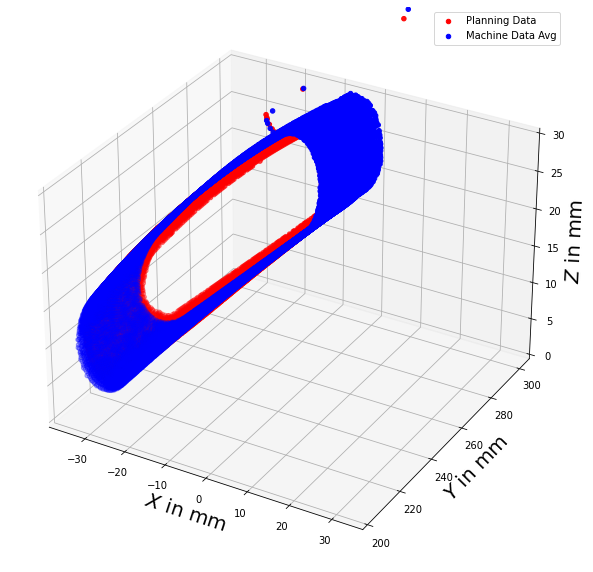

In [28]:
# Plot to show clusters
xdata, ydata, zdata = np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),)

plt.figure(figsize=(10,15))
ax = plt.axes(projection='3d')
ax.set_zlim3d([0,30])
ax.set_xlabel('$X$ in mm', fontsize=20)
ax.set_ylabel('$Y$ in mm', fontsize=20)
ax.set_zlabel('$Z$ in mm', fontsize=20)

for i in np.arange(len(pltlst)):
    xdata[i] = tool_tip_X[pltlst[i]]
    ydata[i] = tool_tip_Y[pltlst[i]]
    zdata[i] = tool_tip_Z[pltlst[i]]

ax.scatter3D(xdata, ydata, zdata, color = 'red',label = 'Planning Data')
ax.legend()

xdata2, ydata2, zdata2 = np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),)

for i in np.arange(len(pltlst)):
    xdata2[i] = np.average(X[tuple([lst3[pltlst[i]]])])
    ydata2[i] = np.average(Y[tuple([lst3[pltlst[i]]])])
    zdata2[i] = np.average(Z[tuple([lst3[pltlst[i]]])])

ax.scatter3D(xdata2, ydata2, zdata2, color = 'blue',label = 'Machine Data Avg')
ax.legend()

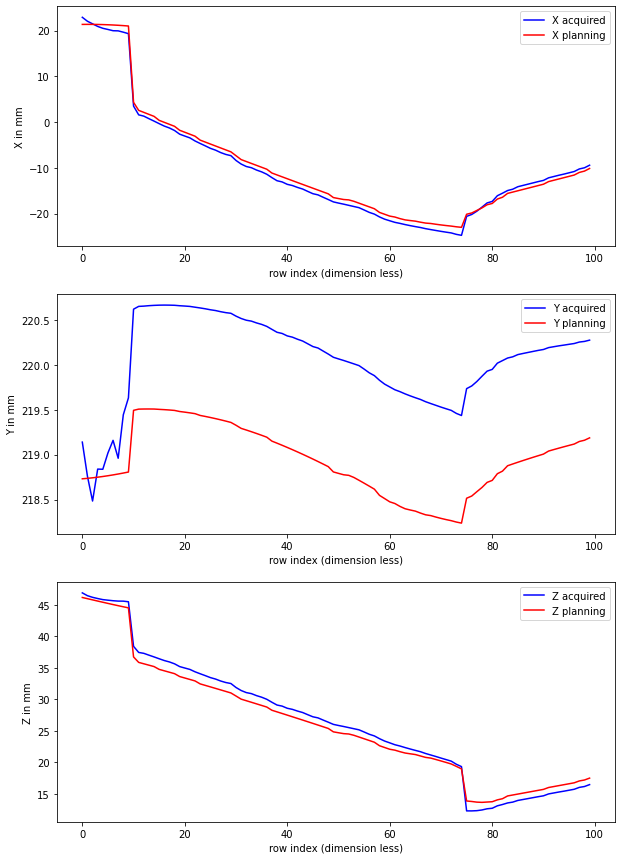

In [29]:
#subplotter(0,xdata.shape[0],xdata2,ydata2,zdata2,xdata,ydata,zdata)
subplotter(0,100,xdata2,ydata2,zdata2,xdata,ydata,zdata)

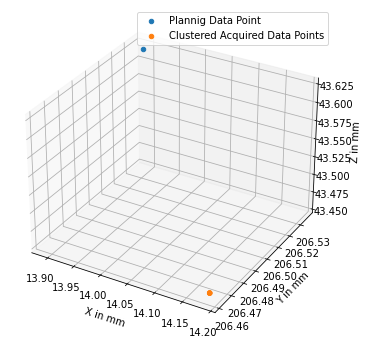

In [30]:
num = -10
xdata, ydata, zdata = np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),)

plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')

ax.scatter3D(tool_tip_X[pltlst[num]],tool_tip_Y[pltlst[num]] , tool_tip_Z[pltlst[num]],label='Plannig Data Point')

for i in np.arange(len(lst3[pltlst[num]])):
    xdata[i] = X[lst3[pltlst[num]]][i]
    ydata[i] = Y[lst3[pltlst[num]]][i]
    zdata[i] = Z[lst3[pltlst[num]]][i]
    
ax.scatter3D(xdata, ydata, zdata, label = 'Clustered Acquired Data Points')
ax.set_xlabel('X in mm', fontsize=10)
ax.set_ylabel('Y in mm', fontsize=10)
ax.set_zlabel('Z in mm', fontsize=10)
plt.legend()

Input two numbers between 0 and 21771 with small difference for plots exaple 10000 then 10010
0


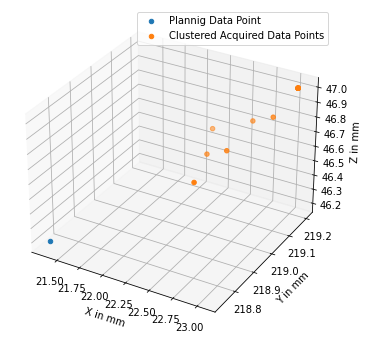

In [31]:
#for num in np.arange(len(pltlst)):
print('Input two numbers between 0 and {} with small difference for plots exaple 10000 then 10010'.format(len(pltlst)))
#lim1 = input()
#lim2 = input()

lim1 = 0
lim2 = 1

for num in np.arange(len(pltlst[int(lim1):int(lim2)])):
    xdata, ydata, zdata = np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),)
    
    fig = plt.figure(figsize=(6,6))
    print(num)
    ax = plt.axes(projection='3d')

    ax.scatter3D(tool_tip_X[pltlst[num]],tool_tip_Y[pltlst[num]] , tool_tip_Z[pltlst[num]], label='Plannig Data Point')

    for i in np.arange(len(lst3[pltlst[num]])):
        xdata[i] = X[lst3[pltlst[num]]][i]
        ydata[i] = Y[lst3[pltlst[num]]][i]
        zdata[i] = Z[lst3[pltlst[num]]][i]
    
    ax.scatter3D(xdata, ydata, zdata, label = 'Clustered Acquired Data Points')
    ax.set_xlabel('X in mm', fontsize=10)
    ax.set_ylabel('Y in mm', fontsize=10)
    ax.set_zlabel('Z in mm', fontsize=10)
    plt.legend()
    plt.pause(0.1)
   

In [32]:
# for the clusterd points the acquired points are averaged
lst4 = []
for i in np.arange(len(lst3)):
    lst4.append(df_m.iloc[list(lst3[i])].mean(axis=0))
    
mean_m = pd.concat(lst4,axis=1).T
mean_m.iloc[-100:-1]

time    MachineX   MachineY    MachineZ   MachineA    MachineC  \
35861  325.720001   -104.2302   -77.5062   -169.2374   -75.6809    347.4168   
35862  321.385002   -104.2857   -77.7523   -169.1062   -75.7318    347.4003   
35863  323.557499  -103.95855  -77.81455   -168.9259   -75.6943    347.4725   
35864         NaN         NaN        NaN         NaN        NaN         NaN   
35865  321.400002   -103.6959   -78.1293   -168.6143   -75.7057     347.529   
35866  325.739998   -103.3325    -78.088   -168.5015   -75.6478    347.6173   
35867  321.404999    -103.417   -78.3213   -168.3784   -75.6932    347.5941   
35868  323.582499  -103.09845   -78.4026    -168.207  -75.65895     347.673   
35869         NaN         NaN        NaN         NaN        NaN         NaN   
35870         NaN         NaN        NaN         NaN        NaN         NaN   
35871  322.295999  -102.60246  -78.87556  -167.71852  -75.64826   347.80244   
35872         NaN         NaN        NaN         NaN        NaN         NaN   
35873  321.440002   -102.3183   -79.1747   -167.4258   -75.6419    347.8835   
35874  325.783749    -101.949   -79.1698   -167.3246   -75.5937    347.9884   
35875  317.110001   -102.1118   -79.6867   -167.0073   -75.6597    347.9527   
35876  325.797501   -101.6006   -79.4845   -167.0176   -75.5793    348.0984   
35877  318.566666 -101.745667 -79.920433    -166.747   -75.6298    348.0705   
35878         NaN         NaN        NaN         NaN        NaN         NaN   
35879  320.032499 -101.426667 -80.122667   -166.5292   -75.6032    348.1793   
35880         NaN         NaN        NaN         NaN        NaN         NaN   
35881   322.56875 -101.052275 -80.298725 -166.327975   -75.5709  348.309125   
35882         NaN         NaN        NaN         NaN        NaN         NaN   
35883  322.367999  -100.79742  -80.59776  -166.07098   -75.5578   348.41622   
35884         NaN         NaN        NaN         NaN        NaN         NaN   
35885  317.177502   -100.7391   -81.1516   -165.6704     -75.57    348.4948   
35886  321.504997   -100.5327   -80.9839   -165.7581   -75.5462    348.5449   
35887  321.522503   -100.3425   -81.2185    -165.565  -75.53345    348.6419   
35888  321.529999   -100.3029   -81.2663   -165.5275   -75.5318    348.6618   
35889  320.670999  -100.16546   -81.5323  -165.32224  -75.52314   348.75374   
35890         NaN         NaN        NaN         NaN        NaN         NaN   
35891  320.109998    -99.9967 -81.816633 -165.101667   -75.5111  348.869367   
35892     321.555    -99.8937   -81.7985   -165.1051   -75.5042    348.9021   
35893  321.566248     -99.744  -82.00205   -164.9437    -75.492   349.00485   
35894  321.567501    -99.7123   -82.0437   -164.9123   -75.4905    349.0257   
35895  325.907497    -99.3427   -82.0713   -164.8613    -75.466    349.1704   
35896    321.5825    -99.5443   -82.2726   -164.7309   -75.4767    349.1518   
35897  317.259998    -99.6589   -82.5983   -164.4928   -75.4752    349.2175   
35898  323.763335    -99.2814  -82.39085   -164.6228  -75.45855    349.2904   
35899         NaN         NaN        NaN         NaN        NaN         NaN   
35900  321.612501    -99.2611 -82.654733   -164.4188   -75.4504    349.3974   
35901         NaN         NaN        NaN         NaN        NaN         NaN   
35902  321.628499   -99.12746  -82.82526  -164.27154    -75.437    349.5286   
35903         NaN         NaN        NaN         NaN        NaN         NaN   
35904  322.510001   -98.93968  -82.96134  -164.14254  -75.42184   349.67938   
35905         NaN         NaN        NaN         NaN        NaN         NaN   
35906  322.277143  -98.833886 -83.096814 -164.007886 -75.408829    349.8147   
35907         NaN         NaN        NaN         NaN        NaN         NaN   
35908  317.337498    -99.0462   -83.2981   -163.8014   -75.3985    349.8984   
35909  321.677502    -98.7405   -83.2305   -163.8584   -75.3944    349.9693   
35910  324.285001   -98.47204    -83.251  -163.80744  -75.38178

In [33]:
# distances are averaged
tcp_avg = [(lambda x: sum(x)/len(x))(item) if len(item)!=0 else np.nan for item in tcp_val]
len(tcp_avg)
#tcp_avg

35961

In [34]:
# Now the final dataframe with plannind data and the corresponding averaged acquired data is obtained 
final_df = pd.concat([df_p,mean_m, pd.DataFrame({'tcp_error':tcp_avg})], axis=1)
final_df = final_df.drop(['Level','Step'],axis=1)
final_df = final_df.dropna()
print(final_df.shape)
final_df.iloc[0:10]

(21771, 69)


Leading angle  Side tilt angle  Surface Contact point X  \
8        0.605350         0.136441                20.230158   
9        0.597177         0.185822                20.229862   
10       0.586565         0.232489                20.229565   
11       0.573636         0.276109                20.229269   
12       0.558518         0.316495                20.228972   
13       0.541344         0.353585                20.228676   
14       0.522242         0.387416                20.228379   
15       0.501340         0.418094                20.228083   
16       0.478759         0.445778                20.227786   
17       0.454614         0.470650                20.227489   

    Surface contact point Y  Surface contact point z  Surface Orietation X  \
8                220.072035                39.789210             -0.152592   
9                220.072062                39.789089             -0.152594   
10               220.072090                39.788968             -0.152597   
11               220.072117                39.788846             -0.152599   
12               220.072145                39.788725             -0.152602   
13               220.072173                39.788604             -0.152604   
14               220.072200                39.788483             -0.152606   
15               220.072228                39.788361             -0.152609   
16               220.072255                39.788240             -0.152611   
17               220.072283                39.788119             -0.152614   

    Surface Orietation Y  Surface Orietation Z  Tool Tip Point X  \
8               0.816819              0.556347         21.342939   
9               0.816819              0.556346         21.351183   
10              0.816819              0.556346         21.347464   
11              0.816819              0.556345         21.331797   
12              0.816819              0.556345         21.304243   
13              0.816819              0.556344         21.264914   
14              0.816819              0.556344         21.213966   
15              0.816819              0.556343         21.151604   
16              0.816818              0.556343         21.078077   
17              0.816818              0.556343         20.993679   

    Tool Tip Point Y  Tool Tip Point Z  Tool Orientation X  \
8         218.730804         46.195240            0.001198   
9         218.735870         46.005775            0.001198   
10        218.741852         45.816193            0.001198   
11        218.748688         45.627251            0.001198   
12        218.756363         45.439705            0.001198   
13        218.764847         45.254307            0.001198   
14        218.774109         45.071800            0.001198   
15        218.784103         44.892910            0.001198   
16        218.794815         44.718349            0.001198   
17        218.806168         44.548824            0.001198   

    Tool Orientation Y  Tool Orientation Z  \
8             0.999999            0.000856   
9             0.999999            0.000856   
10            0.999999            0.000856   
11            0.999999            0.000856   
12            0.999999            0.000856   
13            0.999999            0.000856   
14            0.999999            0.000856   
15            0.999999            0.000856   
16            0.999999            0.000856   
17            0.999999            0.000856   

    Closes Point Distance (Surface Contact Point - Acquired TCP 1030 blade0)  \
8                                            5.929007                          
9                                            5.929006                          
10                                           5.929005                          
11                                           5.929004                          
12                                           5.929003                          
13                              

### Using Combined dataset Peaks Elimination:
Inspite of the average, there are some high impuse peaks observed in the data (Run the visualiation.ipnby), these must be removed to obtain a flawless, reliable dataset. Using machine data from newly created combined dataset same forward transformation is performed as discribled above. by observing the data, it can be seen that the using just one of the components (in this case Y) all the outlers can be eliminated. Two types of spikes are typicalled observed (check visualizaion by runnung  vizualization.ipnyb) one in positive direction and othes in negetive direction, so for robostness both are considered. At the same time, it is not wise to remove the original expected trajectory of the tool path in begining and the end, so especially for the positive direction they are intentionally not removed. if each peak on a plateu has to be removed its very expensive, so if two neighbous are consicutively classifies as peaks (given by count), it is assumed as plateu and 100 datapoint sare removed. This is a reasonable compromise in accuracy for significant speedup

<img src="images/peak_eli.png">

In [35]:
#final_df = pd.read_excel('Final_df/finaldf_forward_with_compensation1030__24.xlsx' )

### Visulaization of outliers peaks

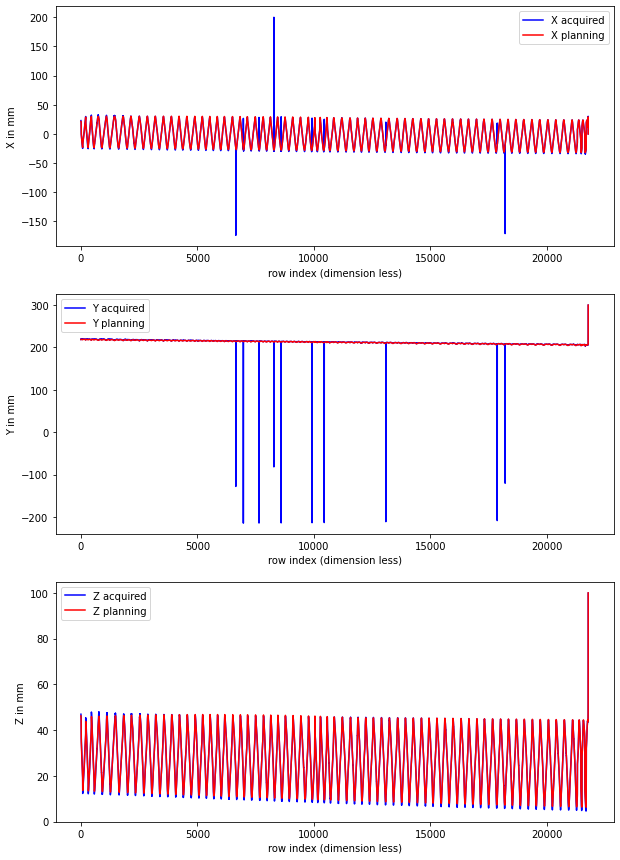

In [36]:
x_final = final_df['MachineX'].copy(deep=True)                 # using machine data from newly created combined dataset
y_final = final_df['MachineY'].copy(deep=True)
z_final = final_df['MachineZ'].copy(deep=True)
a_final = final_df['MachineA'].copy(deep=True)
c_final = final_df['MachineC'].copy(deep=True)

size1_final = x_final.shape[0]

# converting pandas series to numpy array
x_final = x_final.to_numpy()
y_final = y_final.to_numpy()
z_final = z_final.to_numpy()
a_final = a_final.to_numpy(dtype =  np.float64)
a_final = np.deg2rad(a_final)
c_final = c_final.to_numpy(dtype =  np.float64)
c_final = np.deg2rad(c_final)

tool_tip_X_final = final_df['Tool Tip Point X'].to_numpy()        # using newly created combined dataset
tool_tip_Y_final = final_df['Tool Tip Point Y'].to_numpy()
tool_tip_Z_final = final_df['Tool Tip Point Z'].to_numpy()
    
X_inv_final = tool_tip_X_final
Y_inv_final = tool_tip_Y_final
Z_inv_final = tool_tip_Z_final
    
#compensation_values
compensation_values = compensation_values_df.to_numpy()

# Within each cube we have ranges defined in x,y,z for the machine position

x_range = np.arange(-200,201,100)
y_range = np.arange(-300,301,150)
z_range = np.arange(-500,1,50)

obj3_final = compensation.Compensation(compensation_values,x_range,y_range,z_range)

# Caclculation of compensation error values based on machine positions obtained through inverse transformation
deltaX1_final, deltaY1_final, deltaZ1_final,deltaI1_final,deltaJ1_final,deltaK1_final = obj3_final.calculate(x_final,y_final,z_final)  
size3_final = x_final.shape[0]
conc3_final = np.concatenate((deltaX1_final.reshape(size3_final,1),deltaY1_final.reshape(size3_final,1),deltaZ1_final.reshape(size3_final,1),deltaI1_final.reshape(size3_final,1),deltaJ1_final.reshape(size3_final,1),deltaK1_final.reshape(size3_final,1)),axis=1)

# prininting the compensation error values
df_obj3_final = pd.DataFrame(conc3_final, columns=['deltaX1 final','deltaY1 final','deltaZ1 final','deltaI1 final','deltaJ1 final','deltaK1 final'])
df_obj3_final.head(5)  

x_compensated_final = x_final + deltaX1_final*10**-3    # since given compensation is to be converted from microns to mm (10**-6 x 10**3 = 10**-3)
y_compensated_final = y_final + deltaY1_final*10**-3
z_compensated_final = z_final + deltaZ1_final*10**-3

conc4_final = np.concatenate((x_compensated_final.reshape(size3_final,1),y_compensated_final.reshape(size3_final,1),z_compensated_final.reshape(size3_final,1)),axis=1)
df_obj4_final = pd.DataFrame(conc4_final, columns=['x_compensated final','y_compensated final','z_compensated final'])

obj_final = transformation.Transformation(size1_final,angle)
# Forward Transformation fuction:
# Input : Machine points in machine coordinate system
# Output: returns too tip points and orientation in workpiece coordinate system
tool_position_workpiece_CS_final, tool_orientation_workpiece_CS_final = obj_final.forward(x_compensated_final,y_compensated_final,z_compensated_final,a_final,c_final)

X_final = tool_position_workpiece_CS_final[0,0,:]
Y_final = tool_position_workpiece_CS_final[1,0,:]
Z_final = tool_position_workpiece_CS_final[2,0,:]

I_final = tool_orientation_workpiece_CS_final[0,0,:]
J_final = tool_orientation_workpiece_CS_final[1,0,:]
K_final = tool_orientation_workpiece_CS_final[2,0,:]

# Verification the correctness of code, i.e on applying reverse transformation on the forward transformation we should get same values
machine_points_xyz_final, machine_direction_ac_final = obj_final.backward(X_final,Y_final,Z_final,I_final,J_final,K_final)

x_out_final = machine_points_xyz_final[0,0,:]
y_out_final = machine_points_xyz_final[1,0,:]
z_out_final = machine_points_xyz_final[2,0,:]

a_out_final = machine_direction_ac_final[0,0,:]
c_out_final = machine_direction_ac_final[1,0,:]

conc1_final = np.concatenate((x_final.reshape(size1_final,1),x_out_final.reshape(size1_final,1),y_final.reshape(size1_final,1),y_out_final.reshape(size1_final,1),z_final.reshape(size1_final,1),z_out_final.reshape(size1_final,1),a_final.reshape(size1_final,1),a_out_final.reshape(size1_final,1),c_final.reshape(size1_final,1),c_out_final.reshape(size1_final,1)),axis=1)
df_obj1_final = pd.DataFrame(conc1_final, columns=['x final','x_out final','y final','y_out final','z final','z_out final','a final','a_out final','c final','c_out'])

conc11_final = np.concatenate((x_final.reshape(size1_final,1),y_final.reshape(size1_final,1),z_final.reshape(size1_final,1),a_final.reshape(size1_final,1),c_final.reshape(size1_final,1),X_final.reshape(size1_final,1),Y_final.reshape(size1_final,1),Z_final.reshape(size1_final,1),I_final.reshape(size1_final,1),J_final.reshape(size1_final,1),K_final.reshape(size1_final,1)),axis=1)
dfout11_final = pd.DataFrame(conc11_final, columns=['x final','y final','z final','a final','c final','X final','Y final','Z final','I final','J final','K final'])
    
subplotter(0,final_df.shape[0],X_final,Y_final,Z_final,X_inv_final,Y_inv_final,Z_inv_final)   # using combined dataset

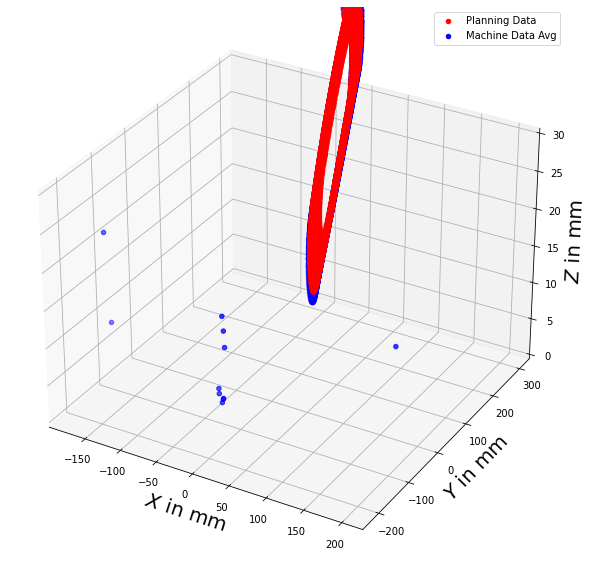

In [37]:
plt.figure(figsize=(10,15))
ax1 = plt.axes(projection='3d')
ax1.set_zlim3d([0,30])

ax1.set_xlabel('$X$ in mm', fontsize=20)
ax1.set_ylabel('$Y$ in mm', fontsize=20)
ax1.set_zlabel('$Z$ in mm', fontsize=20)

ax1.scatter3D(X_inv_final, Y_inv_final, Z_inv_final, color = 'red',label = 'Planning Data')
ax1.legend()

ax1.scatter3D(X_final, Y_final, Z_final, color = 'blue',label = 'Machine Data Avg')
ax1.legend()

In [38]:
def remove_peaks(final_df, compensation_values_df):
    x_final = final_df['MachineX'].copy(deep=True)                 # using machine data from newly created combined dataset
    y_final = final_df['MachineY'].copy(deep=True)
    z_final = final_df['MachineZ'].copy(deep=True)
    a_final = final_df['MachineA'].copy(deep=True)
    c_final = final_df['MachineC'].copy(deep=True)

    size1_final = x_final.shape[0]

    # converting pandas series to numpy array
    x_final = x_final.to_numpy()
    y_final = y_final.to_numpy()
    z_final = z_final.to_numpy()
    a_final = a_final.to_numpy(dtype =  np.float64)
    a_final = np.deg2rad(a_final)
    c_final = c_final.to_numpy(dtype =  np.float64)
    c_final = np.deg2rad(c_final)

    tool_tip_X_final = final_df['Tool Tip Point X'].to_numpy()        # using newly created combined dataset
    tool_tip_Y_final = final_df['Tool Tip Point Y'].to_numpy()
    tool_tip_Z_final = final_df['Tool Tip Point Z'].to_numpy()
    
    X_inv_final = tool_tip_X_final
    Y_inv_final = tool_tip_Y_final
    Z_inv_final = tool_tip_Z_final
    
    #compensation_values
    compensation_values = compensation_values_df.to_numpy()

    # Within each cube we have ranges defined in x,y,z for the machine position

    x_range = np.arange(-200,201,100)
    y_range = np.arange(-300,301,150)
    z_range = np.arange(-500,1,50)

    obj3_final = compensation.Compensation(compensation_values,x_range,y_range,z_range)

    # Caclculation of compensation error values based on machine positions obtained through inverse transformation
    deltaX1_final, deltaY1_final, deltaZ1_final,deltaI1_final,deltaJ1_final,deltaK1_final = obj3_final.calculate(x_final,y_final,z_final)  
    size3_final = x_final.shape[0]
    conc3_final = np.concatenate((deltaX1_final.reshape(size3_final,1),deltaY1_final.reshape(size3_final,1),deltaZ1_final.reshape(size3_final,1),deltaI1_final.reshape(size3_final,1),deltaJ1_final.reshape(size3_final,1),deltaK1_final.reshape(size3_final,1)),axis=1)

    # prininting the compensation error values
    df_obj3_final = pd.DataFrame(conc3_final, columns=['deltaX1 final','deltaY1 final','deltaZ1 final','deltaI1 final','deltaJ1 final','deltaK1 final'])
    df_obj3_final.head(5)  

    x_compensated_final = x_final + deltaX1_final*10**-3    # since given compensation is to be converted from microns to mm (10**-6 x 10**3 = 10**-3)
    y_compensated_final = y_final + deltaY1_final*10**-3
    z_compensated_final = z_final + deltaZ1_final*10**-3

    conc4_final = np.concatenate((x_compensated_final.reshape(size3_final,1),y_compensated_final.reshape(size3_final,1),z_compensated_final.reshape(size3_final,1)),axis=1)
    df_obj4_final = pd.DataFrame(conc4_final, columns=['x_compensated final','y_compensated final','z_compensated final'])

    obj_final = transformation.Transformation(size1_final,angle)
    # Forward Transformation fuction:
    # Input : Machine points in machine coordinate system
    # Output: returns too tip points and orientation in workpiece coordinate system
    tool_position_workpiece_CS_final, tool_orientation_workpiece_CS_final = obj_final.forward(x_compensated_final,y_compensated_final,z_compensated_final,a_final,c_final)

    X_final = tool_position_workpiece_CS_final[0,0,:]
    Y_final = tool_position_workpiece_CS_final[1,0,:]
    Z_final = tool_position_workpiece_CS_final[2,0,:]

    I_final = tool_orientation_workpiece_CS_final[0,0,:]
    J_final = tool_orientation_workpiece_CS_final[1,0,:]
    K_final = tool_orientation_workpiece_CS_final[2,0,:]

    # Verification the correctness of code, i.e on applying reverse transformation on the forward transformation we should get same values
    machine_points_xyz_final, machine_direction_ac_final = obj_final.backward(X_final,Y_final,Z_final,I_final,J_final,K_final)

    x_out_final = machine_points_xyz_final[0,0,:]
    y_out_final = machine_points_xyz_final[1,0,:]
    z_out_final = machine_points_xyz_final[2,0,:]

    a_out_final = machine_direction_ac_final[0,0,:]
    c_out_final = machine_direction_ac_final[1,0,:]

    conc1_final = np.concatenate((x_final.reshape(size1_final,1),x_out_final.reshape(size1_final,1),y_final.reshape(size1_final,1),y_out_final.reshape(size1_final,1),z_final.reshape(size1_final,1),z_out_final.reshape(size1_final,1),a_final.reshape(size1_final,1),a_out_final.reshape(size1_final,1),c_final.reshape(size1_final,1),c_out_final.reshape(size1_final,1)),axis=1)
    df_obj1_final = pd.DataFrame(conc1_final, columns=['x final','x_out final','y final','y_out final','z final','z_out final','a final','a_out final','c final','c_out'])

    conc11_final = np.concatenate((x_final.reshape(size1_final,1),y_final.reshape(size1_final,1),z_final.reshape(size1_final,1),a_final.reshape(size1_final,1),c_final.reshape(size1_final,1),X_final.reshape(size1_final,1),Y_final.reshape(size1_final,1),Z_final.reshape(size1_final,1),I_final.reshape(size1_final,1),J_final.reshape(size1_final,1),K_final.reshape(size1_final,1)),axis=1)
    dfout11_final = pd.DataFrame(conc11_final, columns=['x final','y final','z final','a final','c final','X final','Y final','Z final','I final','J final','K final'])
    
    #subplotter(0,final_df.shape[0],X_final,Y_final,Z_final,X_inv_final,Y_inv_final,Z_inv_final)   # using combined dataset
    
    return Y_final, final_df

In [39]:
# Peak removal: by observing the data,
# it can be seen that the using just one of the components (in this case Y) all the outlers can be eliminated. 
count = 0
col = final_df.columns
while True:
    Y_final, final_df = remove_peaks(final_df,compensation_values_df)
    # Two types of spikes are typicalled observed (check visualizaion by runnung  vizualization.ipnyb) 
    # one in positive direction and othes in negetive direction, so for robostness both are considered. 
    # At the same time, it is not wise to remove the original expected trajectory of the tool path in begining and the end,
    # so especially for the positive direction they are intentionally not removed 
    
    peaks1, _ = find_peaks(-Y_final, height=(-175,None))
    peaks2,_ = find_peaks(Y_final[0:-1000], height=(240,None))
    peaks = list(peaks1) + list(peaks2)
    print(peaks)
    
    if(len(peaks)==0):
        break
        
    # if each peak on a plateu has to be removed its very expensive, so if two neighbous are consicutively classifies as peaks 
    # (given by count), it is assumed as plateu and 100 datapoint sare removed.
    # This is a reasonable compromise in accuracy for significant speedup
        
    #elif(len(peaks)==1 and abs(Y_final[peaks[0]] - Y_final[peaks[0]+20] )<=0.3):
    elif(len(peaks)==1 and count>2):
        arr = final_df.to_numpy()
        arr = np.delete(arr, np.arange(peaks[0],peaks[0]+100), 0)
        final_df = pd.DataFrame(arr,columns=col)
        count = 0
        
    else:
        arr = final_df.to_numpy()
        arr = np.delete(arr,peaks, 0)
        final_df = pd.DataFrame(arr,columns=col)
        count = count+1
        
        

[6646, 6970, 7642, 8281, 8592, 9919, 10441, 13085, 17866, 18205]
[9913]
[]


### Visulaiztion of effect of removing peaks

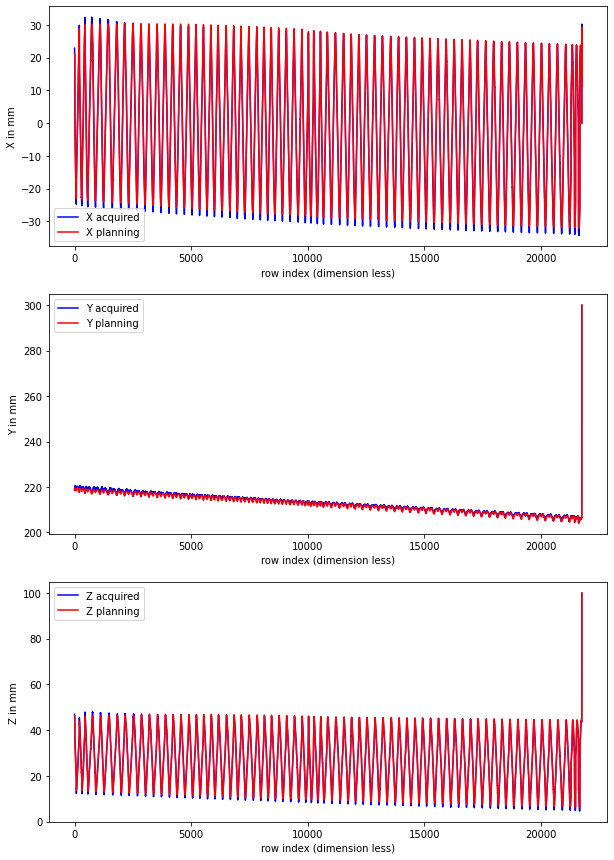

In [40]:
x_final = final_df['MachineX'].copy(deep=True)                 # using machine data from newly created combined dataset
y_final = final_df['MachineY'].copy(deep=True)
z_final = final_df['MachineZ'].copy(deep=True)
a_final = final_df['MachineA'].copy(deep=True)
c_final = final_df['MachineC'].copy(deep=True)

size1_final = x_final.shape[0]

# converting pandas series to numpy array
x_final = x_final.to_numpy()
y_final = y_final.to_numpy()
z_final = z_final.to_numpy()
a_final = a_final.to_numpy(dtype =  np.float64)
a_final = np.deg2rad(a_final)
c_final = c_final.to_numpy(dtype =  np.float64)
c_final = np.deg2rad(c_final)

tool_tip_X_final = final_df['Tool Tip Point X'].to_numpy()        # using newly created combined dataset
tool_tip_Y_final = final_df['Tool Tip Point Y'].to_numpy()
tool_tip_Z_final = final_df['Tool Tip Point Z'].to_numpy()
    
X_inv_final = tool_tip_X_final
Y_inv_final = tool_tip_Y_final
Z_inv_final = tool_tip_Z_final
    
#compensation_values
compensation_values = compensation_values_df.to_numpy()

# Within each cube we have ranges defined in x,y,z for the machine position

x_range = np.arange(-200,201,100)
y_range = np.arange(-300,301,150)
z_range = np.arange(-500,1,50)

obj3_final = compensation.Compensation(compensation_values,x_range,y_range,z_range)

# Caclculation of compensation error values based on machine positions obtained through inverse transformation
deltaX1_final, deltaY1_final, deltaZ1_final,deltaI1_final,deltaJ1_final,deltaK1_final = obj3_final.calculate(x_final,y_final,z_final)  
size3_final = x_final.shape[0]
conc3_final = np.concatenate((deltaX1_final.reshape(size3_final,1),deltaY1_final.reshape(size3_final,1),deltaZ1_final.reshape(size3_final,1),deltaI1_final.reshape(size3_final,1),deltaJ1_final.reshape(size3_final,1),deltaK1_final.reshape(size3_final,1)),axis=1)

# prininting the compensation error values
df_obj3_final = pd.DataFrame(conc3_final, columns=['deltaX1 final','deltaY1 final','deltaZ1 final','deltaI1 final','deltaJ1 final','deltaK1 final'])
df_obj3_final.head(5)  

x_compensated_final = x_final + deltaX1_final*10**-3    # since given compensation is to be converted from microns to mm (10**-6 x 10**3 = 10**-3)
y_compensated_final = y_final + deltaY1_final*10**-3
z_compensated_final = z_final + deltaZ1_final*10**-3

conc4_final = np.concatenate((x_compensated_final.reshape(size3_final,1),y_compensated_final.reshape(size3_final,1),z_compensated_final.reshape(size3_final,1)),axis=1)
df_obj4_final = pd.DataFrame(conc4_final, columns=['x_compensated final','y_compensated final','z_compensated final'])

obj_final = transformation.Transformation(size1_final,angle)
# Forward Transformation fuction:
# Input : Machine points in machine coordinate system
# Output: returns too tip points and orientation in workpiece coordinate system
tool_position_workpiece_CS_final, tool_orientation_workpiece_CS_final = obj_final.forward(x_compensated_final,y_compensated_final,z_compensated_final,a_final,c_final)

X_final = tool_position_workpiece_CS_final[0,0,:]
Y_final = tool_position_workpiece_CS_final[1,0,:]
Z_final = tool_position_workpiece_CS_final[2,0,:]

I_final = tool_orientation_workpiece_CS_final[0,0,:]
J_final = tool_orientation_workpiece_CS_final[1,0,:]
K_final = tool_orientation_workpiece_CS_final[2,0,:]

# Verification the correctness of code, i.e on applying reverse transformation on the forward transformation we should get same values
machine_points_xyz_final, machine_direction_ac_final = obj_final.backward(X_final,Y_final,Z_final,I_final,J_final,K_final)

x_out_final = machine_points_xyz_final[0,0,:]
y_out_final = machine_points_xyz_final[1,0,:]
z_out_final = machine_points_xyz_final[2,0,:]

a_out_final = machine_direction_ac_final[0,0,:]
c_out_final = machine_direction_ac_final[1,0,:]

conc1_final = np.concatenate((x_final.reshape(size1_final,1),x_out_final.reshape(size1_final,1),y_final.reshape(size1_final,1),y_out_final.reshape(size1_final,1),z_final.reshape(size1_final,1),z_out_final.reshape(size1_final,1),a_final.reshape(size1_final,1),a_out_final.reshape(size1_final,1),c_final.reshape(size1_final,1),c_out_final.reshape(size1_final,1)),axis=1)
df_obj1_final = pd.DataFrame(conc1_final, columns=['x final','x_out final','y final','y_out final','z final','z_out final','a final','a_out final','c final','c_out'])

conc11_final = np.concatenate((x_final.reshape(size1_final,1),y_final.reshape(size1_final,1),z_final.reshape(size1_final,1),a_final.reshape(size1_final,1),c_final.reshape(size1_final,1),X_final.reshape(size1_final,1),Y_final.reshape(size1_final,1),Z_final.reshape(size1_final,1),I_final.reshape(size1_final,1),J_final.reshape(size1_final,1),K_final.reshape(size1_final,1)),axis=1)
dfout11_final = pd.DataFrame(conc11_final, columns=['x final','y final','z final','a final','c final','X final','Y final','Z final','I final','J final','K final'])
    
subplotter(0,final_df.shape[0],X_final,Y_final,Z_final,X_inv_final,Y_inv_final,Z_inv_final)   # using combined dataset

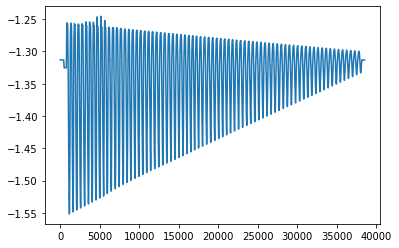

In [36]:
plt.plot(a)

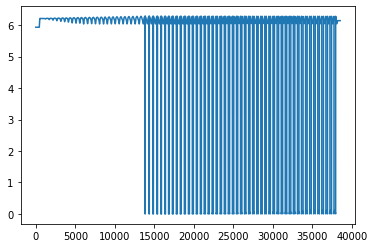

In [35]:
plt.plot(c)

Text(0.5, 1.0, 'TCP Error plot')

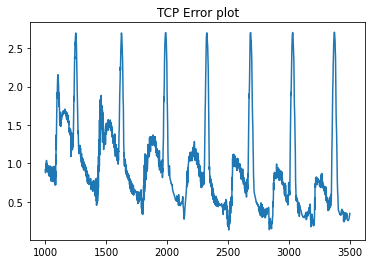

In [41]:
plt.plot((final_df['tcp_error']).iloc[1000:3500])
plt.title('TCP Error plot')

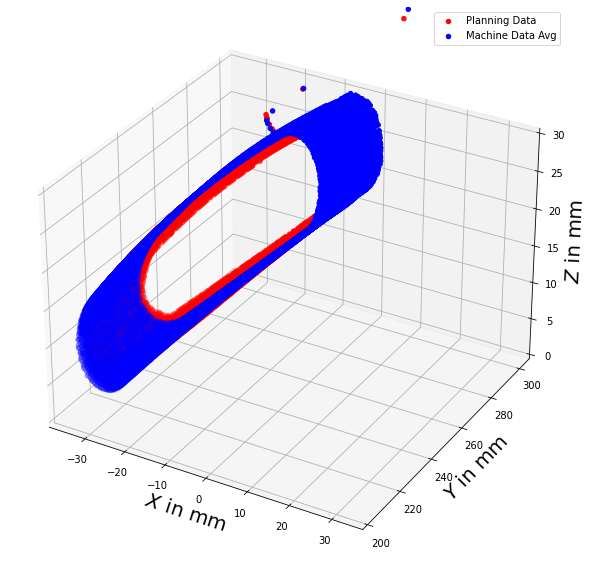

In [42]:
plt.figure(figsize=(10,15))
ax1 = plt.axes(projection='3d')
ax1.set_zlim3d([0,30])

ax1.set_xlabel('$X$ in mm', fontsize=20)
ax1.set_ylabel('$Y$ in mm', fontsize=20)
ax1.set_zlabel('$Z$ in mm', fontsize=20)

ax1.scatter3D(X_inv_final, Y_inv_final, Z_inv_final, color = 'red',label = 'Planning Data')
ax1.legend()

ax1.scatter3D(X_final, Y_final, Z_final, color = 'blue',label = 'Machine Data Avg')
ax1.legend()

In [43]:
mean = final_df['tcp_error'].mean()
mean

0.6680820393282884

In [44]:
median = final_df['tcp_error'].median()
median

0.34508586395022456

In [45]:
minimum = final_df['tcp_error'].min()
minimum

0.08460864350350288

In [46]:
maximum = final_df['tcp_error'].max()  
maximum

2.824390023536972

In [47]:
final_df = final_df.iloc[0:21500]

In [ ]:
# saving data 
final_df.to_excel(str(dir_final_save)+'finaldf_forward_with_compensation'+str(block)+'__'+str(angle)+'.xlsx') 